In [518]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
from astropy.cosmology import z_at_value
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region, Linear_fit
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [519]:
alldb = pd.read_pickle('../dataframes/fitdb/all_1d_fits.pkl')

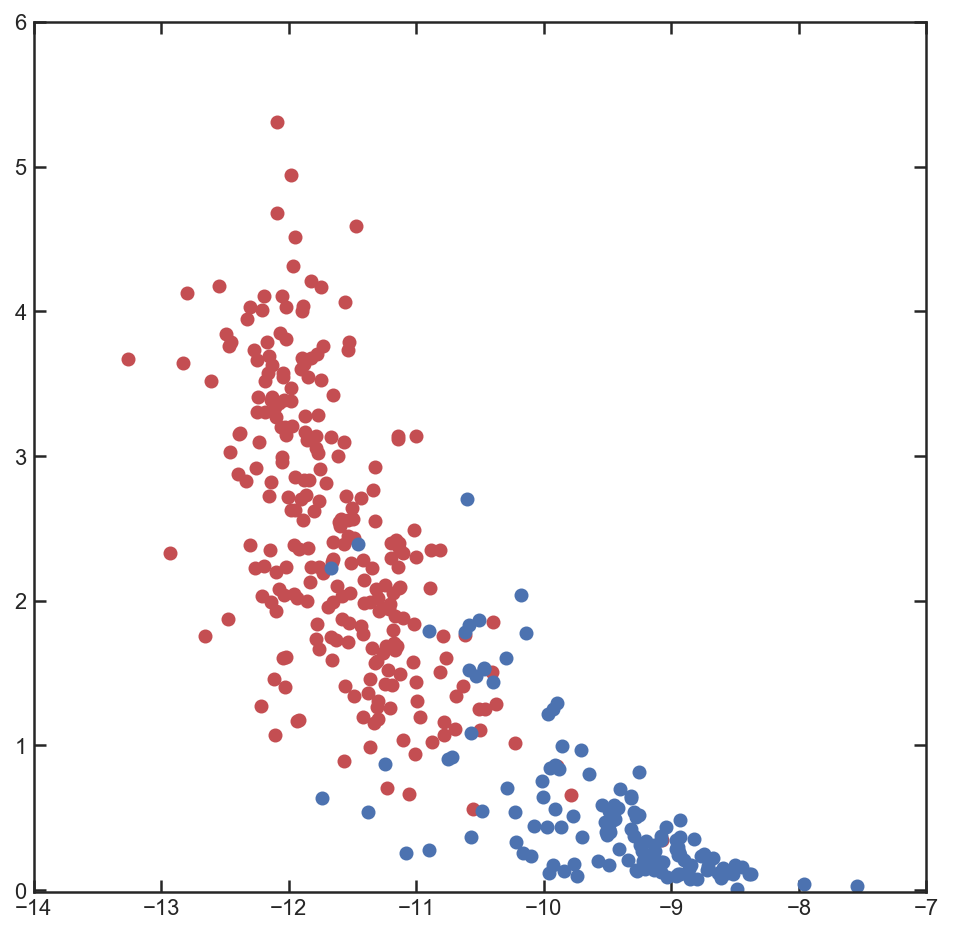

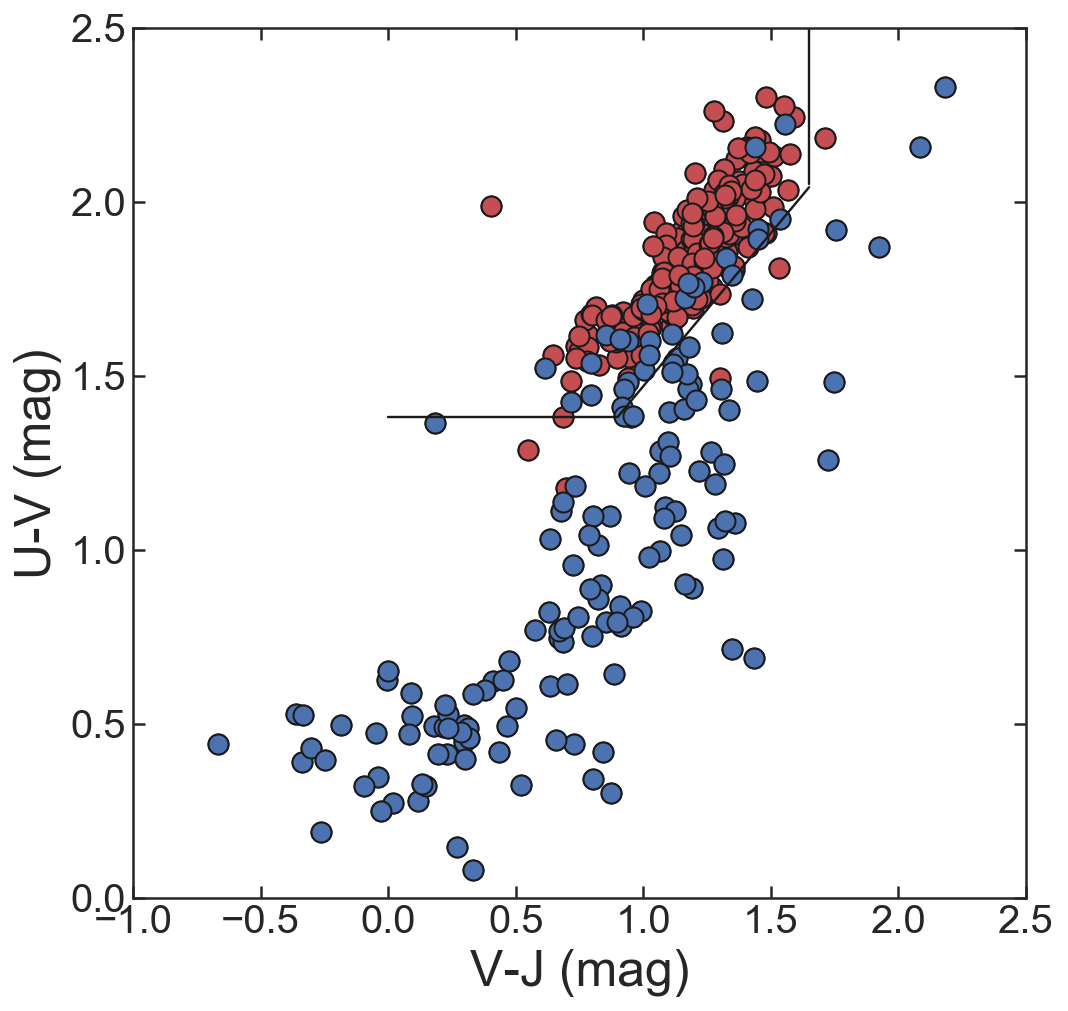

In [3]:
plt.figure(figsize=[8,8])
plt.scatter(alldb.query('UVJ == "Q"').log_ssfr, alldb.query('UVJ == "Q"').lwa, color = 'r')
plt.scatter(alldb.query('UVJ == "S"').log_ssfr, alldb.query('UVJ == "S"').lwa, color = 'b')
plt.ylim(-.01,6)
plt.xlim(-14,-7)

plt.figure(figsize=[8,8])

plt.scatter(alldb.query('log_ssfr <-11').VJ, alldb.query('log_ssfr <-11').UV,marker = 'o', s=100, color = '#EA2E3B',linewidths=1, edgecolors='k', zorder= 1)
plt.scatter(alldb.query('log_ssfr > -11').VJ, alldb.query('log_ssfr > -11').UV,marker = 'o', s=100, color = '#EA2E3B',linewidths=1, edgecolors='k', zorder = 1)

plt.scatter(alldb.query('log_ssfr <-11').VJ, alldb.query('log_ssfr <-11').UV,marker = 'o', s=100, color = 'r',linewidths=1, edgecolors='k', zorder= 1)
plt.scatter(alldb.query('log_ssfr > -11').VJ, alldb.query('log_ssfr > -11').UV,marker = 'o', s=100, color = 'b',linewidths=1, edgecolors='k', zorder =1)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([-1,2.5,0,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

In [520]:
# morph_db = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')
# morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 and Sigma1 > 10**9.7')
morph_db = alldb.query('UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333]
nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]

#  and morph_db.id[i] not in nog141  and morph_db.id[i] not in nog102

inout = []
for i in morph_db.index:
    if(morph_db.zgrism_hci[i][1] - morph_db.zgrism_hci[i][0]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01 and \
    morph_db.id[i] not in bspec and morph_db.id[i] not in nog102:
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [333]:
len(mdb)

95

# Figure 1

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda

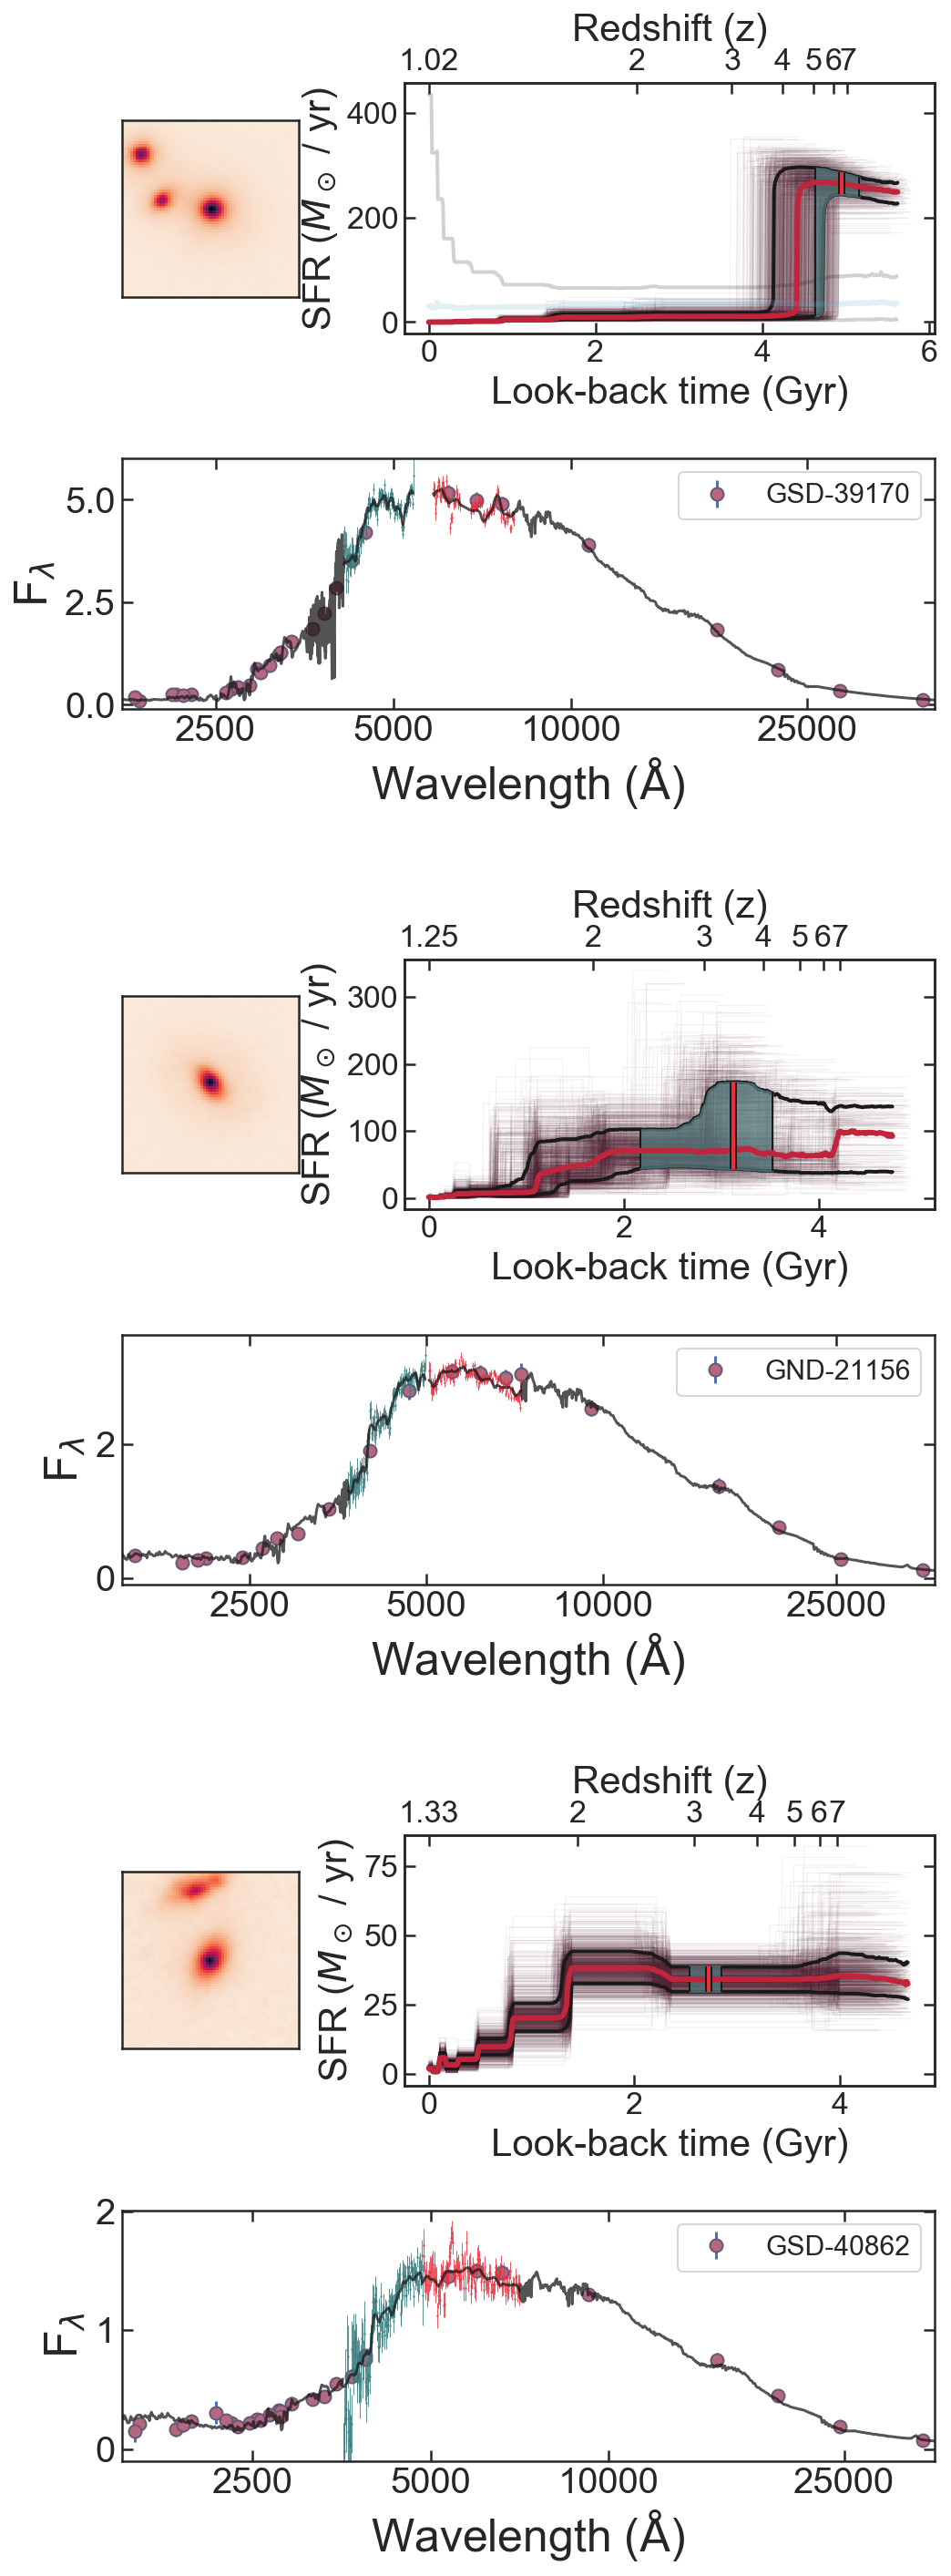

In [550]:

galaxies = [39170, 21156, 40862]

field = ['GSD','GND','GSD']

# galaxies = [39170]

# field = ['GSD']

gs = gridspec.GridSpec(3,1, hspace=0.4)
plt.figure(figsize =[8,24])

flip = True

for i in range(3):

    gsin = gridspec.GridSpecFromSubplotSpec(2,2, width_ratios=[1,3], subplot_spec= gs[i], hspace=0.5, wspace=0.3)

    grow = morph_db.query('id == {0}'.format(galaxies[i]))

    rsimg = np.load('../data/imgfiles/{0}_{1}_rsimg.npy'.format(field[i], galaxies[i]))

    ax1 = plt.subplot(gsin[0,0])
    ax1.imshow(-np.arcsinh(rsimg))#, vmin = -1, vmax = 0.1)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = plt.subplot(gsin[1,:])

    Gs = Gen_spec(field[i], galaxies[i], grow.zgrism.values[0], phot_errterm = 0.04, irac_err = 0.08) 
    Flam = Posterior_spec(field[i], galaxies[i])

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pbp1.npy'.format(field[i], galaxies[i]))
    bp1 = x[px == max(px)][0]
    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Prp1.npy'.format(field[i], galaxies[i]))
    rp1 = x[px == max(px)][0]

    Gs.Best_fit_scale_flam(Flam.wave, Flam.SPEC, Flam.rshift, bp1, rp1)

    sfh = Rescale_sfh(field[i], galaxies[i])

    ##############plot tab##################

    if Gs.g102:
        ax2.errorbar(np.log10(Gs.Bwv_rf),Gs.Bfl *1E18,Gs.Ber *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#36787A', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Bwv_rf),Gs.Bmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Bwv_rf[0]]
    else:
        IDB = [U for U in range(len(Flam.wave)) if Flam.wave[U] < Gs.Rwv_rf[0]]

    if Gs.g141:
        ax2.errorbar(np.log10(Gs.Rwv_rf),Gs.Rfl *1E18,Gs.Rer *1E18,
                linestyle='None', marker='o', markersize=0.25, color='#EA2E3B', zorder = 2, elinewidth = 0.4)
        ax2.plot(np.log10(Gs.Rwv_rf),Gs.Rmfl *1E18,'k', zorder = 4, alpha = 0.75)
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Rwv_rf[-1]]
    else:
        IDR = [U for U in range(len(Flam.wave)) if Flam.wave[U] > Gs.Bwv_rf[-1]]

    ax2.errorbar(np.log10(Gs.Pwv_rf),Gs.Pflx*1E18,Gs.Perr*1E18,
            linestyle='None', marker='o', markersize=7, markerfacecolor='#B5677D', zorder = 1,
                 markeredgecolor = '#685877',markeredgewidth = 1, label = '{0}-{1}'.format(field[i], galaxies[i]))

    ax2.plot(np.log10(Flam.wave)[IDB],Flam.SPEC[IDB]*1E18,'k', alpha = 0.75, zorder=5)
    ax2.plot(np.log10(Flam.wave)[IDR],Flam.SPEC[IDR]*1E18,'k', alpha = 0.75)
    ax2.set_xlim(np.log10(min(Gs.Pwv_rf)*0.95),np.log10(max(Gs.Pwv_rf)*1.05))
    ax2.set_ylim(-0.1,max(Gs.Rfl *1E18)*1.1)

    ax2.set_xticks(np.log10([2500,5000,10000,25000]))
    ax2.set_xticklabels(np.array([2500,5000,10000,25000]))
    ax2.legend(fontsize=15, frameon = True, loc = 1)
    ax2.set_xlabel(r'Wavelength ($\rm \AA$)', fontsize=25)
    ax2.set_ylabel(r'F$_\lambda$', fontsize=25)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    ax3 = plt.subplot(gsin[0,1])

    isfhl = interp1d(sfh.LBT,sfh.SFH_16)
    isfhh = interp1d(sfh.LBT,sfh.SFH_84)

    ax4 = ax3.twiny()

    ax3.plot(sfh.fulltimes, sfh.sfr_grid.T, color = '#532436', alpha=.075, linewidth = 0.5)
    ax3.plot(sfh.LBT,sfh.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
    ax3.plot(sfh.LBT,sfh.SFH_16, 'k', linewidth = 2)
    ax3.plot(sfh.LBT,sfh.SFH_84, 'k', linewidth = 2)

    if flip:  
        prior = Sfh_prior(field[i], galaxies[i])

        ax3.plot(prior.LBT,prior.SFH, color = 'c', linewidth = 3, zorder = 9, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_16, 'k', linewidth = 2, alpha = 0.2)
        ax3.plot(prior.LBT,prior.SFH_84, 'k', linewidth = 2, alpha = 0.2)
        flip = False
    
    
    max_lbt = np.round(sfh.fulltimes[-1])
    max_age = max_lbt + cosmo.lookback_time(grow.zgrism.values[0]).value
    age_at_z = cosmo.lookback_time(grow.zgrism.values[0]).value
    zarray = [np.round(grow.zgrism.values[0],2)]

    idx = 0
    while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
        zarray.append(int(zarray[idx])+1)
        idx += 1 

    tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

    ax4.set_xlim(ax3.get_xlim())
    ax4.set_xticks(tarray)
    ax4.set_xticklabels(zarray)
    ax4.xaxis.set_ticks_position('top')

    ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
    ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
    ax4.set_xlabel('Redshift (z)', fontsize=21) 
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax4.tick_params(axis='both', which='major', labelsize=17)

    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = '#ED2D39', linewidth = 2, zorder = 11)
    ax3.vlines(grow.t_50.values[0],isfhl(grow.t_50.values[0]), isfhh(grow.t_50.values[0]), color = 'k', linewidth = 4, zorder = 10)

    hdr = np.linspace(grow.t_50_hci.values[0][0],grow.t_50_hci.values[0][1])

    ax3.fill_between(hdr, isfhh(hdr), isfhl(hdr), color = '#4E7577', alpha=0.75, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][0],isfhl(grow.t_50_hci.values[0][0]),isfhh(grow.t_50_hci.values[0][0]), 
               color = 'k', linewidth = 1, zorder = 8)
    ax3.vlines(grow.t_50_hci.values[0][1],isfhl(grow.t_50_hci.values[0][1]),isfhh(grow.t_50_hci.values[0][1]), 
               color = 'k', linewidth = 1, zorder = 8)

plt.savefig('../plots/z_50_spec_sfh.pdf', bbox_inches = 'tight')

In [31]:
from spec_tools import Gen_PPF

class Sfh_prior(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []

        while idx < trials:
            draw = np.zeros(len(params))

            for i in range(len(draw)):
                draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                
            taus = stats.t.ppf( q = np.random.rand(10), loc = 0, scale = 0.3, df =2.)
            masses = logsfr_ratios_to_masses(logmass = 0, logsfr_ratios = taus, agebins = get_agebins(draw[0]))
    
            time, sfr, tmax = convert_sfh(get_agebins(draw[0]), masses, maxage = draw[0]*1E9)

        
            T=[0]
            M=[0]
            for i in range(len(time)//2):
                mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                M.append(M[i] + mass)
                T.append(time[i*2+1])

            sfr = sfr/ M[-1] * 10**draw[1] / 1E9
        
            lbt = np.abs(time - time[-1])[::-1]
            lbsfr = sfr[::-1]
        
            sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

            idx +=1
        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.array(sfr_grid)

# Figure 2

In [152]:
grism_wv,grism_ratio= np.load('../data/plot_points/grism_ratio.npy')
phot_wv,phot_ratio= np.load('../data/plot_points/phot_ratio.npy')
# LBT1,SFH1= np.load('../data/plot_points/SFH1.npy')
# LBT2,SFH2 = np.load('../data/plot_points/SFH2.npy')

In [149]:
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))    
        S= np.sum(np.array(sfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)

    sfh_bs = np.array(sfh_bs)
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84

In [163]:
import pickle
idx = 0
LBT = np.linspace(0,14, 1000)

SFH_grid = []  
for i in mdb.query('z_50 < 3.4 and 0.9 < zgrism < 1.1').index:
    try:
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format( mdb.field[i],  mdb.id[i]))

    except:
        with open('../data/SFH/{}_{}.pkl'.format( mdb.field[i],  mdb.id[i]), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH 

    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh/ np.trapz(isfh, LBT))
LBT1,SFH1,S116,S184 = Stack_SFH_bs(LBT, SFH_grid)

SFH_grid = []  
for i in mdb.query('z_50 > 3.4 and 0.9 < zgrism < 1.1').index:
    try:
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format( mdb.field[i],  mdb.id[i]))

    except:
        with open('../data/SFH/{}_{}.pkl'.format( mdb.field[i],  mdb.id[i]), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH 

    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh/ np.trapz(isfh, LBT))
LBT2,SFH2,S216,S284 = Stack_SFH_bs(LBT, SFH_grid)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


[0.125 0.125]


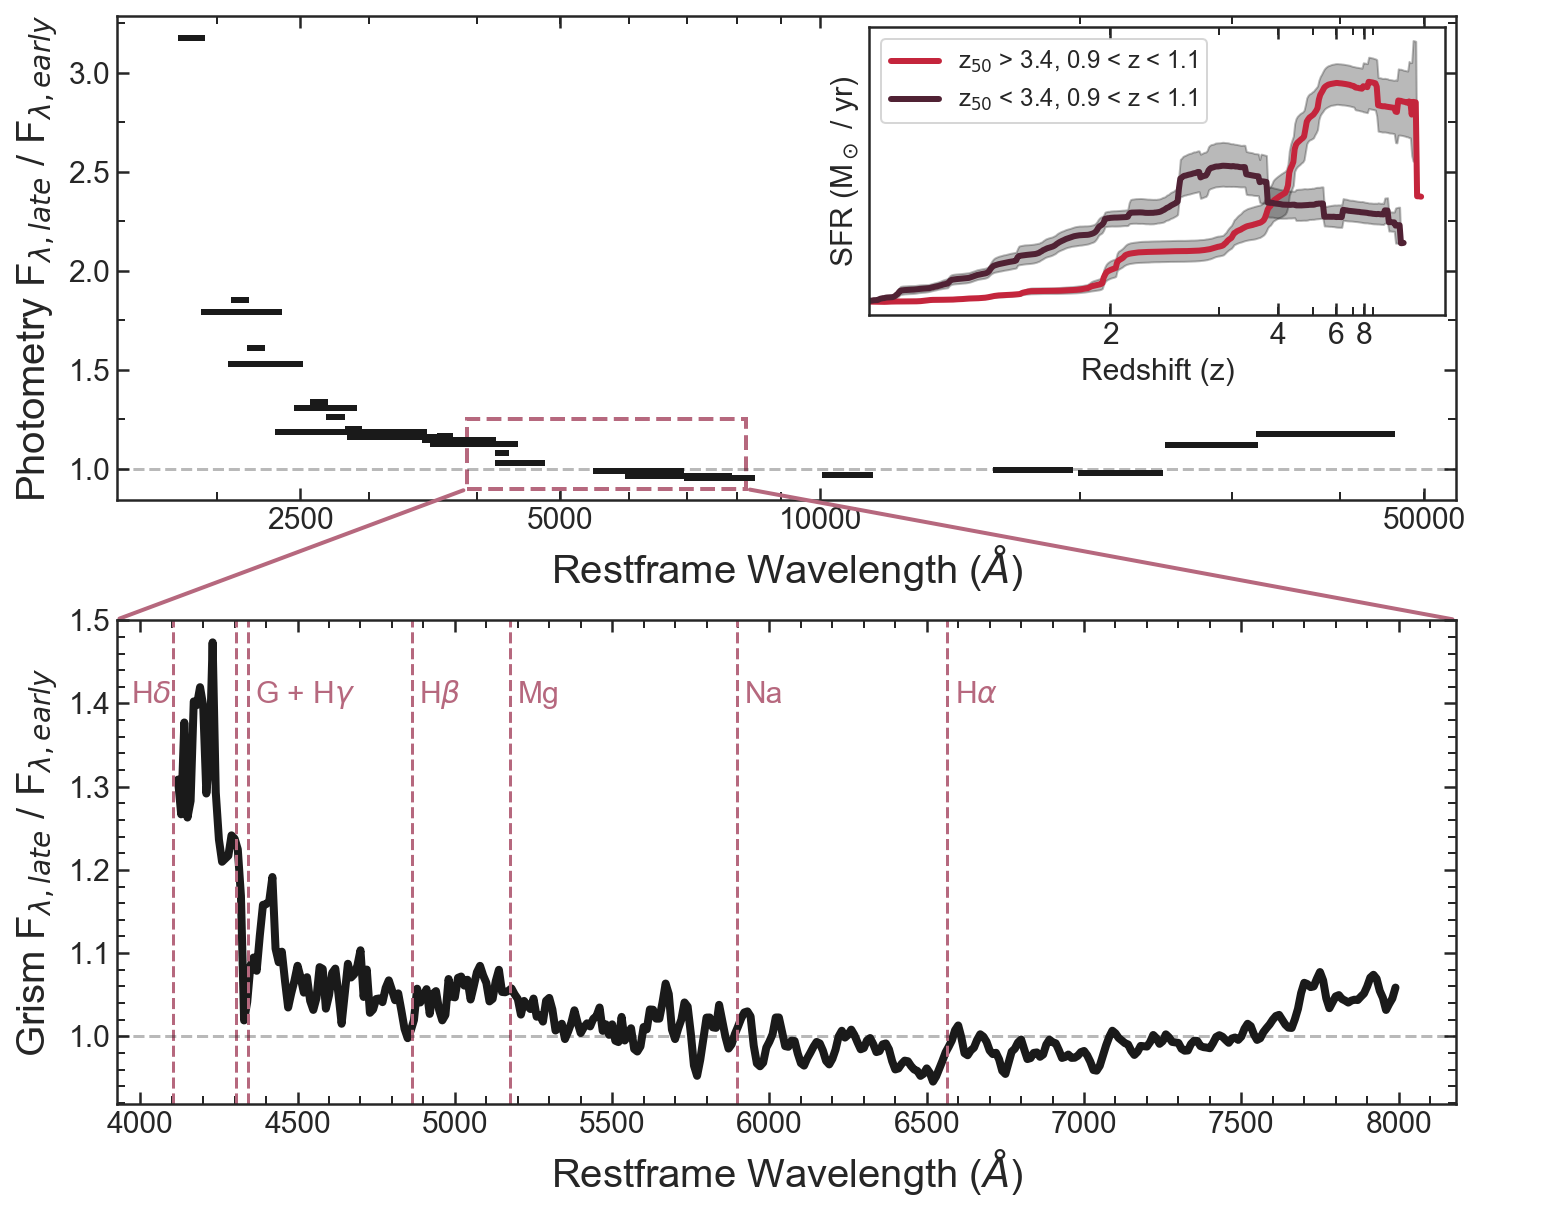

In [166]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from matplotlib.ticker import AutoMinorLocator


gs = gridspec.GridSpec(2,1,hspace=0.25,wspace=0.2)

plt.figure(figsize=[12,10])


ax1=plt.subplot(gs[0])

# plt.plot(10**phot_wv,phot_ratio, 'k',linewidth = 4, alpha = 0.2)
plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)
ax1.set_xticks([2000,3000,3500,4000,4500,6000,7000,8000,9000,20000,30000,40000], minor = True)
ax1.set_yticks([1.25,1.75,2.25,2.75,3.25], minor = True)
ipratio = interp1d(10**phot_wv,phot_ratio)

for i in range(len(Pnum)):
    for ii in range(len(MDF)):
        if Pnum[i] == MDF.tmp_num[MDF.index[ii]]:
#             print(MDF.eff_wv[MDF.index[ii]],FWHM(ii))
            try:
                plt.errorbar(MDF.eff_wv[MDF.index[ii]] / 2, ipratio(MDF.eff_wv[MDF.index[ii]] / 2),
                             xerr = FWHM(ii)/2, color='k', elinewidth=3)
            except:
                pass

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Photometry F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xscale('log')
plt.xticks([2500,5000,10000,50000],[2500,5000,10000,50000])

ax2 = plt.subplot(gs[1])
plt.plot(grism_wv,grism_ratio, 'k',linewidth = 4)
plt.axvline(4102.89 ,linestyle='--', color = '#B6687E')
plt.axvline(4305.61 ,linestyle='--', color = '#B6687E')
plt.axvline(4341.68 ,linestyle='--', color = '#B6687E')
plt.axvline(4862.68 ,linestyle='--', color = '#B6687E')
plt.axvline(5176.7,linestyle='--', color = '#B6687E')
plt.axvline(5895.6,linestyle='--', color = '#B6687E')
plt.axvline(6564.61,linestyle='--', color = '#B6687E')

ax2.text(3970, 1.4, 'H$\delta$' , color = '#B6687E', fontsize=15)
plt.text(4365, 1.4, 'G + H$\gamma$' , color = '#B6687E', fontsize=15)
plt.text(4885, 1.4, 'H$\\beta$' , color = '#B6687E', fontsize=15)
plt.text(5200, 1.4, 'Mg' , color = '#B6687E', fontsize=15)
plt.text(5920, 1.4, 'Na', color = '#B6687E', fontsize=15)
plt.text(6590, 1.4, 'H$\\alpha$' , color = '#B6687E', fontsize=15)

plt.xlabel('Restframe Wavelength ($\AA$)', fontsize=20)
plt.ylabel('Grism F$_{\lambda, late}$ / F$_{\lambda, early}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.axhline(1, linestyle = '--', color = 'k', alpha = 0.3)
plt.minorticks_on()

axins = inset_axes(ax1, width=4, height=2)

zoomingBox(ax1, [3900,8200,0.9,1.25], ax2)


plt.plot(LBT2,SFH2 / np.trapz(SFH2 ,LBT2), '#C4253C', linewidth = 3,label = 'z$_{50}$ > 3.4, 0.9 < z < 1.1')
plt.fill_between(LBT2, S216 / np.trapz(SFH2 ,LBT2), S284 / np.trapz(SFH2 ,LBT2), color = 'k', alpha = 0.3)


plt.plot(LBT1,SFH1 / np.trapz(SFH1 ,LBT1), '#502234', linewidth = 3,label = 'z$_{50}$ < 3.4, 0.9 < z < 1.1')
plt.fill_between(LBT1, S116 / np.trapz(SFH1 ,LBT1), S184 / np.trapz(SFH1 ,LBT1), color = 'k', alpha = 0.3)

plt.xticks(cosmo.lookback_time([1,2,4,6,8]).value,[1,2,4,6,8])
axins.set_xticks(cosmo.lookback_time([1,2,3,4,5,6,7,8,9]).value, minor = True)

plt.xlim(8,14)
plt.yticks([])
# plt.minorticks_on()

plt.xlabel('Redshift (z)', fontsize=15)
plt.ylabel('SFR (M$_\odot$ / yr)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize=12)
plt.savefig('../plots/SFH_summary.pdf', bbox_inches = 'tight')

In [154]:
from matplotlib.patches import Rectangle

def zoomingBox(ax1, roi, ax2, color='#B6687E', linewidth=2):
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2],**dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)]) ))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    print(dstCorners[0])
    
    dstCorners[0] = [0.075, 0.125]
    dstCorners[1] = [0.075, 0.488]
    dstCorners[2] = [0.90, 0.125]
    dstCorners[3] = [0.944, 0.488]
    
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', 
                     arrowprops=dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)]))

In [155]:
bfilters = [34, 36, 37, 58, 117, 118, 195, 196, 220, 224]

MDF = pd.read_pickle('../phot/model_photometry_list.pkl')
SWV, TR = np.load('../templates/master_tmp.npy')
W, F, E, Pnum = np.load('../phot/GSD_39170_phot.npy')
     
WRF = W / (1 + 1)

IDX = []

for i in range(len(Pnum)):
    if Pnum[i] not in bfilters and F[i] / E[i] > 0.5:
        IDX.append(i)

W, WRF, F, E, Pnum = W[IDX], WRF[IDX], F[IDX], E[IDX], Pnum[IDX]

W, WRF, F, E, Pnum = W[F > 0], WRF[F > 0], F[F > 0], E[F > 0], Pnum[F > 0]
        
IDP = []
for i in range(len(Pnum)):
    for ii in range(len(MDF)):
        if Pnum[i] == MDF.tmp_num[MDF.index[ii]]:
            IDP.append(ii)

In [156]:
def FWHM(idx):
    flip = 0
    for i in range(len(SWV[idx])):
        if flip == 0 and TR[idx][i]-0.5 > 0:
            llim = SWV[idx][i]
            flip = 1

        if flip == 1 and TR[idx][i]-0.5 < 0:
            hlim = SWV[idx][i]
            flip = 0
    return (hlim - llim)/2

1) observed at redshift 1

2) late former, z_50 = 2.5, age = 3.54

3) early former, z_50 = 4.5, age = 4.83

In [12]:
sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 4, tau = 0.5, dust_type = 1)

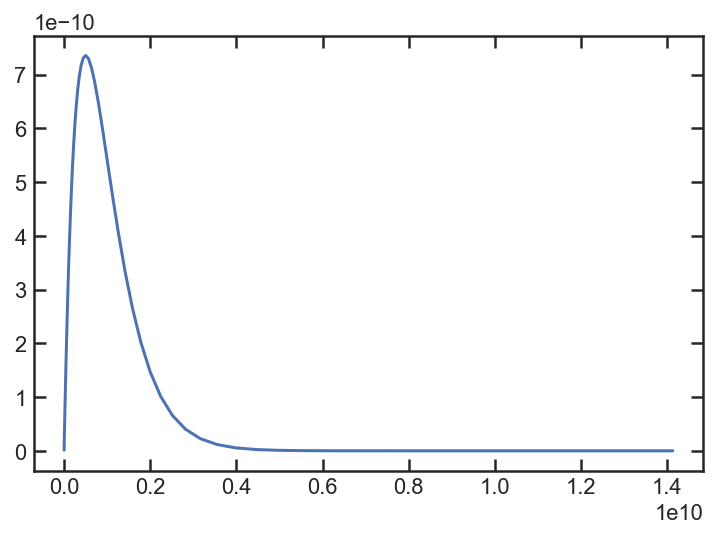

In [244]:
plt.plot(10**sp.log_age, sp.sfr)

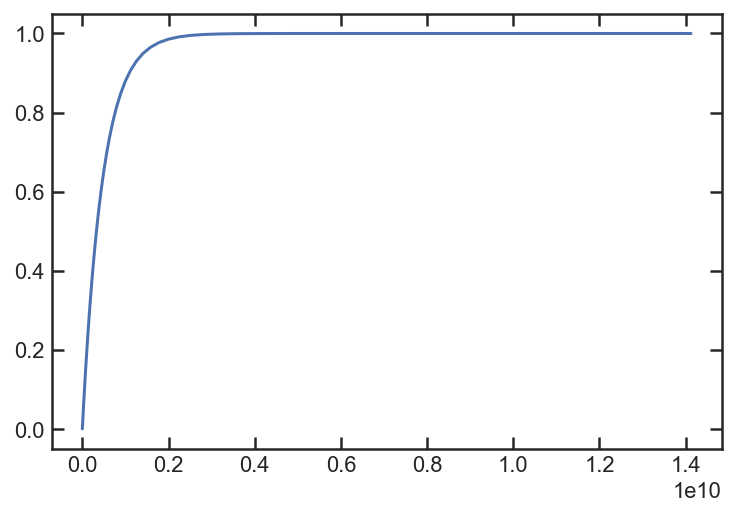

In [245]:
plt.plot(10**sp.log_age, np.cumsum(sp.sfr) /np.cumsum(sp.sfr)[-1] )

In [246]:
interp1d(np.cumsum(sp.sfr) /np.cumsum(sp.sfr)[-1],10**sp.log_age)(0.5)

array(3.27851758e+08)

In [280]:
0.3, cosmo.age(0.98) - cosmo.age(2.68), cosmo.age(1.02) - cosmo.age(4.43)

(0.3, <Quantity 3.51361217 Gyr>, <Quantity 4.42027352 Gyr>)

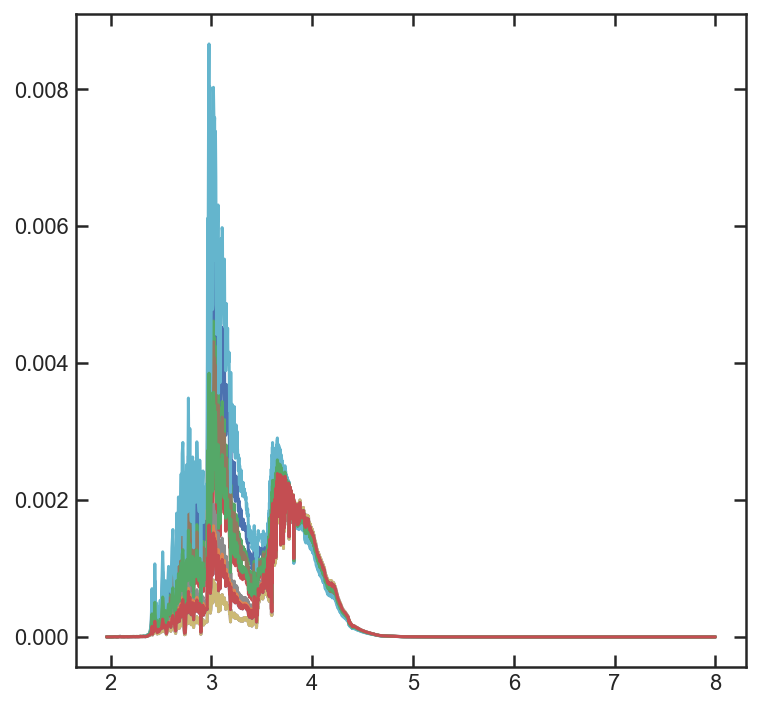

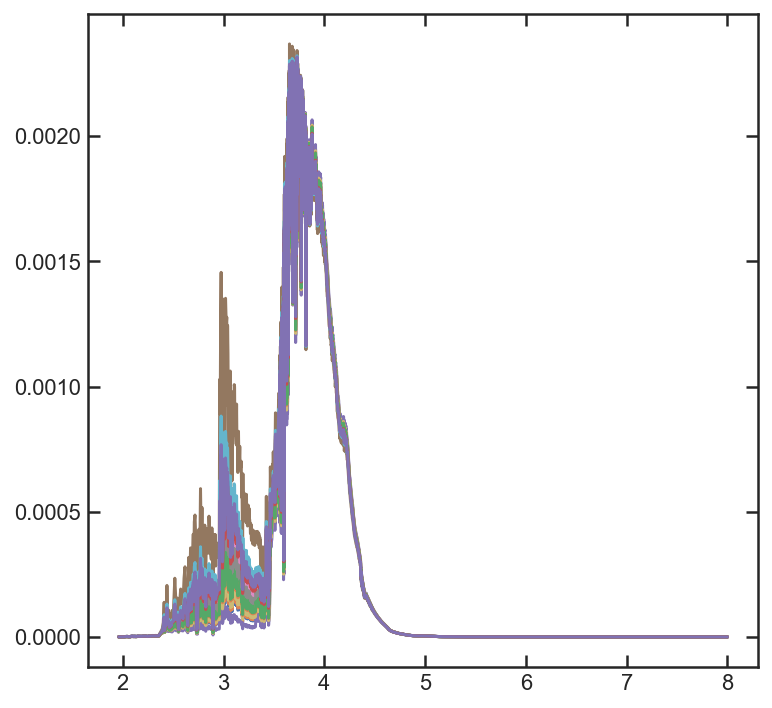

In [406]:
fl_late = np.zeros_like(wv)
plt.figure(figsize=[6,6])
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 < 3.4').index:
    wv,fl = sp.get_spectrum(tage=cosmo.age(mdb.zgrism[i]).value - cosmo.age(mdb.z_50[i]).value + 0.3, peraa=True)
    
    IDX = [U for U in range(len(wv)) if 6000 < wv[U] < 6500]
    Nfact = np.trapz(fl[IDX],wv[IDX])
    fl_late += fl/Nfact
    plt.plot(np.log10(wv),fl/Nfact)
    
fl_early = np.zeros_like(wv)
plt.figure(figsize=[6,6])
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').index:
    wv,fl = sp.get_spectrum(tage=cosmo.age(mdb.zgrism[i]).value - cosmo.age(mdb.z_50[i]).value + 0.3, peraa=True)
    
    IDX = [U for U in range(len(wv)) if 6000 < wv[U] < 6500]
    Nfact = np.trapz(fl[IDX],wv[IDX])
    fl_early += fl/Nfact
    plt.plot(np.log10(wv),fl/Nfact)

(0.85, 1.35)

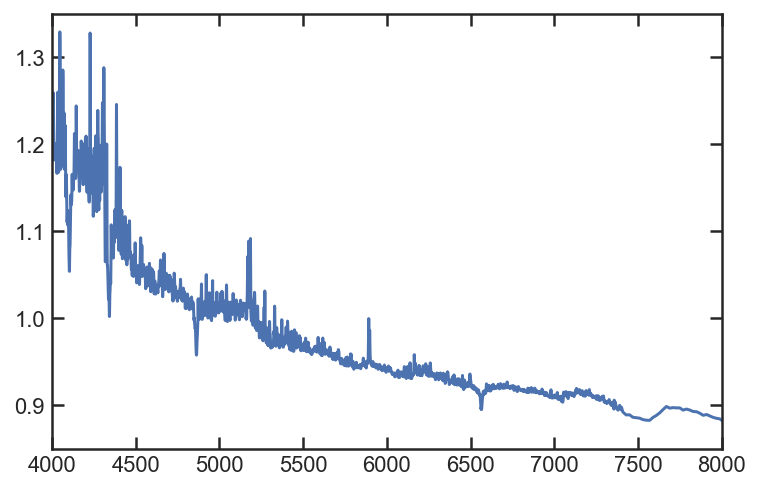

In [415]:
plt.plot(wv,fl_late / fl_early)
plt.xlim(4000,8000)
plt.ylim(0.85,1.35)

In [13]:
wv1,fl1 = sp.get_spectrum(tage=3.81, peraa=True)
wv2,fl2 = sp.get_spectrum(tage=4.72, peraa=True)

(1.3, 1.8)

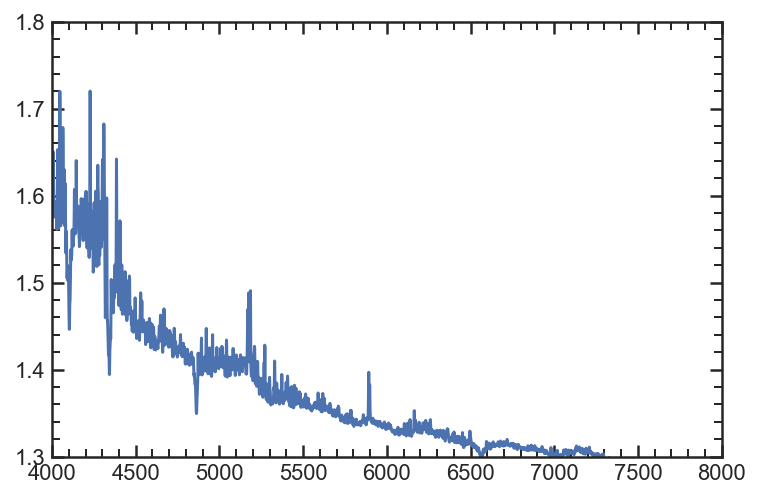

In [14]:
plt.plot(wv1,fl1/fl2)
# plt.plot(wv2,fl2)
# plt.xscale('log')
plt.xlim(4000,8000)
plt.ylim(1.3,1.8)

In [15]:
np.median(mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').zgrism)

1.0206983360885422

In [16]:
Gs = Gen_spec('GND', 17070, 1.023, phot_errterm = 0.04, irac_err = 0.08,g102_lims=[8300, 11400], g141_lims=[11200, 16500]) 


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [17]:
Gs.Full_forward_model(wv1,fl1,1.023)
Bmfl1 = Gs.Bmfl
Rmfl1 = Gs.Rmfl

Gs.Full_forward_model(wv2,fl2,1.023)
Bmfl2 = Gs.Bmfl
Rmfl2 = Gs.Rmfl

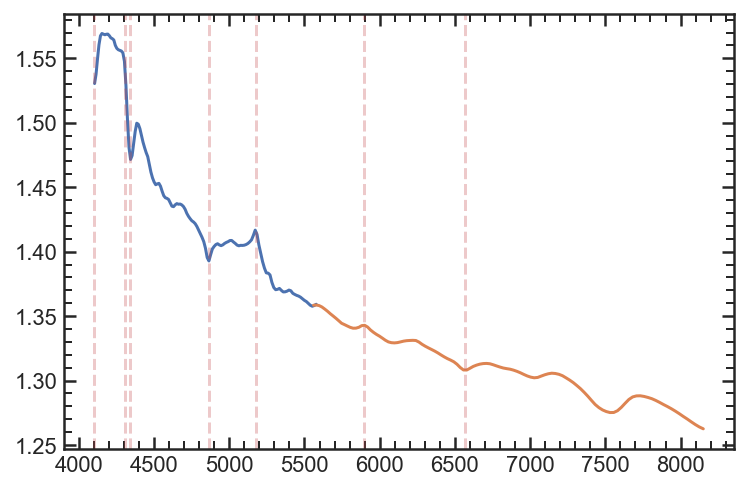

In [18]:
plt.plot(Gs.Bwv_rf,Bmfl1/Bmfl2)
plt.plot(Gs.Rwv_rf,Rmfl1/Rmfl2)
plt.axvline(4102.89 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4305.61 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4341.68 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(4862.68 ,linestyle='--', alpha=.3, color = 'r')
plt.axvline(5176.7,linestyle='--', alpha=.3, color = 'r')
plt.axvline(5895.6,linestyle='--', alpha=.3, color = 'r')
plt.axvline(6564.61,linestyle='--', alpha=.3, color = 'r')

# plt.plot(Gs.Bwv_rf,Bmfl2)

# Figure 3

In [326]:
eazy_GSD = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
eazy_GND = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits', format = 'fits').to_pandas()
fast_GSD = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout', format = 'ascii').to_pandas()
fast_GND = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout', format = 'ascii').to_pandas()
ez_3d_GSD = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.zout', format = 'ascii').to_pandas()
ez_3d_GND = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.zout', format = 'ascii').to_pandas()

Text(0,0.5,'FAST lmass')

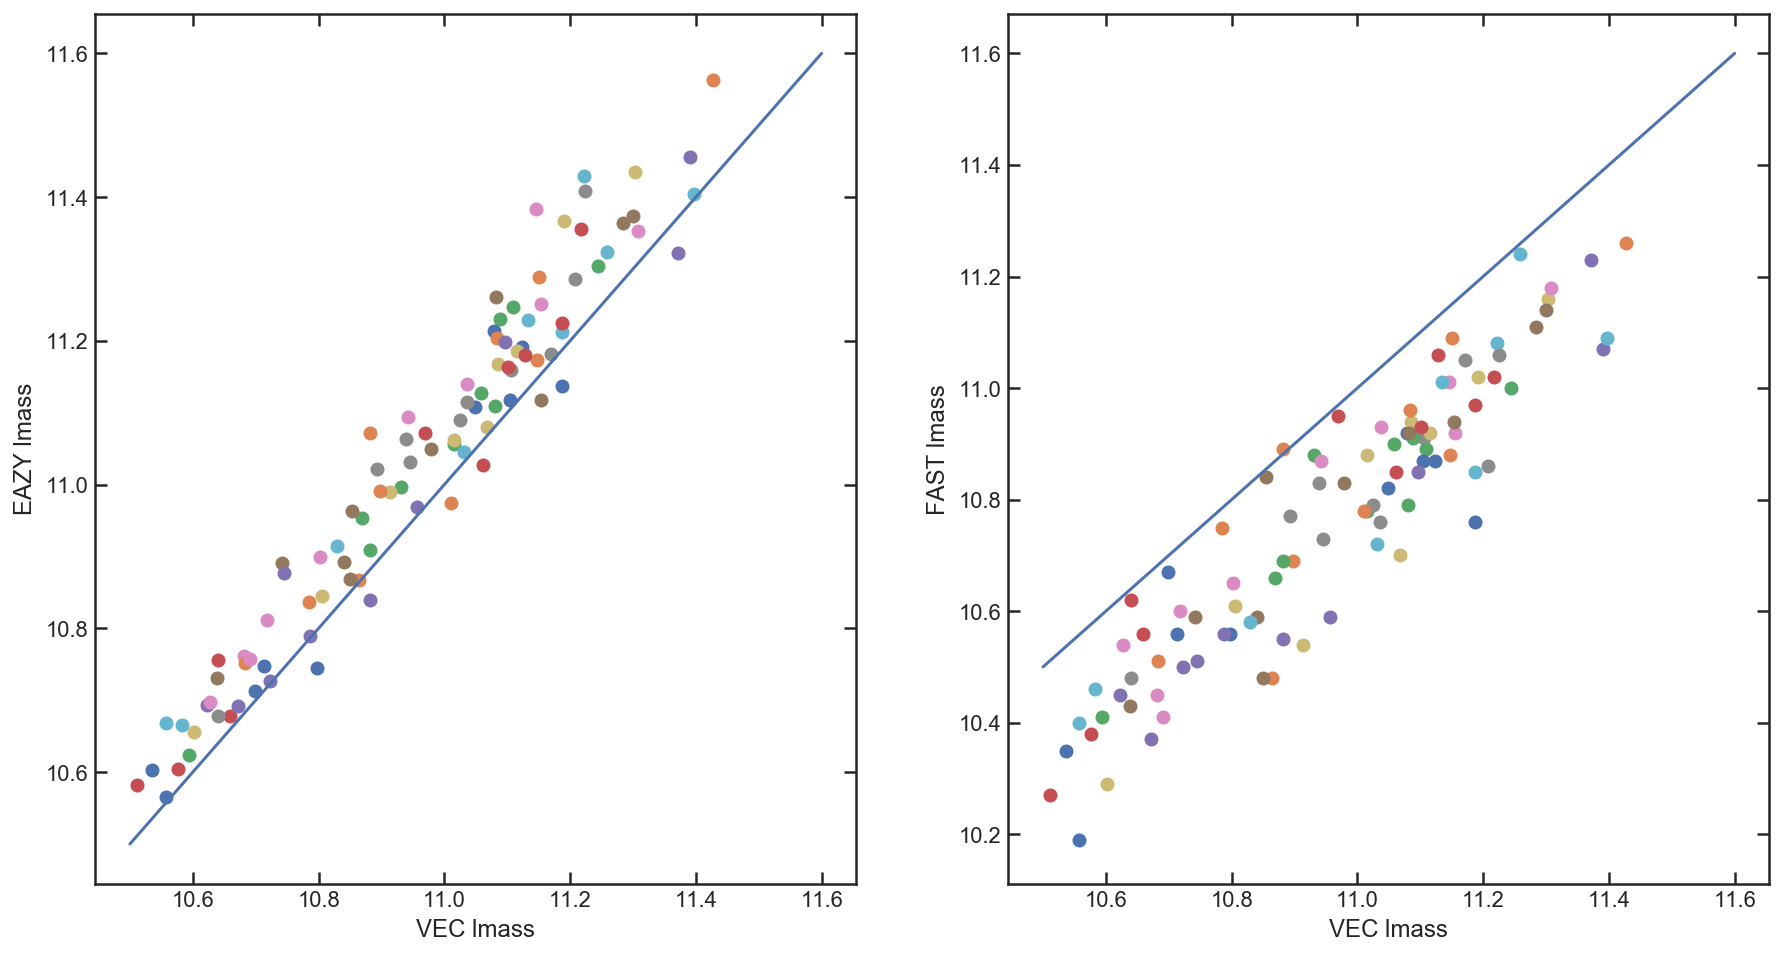

In [324]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezmass = np.log10(eazy_GSD.query('id == {}'.format(mdb.id[i])).mass.values[0])
        fsmass = fast_GSD.query('id == {}'.format(mdb.id[i])).lmass.values[0]
    else:
        ezmass = np.log10(eazy_GND.query('id == {}'.format(mdb.id[i])).mass.values[0])
        fsmass = fast_GND.query('id == {}'.format(mdb.id[i])).lmass.values[0]
        
    ax1.scatter(mdb.lmass[i], ezmass)
    ax2.scatter(mdb.lmass[i], fsmass)

ax1.plot([10.5,11.6],[10.5,11.6])
ax2.plot([10.5,11.6],[10.5,11.6])

ax1.set_xlabel('VEC lmass')
ax2.set_xlabel('VEC lmass')

ax1.set_ylabel('EAZY lmass')
ax2.set_ylabel('FAST lmass')

Text(0,0.5,'3D-HST redshift')

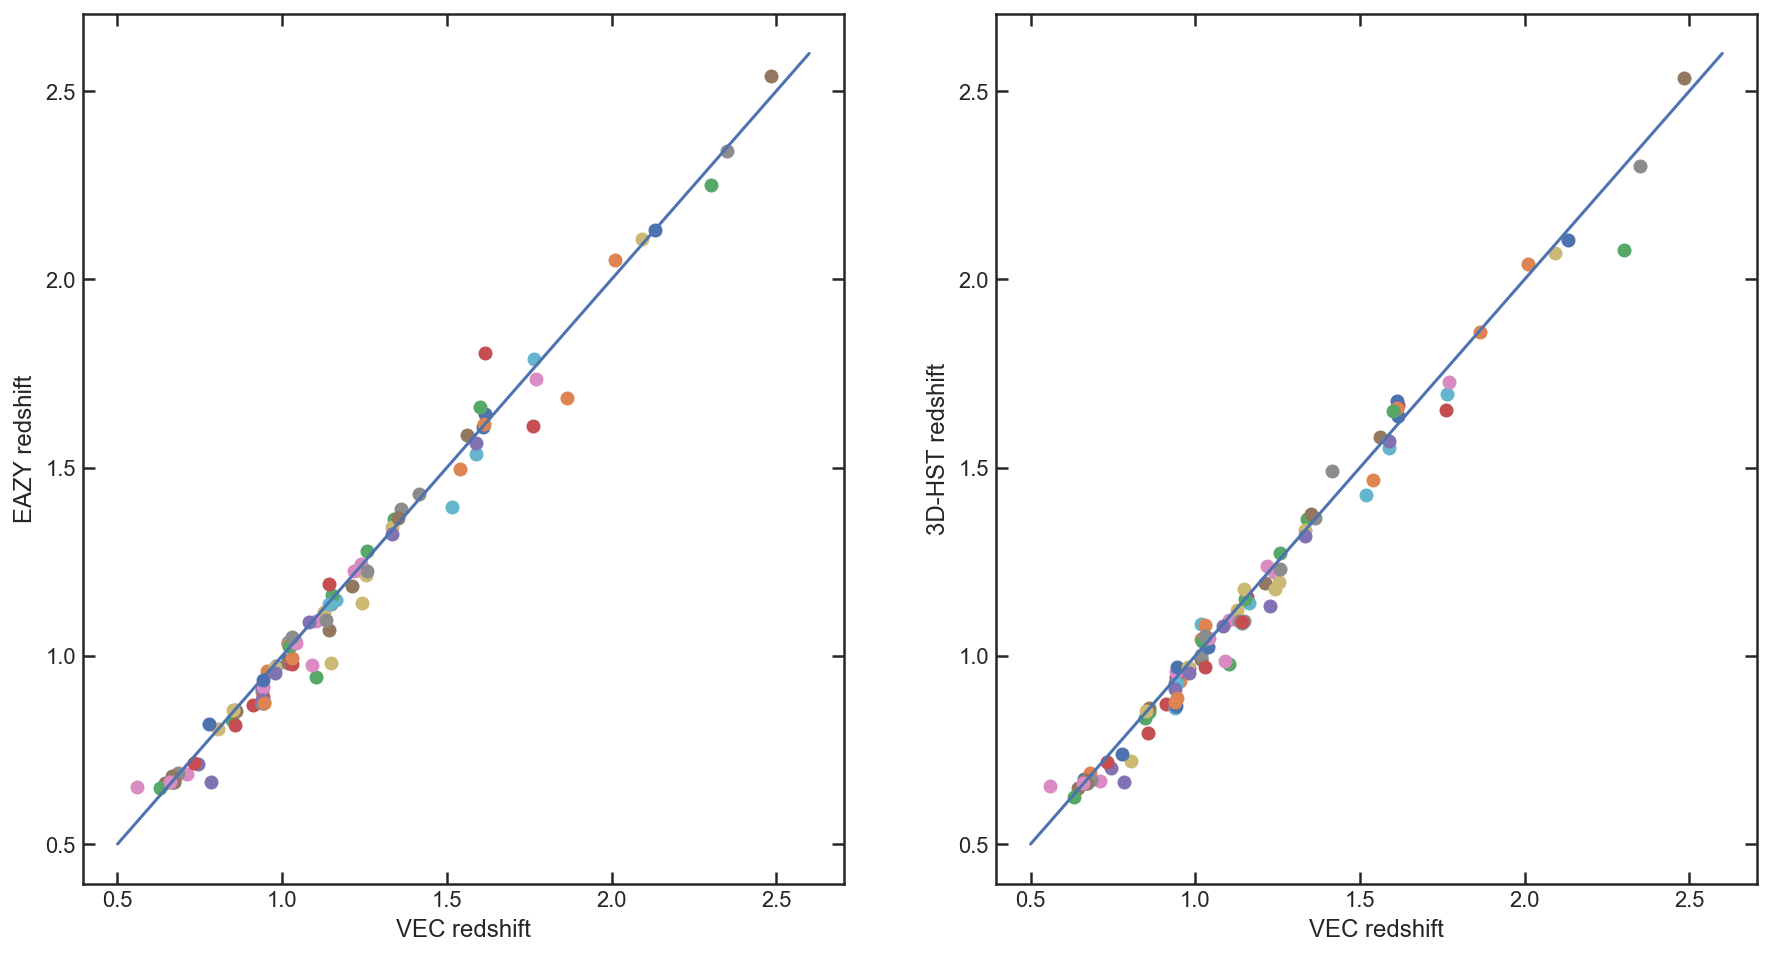

In [327]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[15,8])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for i in mdb.index:
    if mdb.field[i] == 'GSD':
        ezrshift = eazy_GSD.query('id == {}'.format(mdb.id[i])).z500.values[0]
        fsrshift = ez_3d_GSD.query('id == {}'.format(mdb.id[i])).z_peak.values[0]
    else:
        ezrshift = eazy_GND.query('id == {}'.format(mdb.id[i])).z500.values[0]
        fsrshift = ez_3d_GND.query('id == {}'.format(mdb.id[i])).z_peak.values[0]
        
    ax1.scatter(mdb.zgrism[i], ezrshift)
    ax2.scatter(mdb.zgrism[i], fsrshift)

ax1.plot([0.5,2.6],[0.5,2.6])
ax2.plot([0.5,2.6],[0.5,2.6])

ax1.set_xlabel('VEC redshift')
ax2.set_xlabel('VEC redshift')

ax1.set_ylabel('EAZY redshift')
ax2.set_ylabel('3D-HST redshift')

In [82]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

v4N['fIRAC1'] = v4Ncat['f_IRAC1']
v4S['fIRAC1'] = v4Scat['f_IRAC1']

v4N['fIRAC2'] = v4Ncat['f_IRAC2']
v4S['fIRAC2'] = v4Scat['f_IRAC2']

v4N['fIRAC3'] = v4Ncat['f_IRAC3']
v4S['fIRAC3'] = v4Scat['f_IRAC3']

v4N['fIRAC4'] = v4Ncat['f_IRAC4']
v4S['fIRAC4'] = v4Scat['f_IRAC4']

In [83]:
clear_S_ids = []
S_fields = ['ERSPRIME', 'GS1', 'GS2', 'GS3', 'GS4', 'GS5']

for i in range(len(S_fields)):
    ln_cat = '/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{}_lines_grizli.fits'.format(S_fields[i])
    cat = Table.read(fits.open(ln_cat)).to_pandas()
    clear_S_ids = np.append(clear_S_ids,cat.ID.values)
    
    
clear_N_ids = []
N_fields = ['GN1', 'GN2', 'GN3', 'GN4', 'GN5', 'GN7']

for i in range(len(N_fields)):
    ln_cat = '/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{}_lines_grizli.fits'.format(N_fields[i])
    cat = Table.read(fits.open(ln_cat)).to_pandas()
    clear_N_ids = np.append(clear_N_ids,cat.ID.values)

In [84]:
CNDB = pd.DataFrame({'id' : np.array(clear_N_ids).astype(int)})
CSDB = pd.DataFrame({'id' : np.array(clear_S_ids).astype(int)})

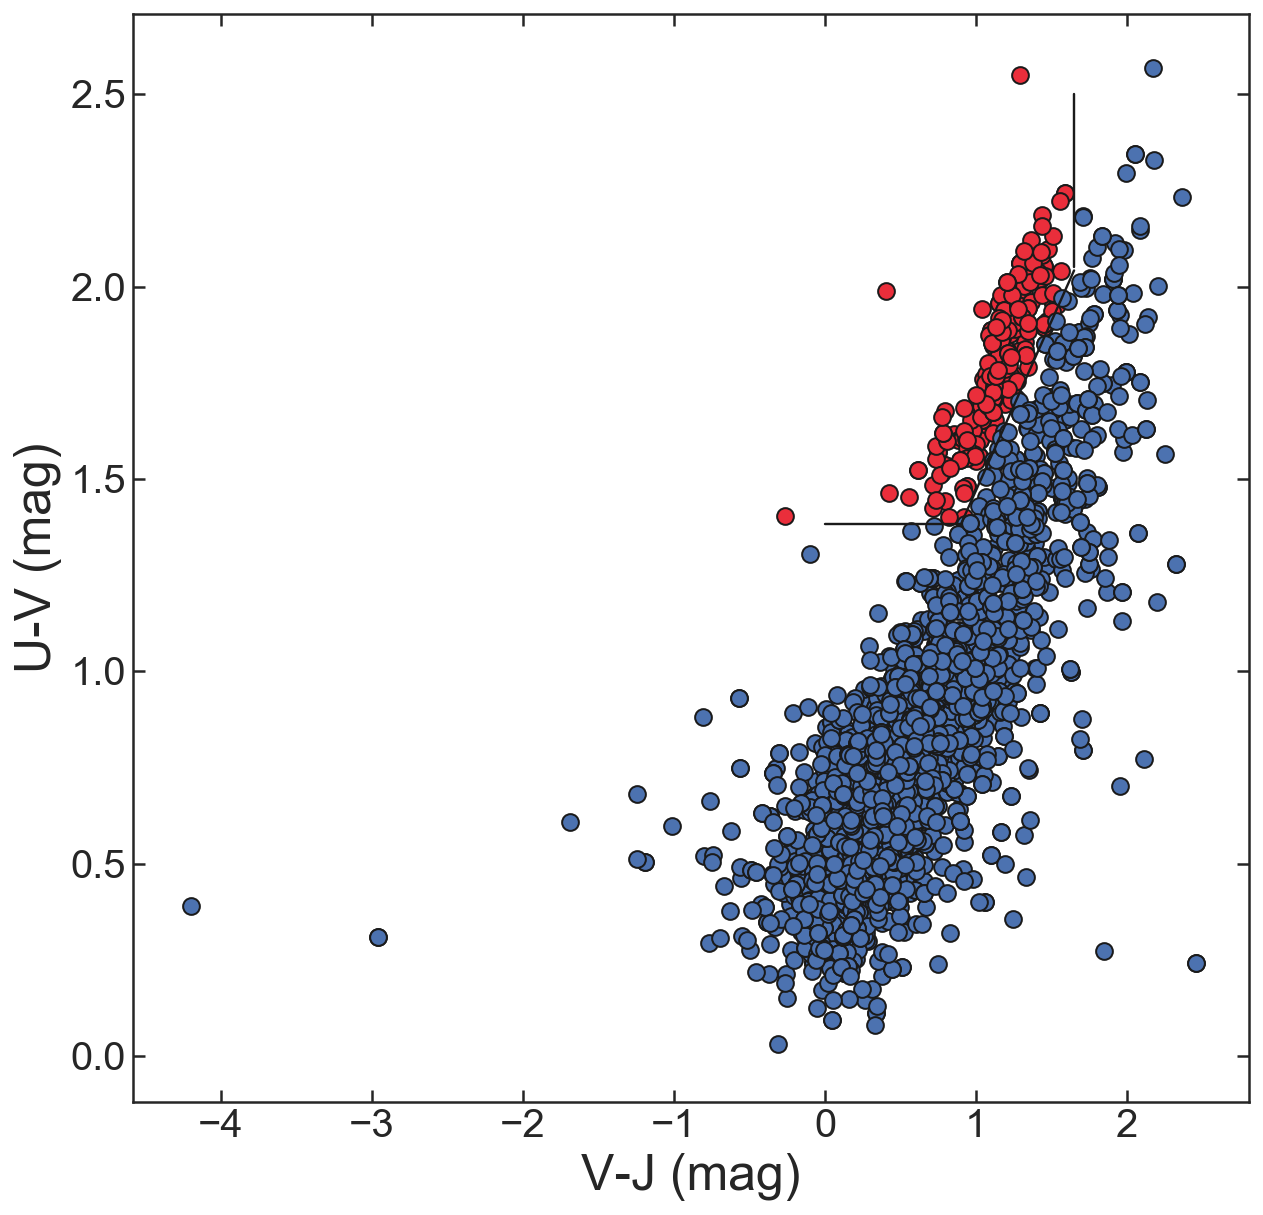

In [85]:
v4N_samp = pd.merge(v4N, CNDB, on=['id'], how='inner')
v4S_samp = pd.merge(v4S, CSDB, on=['id'], how='inner')

# v4N_samp = v4N_samp.query('use == 1 and star < 0.8 and 1 < z500 < 2 ')
# v4S_samp = v4S_samp.query('use == 1 and star < 0.8 and 1 < z500 < 2 ')

v4N_samp = v4N_samp.query('use == 1 and star < 0.8 and 0.8 < z500 < 2.5 ')
v4S_samp = v4S_samp.query('use == 1 and star < 0.8 and 0.8 < z500 < 2.5 ')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV_s = Color(v4N_samp.restU, v4N_samp.restV)
NVJ_s = Color(v4N_samp.restV, v4N_samp.restJ)
SUV_s = Color(v4S_samp.restU, v4S_samp.restV)
SVJ_s = Color(v4S_samp.restV, v4S_samp.restJ)

SQ_s = []
NQ_s = []
Ssf_s = []
Nsf_s = []
Ssf_f = []
Nsf_f = []
for i in NUV_s.index:
    if NUV_s[i]>=0.88*NVJ_s[i]+0.59 and NUV_s[i]>1.382 and NVJ_s[i]<1.65:
        NQ_s.append(i)
        Nsf_f.append(0)
    else:
        Nsf_s.append(i)
        Nsf_f.append(1)
    
for i in SUV_s.index:
    if SUV_s[i]>=0.88*SVJ_s[i]+0.59 and SUV_s[i]>1.382 and SVJ_s[i]<1.65 and i != 48719: 
        SQ_s.append(i)
        Ssf_f.append(0)
    else:
        Ssf_s.append(i)
        Ssf_f.append(1)
        
v4N_samp['sf_flag'] = Nsf_f
v4S_samp['sf_flag'] = Ssf_f
        
plt.figure(figsize=[10,10])

plt.scatter(SVJ_s[SQ_s], SUV_s[SQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[NQ_s], NUV_s[NQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')

plt.scatter(SVJ_s[Ssf_s], SUV_s[Ssf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[Nsf_s], NUV_s[Nsf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')


plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
# plt.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

In [86]:
if hpath.split('/')[-2][-1] == 'a':
    goodss_125 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    
else:
    goodss_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()

In [87]:
goodss_125['id'] = goodss_125['NUMBER'].values
goodsn_125['id'] = goodsn_125['NUMBER'].values
goodss_160['id'] = goodss_160['NUMBER'].values
goodsn_160['id'] = goodsn_160['NUMBER'].values

In [88]:
v4N_samp = pd.merge(v4N_samp.query('sf_flag > 0'), goodsn_125, on=['id'], how='inner')
v4N_samp = pd.merge(v4N_samp, goodsn_160, on=['id'], how='inner')

v4S_samp = pd.merge(v4S_samp.query('sf_flag > 0'), goodss_125, on=['id'], how='inner')
v4S_samp = pd.merge(v4S_samp, goodss_160, on=['id'], how='inner')

In [91]:
reff = []
lmass = []
r=v4N_samp.query('z500 <= 1.5').re_x.values
q=v4N_samp.query('z500 <= 1.5').q_x.values
z=v4N_samp.query('z500 <= 1.5').z500.values
m=v4N_samp.query('z500 <= 1.5').mass.values

# reff = np.append(reff,(r * np.sqrt(q)) / cosmo.arcsec_per_kpc_proper(z).value)
reff = np.append(reff,r/ cosmo.arcsec_per_kpc_proper(z).value)

lmass = np.append(lmass,np.log10(m))

r=v4N_samp.query('z500 >= 1.5').re_y.values
q=v4N_samp.query('z500 >= 1.5').q_x.values
z=v4N_samp.query('z500 >= 1.5').z500.values
m=v4N_samp.query('z500 >= 1.5').mass.values

# reff = np.append(reff,(r * np.sqrt(q)) / cosmo.arcsec_per_kpc_proper(z).value)
reff = np.append(reff,r/ cosmo.arcsec_per_kpc_proper(z).value)

lmass = np.append(lmass,np.log10(m))

r=v4S_samp.query('z500 <= 1.5').re_x.values
q=v4S_samp.query('z500 <= 1.5').q_x.values
z=v4S_samp.query('z500 <= 1.5').z500.values
m=v4S_samp.query('z500 <= 1.5').mass.values

# reff = np.append(reff,(r * np.sqrt(q)) / cosmo.arcsec_per_kpc_proper(z).value)
reff = np.append(reff,r/ cosmo.arcsec_per_kpc_proper(z).value)

lmass = np.append(lmass,np.log10(m))

r=v4S_samp.query('z500 <= 1.5').re_y.values
q=v4S_samp.query('z500 <= 1.5').q_x.values
z=v4S_samp.query('z500 <= 1.5').z500.values
m=v4S_samp.query('z500 <= 1.5').mass.values

# reff = np.append(reff,(r * np.sqrt(q)) / cosmo.arcsec_per_kpc_proper(z).value)
reff = np.append(reff,r/ cosmo.arcsec_per_kpc_proper(z).value)

lmass = np.append(lmass,np.log10(m))

In [92]:
lmass = lmass[reff > 0]
reff = reff[reff > 0]

reff = reff[lmass > 10]
lmass = lmass[lmass > 10]

([<matplotlib.axis.YTick at 0x1a765aea20>,
 <a list of 3 Text yticklabel objects>)

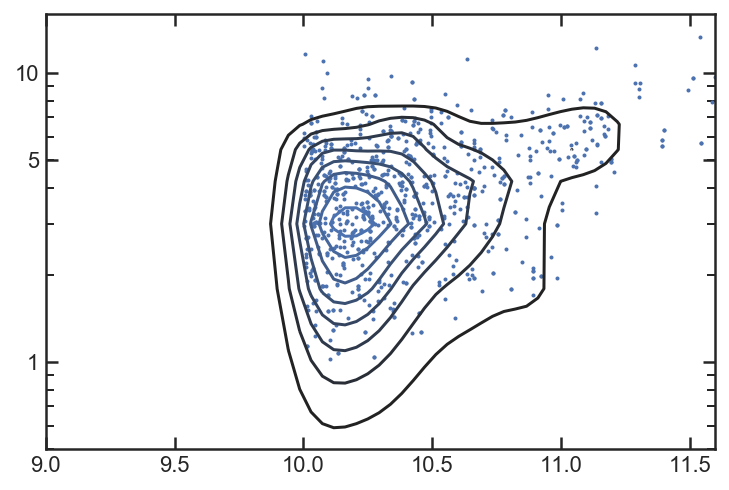

In [93]:
sea.kdeplot(lmass[reff**2>0],reff[reff**2>0], kernel='epa', gridsize=50)
plt.scatter(lmass[reff**2>0],reff[reff**2>0], s=1)
plt.xlim(9,11.6)
plt.ylim(0.5,16)   
plt.yscale('log')
plt.yticks([1,5,10],[1,5,10], zorder =1)

In [309]:
r=v4N_samp.query('z500 <= 1.5').re_x.values

r=v4N_samp.query('z500 >= 1.5').re_y.values

RE = []
RE_sig = []
for i in mdb.index:
    if mdb.zgrism[i] <= 1.5 and mdb.field[i] == 'GSD':
        RE.append(goodss_125.query('id == {}'.format(mdb.id[i])).re.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        RE_sig.append(goodss_125.query('id == {}'.format(mdb.id[i])).dre.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        
    if mdb.zgrism[i] >= 1.5 and mdb.field[i] == 'GSD':
        RE.append(goodss_160.query('id == {}'.format(mdb.id[i])).re.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        RE_sig.append(goodss_160.query('id == {}'.format(mdb.id[i])).dre.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        
    if mdb.zgrism[i] <= 1.5 and mdb.field[i] == 'GND':
        RE.append(goodsn_125.query('id == {}'.format(mdb.id[i])).re.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        RE_sig.append(goodsn_125.query('id == {}'.format(mdb.id[i])).dre.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        
    if mdb.zgrism[i] >= 1.5 and mdb.field[i] == 'GND':
        RE.append(goodsn_160.query('id == {}'.format(mdb.id[i])).re.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)
        RE_sig.append(goodsn_160.query('id == {}'.format(mdb.id[i])).dre.values[0]/ cosmo.arcsec_per_kpc_proper(mdb.zgrism[i]).value)


In [310]:
lowlim = 10.4
lm_errbin = []

while lowlim < 11.6:
    lowerr = []
    hierr = []
    for i in mdb.index:
        if lowlim < mdb.lmass[i] < lowlim + 0.4:
            for ii in range(len(mdb.lmass_hci[i])//2):
                if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
                    lowerr.append(mdb.lmass_hci[i][2*ii])
                    hierr.append(mdb.lmass_hci[i][2*ii+1])
       
    lm_errbin.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    
    lowlim += 0.4
    
    
lowlim = -0.25
Re_errbin = []

while lowlim < max(np.log10(RE)):
    
    print(lowlim + 0.2)
    sig = []
    for i in range(len(RE)):
        if lowlim < np.log10(RE)[i] < lowlim + 0.4:
            sig.append(RE_sig[i])
       
    Re_errbin.append(np.median(sig))
    
    
    lowlim += 0.4

-0.04999999999999999
0.35000000000000003
0.75
1.1500000000000001


In [28]:
Re_errbin

[0.07466019046265263,
 0.06620712446556055,
 0.039271198825139055,
 0.04097293961587026]

(array([ 6.,  7., 12., 15., 26., 13.,  5.,  8.,  2.,  1.]),
 array([-0.23508481, -0.09386792,  0.04734898,  0.18856587,  0.32978276,
         0.47099966,  0.61221655,  0.75343345,  0.89465034,  1.03586723,
         1.17708413]),
 <a list of 10 Patch objects>)

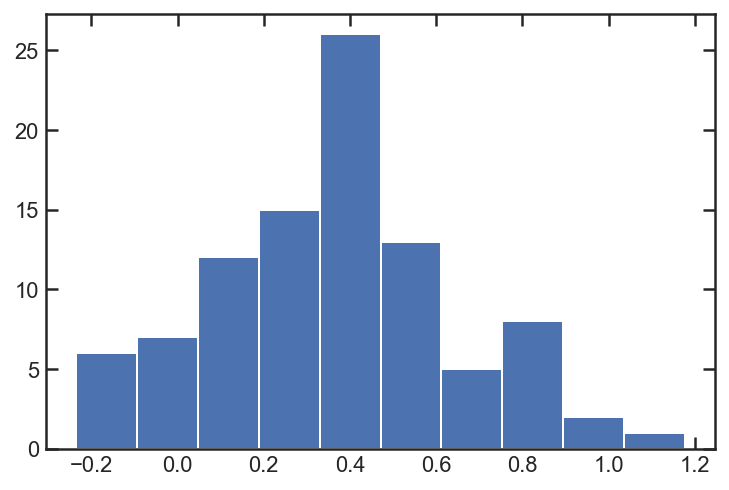

In [109]:
plt.hist(np.log10(RE))

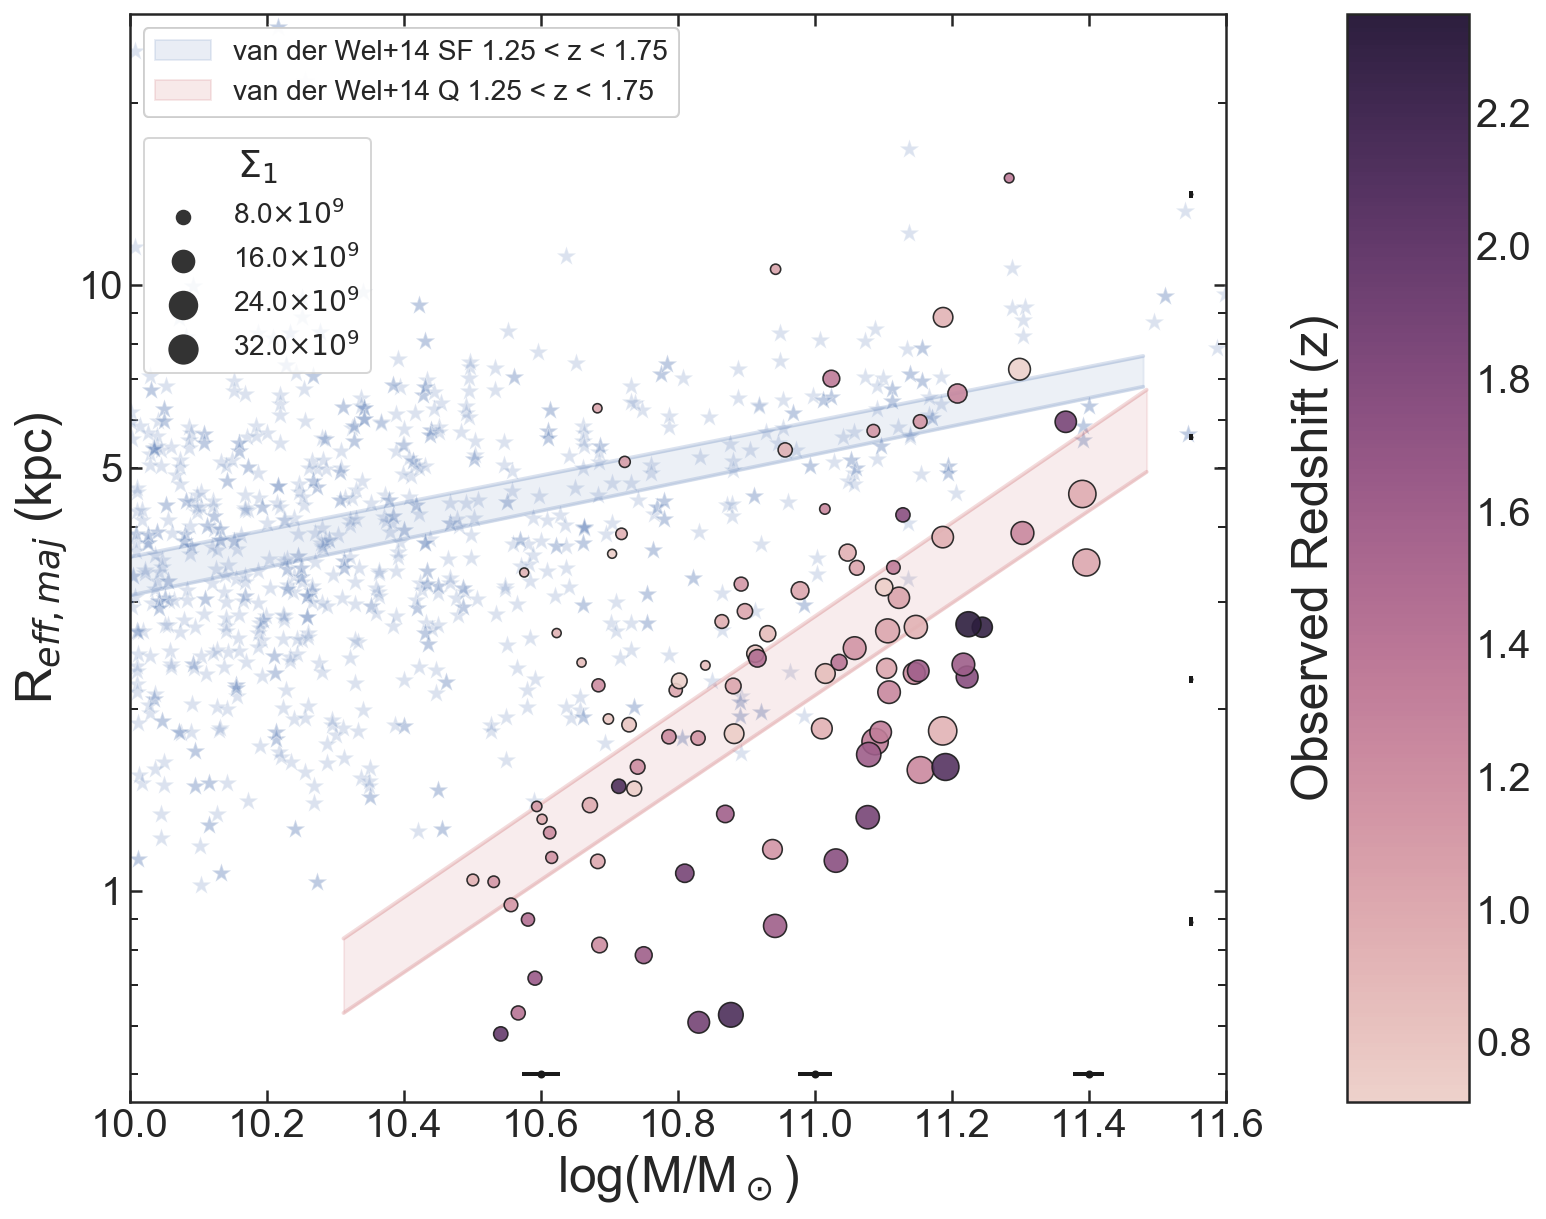

In [311]:
gs = gridspec.GridSpec(1,2,width_ratios=[9,1])
plt.figure(figsize=[12,10])
ax = plt.subplot(gs[0])
    
# g = sea.scatterplot(mdb.lmass, mdb.Re, color = '#507678',
#                 hue = mdb.zgrism, 
#                 size= mdb.Sigma1,
#                 sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9, linewidth = 0.8, edgecolor = 'k', zorder =5)

g = sea.scatterplot(mdb.lmass, RE, color = '#507678',
                hue = mdb.zgrism, 
                size= mdb.Sigma1,
                sizes=(20, 200),legend='brief', ax=ax, alpha = 0.9, linewidth = 0.8, edgecolor = 'k', zorder =5)

lml = []
lmh = []
lm = []
for i in mdb.index:
    for ii in range(len(mdb.lmass_hci[i])//2):
        if mdb.lmass_hci[i][2*ii] <= mdb.lmass[i] <= mdb.lmass_hci[i][2*ii+1]:
            lml.append(mdb.lmass[i] - mdb.lmass_hci[i][2*ii])
            lmh.append(mdb.lmass_hci[i][2*ii+1] - mdb.lmass[i])
            lm.append(mdb.lmass[i])

mass = 10**np.linspace(10.5,11.45)
handles, _ = ax.get_legend_handles_labels()
          
l3 = plt.legend(handles[7:], ['8.0$\\times 10^9$','16.0$\\times 10^9$','24.0$\\times 10^9$','32.0$\\times 10^9$'],title = '$\Sigma_1$', 
          loc = [0.0125,0.67],fontsize = 14)
ax.add_artist(l3)
ax.get_legend().get_title().set_fontsize('19')

plt.errorbar([10.6,11.0,11.4],[0.5,0.5,0.5], xerr=lm_errbin, fmt = 'o',ms=3, color = 'k', elinewidth=2)
plt.errorbar([11.55, 11.55, 11.55, 11.55],10**np.array([-0.05,0.35,0.75,1.15]), yerr=Re_errbin, fmt = 'o',ms=1, color = 'k', elinewidth=2)

sea.scatterplot(lmass[reff**2>0],reff[reff**2>0], ax=ax, legend = False, marker = '*', s=100, alpha = 0.2)

###z=1.25
# 9.52245 2.78516
# 11.47970 7.64658
# 10.31201 0.83628
# 11.48468 6.72677
###z=1.75
# 9.51905 2.37646
# 11.49048 6.82782
# 10.30952 0.62107
# 11.49048 4.94466

ib1 = interp1d([9.52245,11.47970],[2.78516,7.64658])
ib2 = interp1d([9.51905,11.49048],[2.37646,6.82782])
plt.fill_between([9.52245,11.47970], ib1([9.52245,11.47970]), ib2([9.52245,11.47970]), color = 'b', alpha = 0.1, label = 'van der Wel+14 SF 1.25<z<1.75')
plt.plot([9.52245,11.47970], ib1([9.52245,11.47970]), color = 'b', linewidth = 2, alpha = 0.2)
plt.plot([9.52245,11.47970], ib2([9.52245,11.47970]), color = 'b', linewidth = 2, alpha = 0.2)

ir1 = interp1d([10.31201 ,11.48468],[0.83628,6.72677])
ir2 = interp1d([10.30952 ,11.49048],[0.62107,4.94466])
plt.fill_between([10.31201 ,11.48468], ir1([10.31201 ,11.48468]), ir2([10.31201 ,11.48468]), color = 'r', alpha = 0.1, label = 'van der Wel+14 Q 1.25<z<1.75')
plt.plot([10.31201 ,11.48468], ir1([10.31201 ,11.48468]), color = 'r', linewidth = 2, alpha = 0.2)
plt.plot([10.31201 ,11.48468], ir2([10.31201 ,11.48468]), color = 'r', linewidth = 2, alpha = 0.2)

handles, _ = ax.get_legend_handles_labels()
l2 = plt.legend(handles[11:], [ 'van der Wel+14 SF 1.25 < z < 1.75','van der Wel+14 Q 1.25 < z < 1.75'], fontsize = 14, loc = 2)
ax.add_artist(l2)
ax.get_legend().get_title().set_fontsize('19')

plt.ylim(0.45,28)   
plt.yscale('log')
plt.yticks([1,5,10],[1,5,10], zorder =1)
plt.ylabel('R$_{eff, maj}$ (kpc)', fontsize=25)
plt.xlabel('log(M/M$_\odot$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(10,11.6)

ax2 = plt.subplot(gs[1])
cmap = sea.cubehelix_palette(8, as_cmap=True)
norm = mpl.colors.Normalize(vmin=min(mdb.zgrism), vmax = max(mdb.zgrism))
mpl.colorbar.ColorbarBase(ax2, cmap = cmap, norm=norm, orientation='vertical')
ax2.set_ylabel('Observed Redshift (z)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.yaxis.set_label_position('left')

plt.savefig('../plots/r_lm.pdf', bbox_inches = 'tight')

In [375]:
np.log10(32E9)

10.505149978319906

### Barro $\Sigma_1$

$\log \Sigma_{1kpc} - \log M_* = -\log \pi - \log \gamma(2n, b_nr_e^{-1/n})$

$ \log \gamma(2n, b_nr_e^{-1/n}) = c_0 + c_1 \log r_e + c_2(\log r_e)^2$

$n = 4; c_0 = 0.30; c_1 = 0.56; c_2 = 0.29$

$n = 3; c_0 = 0.30; c_1 = 0.63; c_2 = 0.36$

$n = 2; c_0 = 0.30; c_1 = 0.75; c_2 = 0.49$

$n = 1; c_0 = 0.31; c_1 = 0.96; c_2 = 0.75$

In [356]:
def log_gamma(n, re):
    if np.round(n)==4:
        C = [0.3, 0.56, 0.29]
    if np.round(n)==3:
        C = [0.3, 0.63, 0.36]
    if np.round(n)==2:
        C = [0.3, 0.75, 0.49]
    if np.round(n)==1:
        C = [0.31, 0.96, 0.75]
        
    return C[0] + C[1] * np.log10(re) + C[2] * np.log10(re)**2

def log_sigma1(M, n, re):
    return -np.log10(np.pi) - log_gamma(n, re) + np.log10(M)

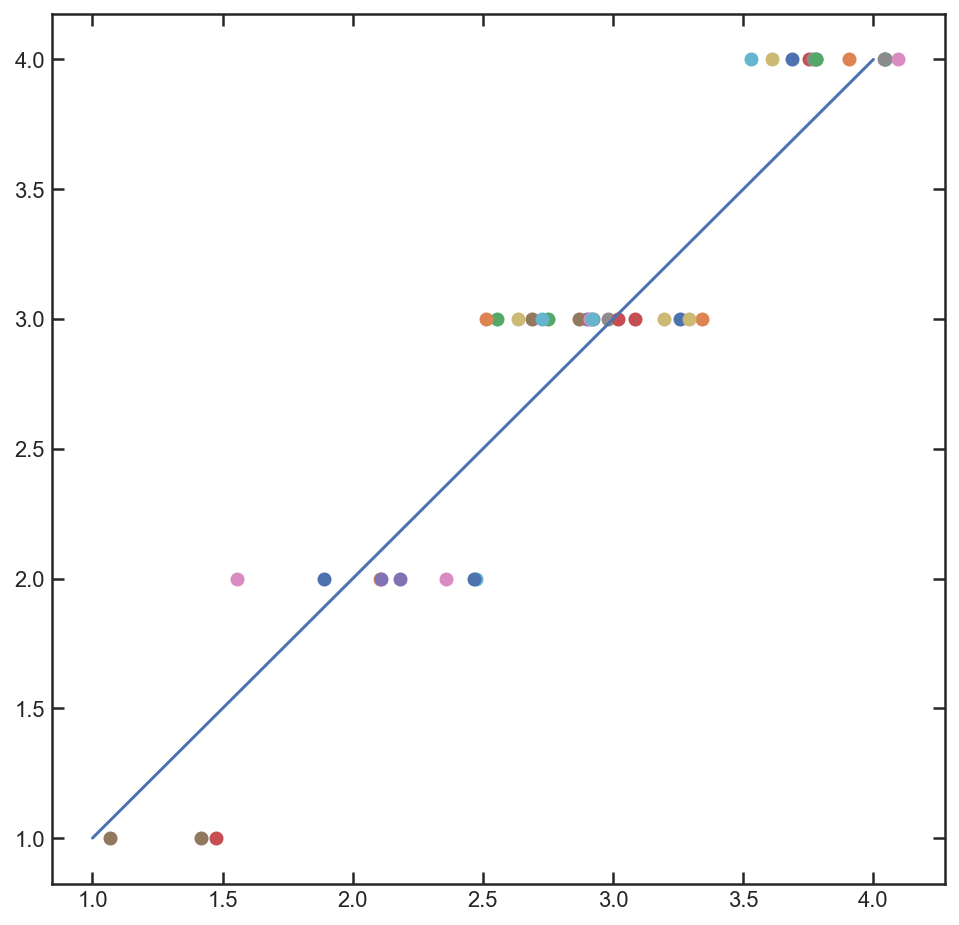

In [355]:
plt.figure(figsize=[8,8])
for i in mdb.query('n < 4.1').index:
    plt.scatter(mdb.n[i], np.round(mdb.n[i]))
plt.plot([1,4],[1,4])

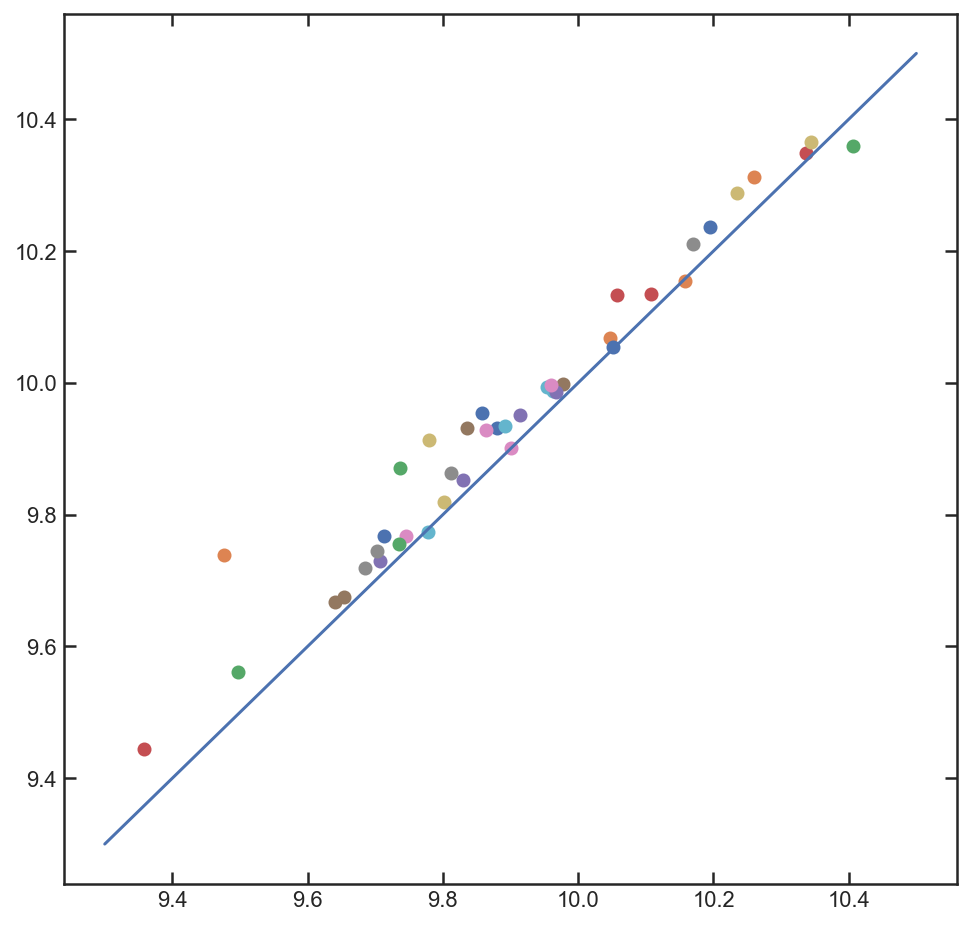

In [358]:
plt.figure(figsize=[8,8])
res = []
for i in mdb.query('n < 4.1').index:
#     print(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i]))
#     print(np.log10(mdb.Sigma1[i]))
    
    plt.scatter(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i]),np.log10(mdb.Sigma1[i]))
    res.append(log_sigma1(10**mdb.lmass[i], mdb.n[i], mdb.Re[i])-np.log10(mdb.Sigma1[i]))
plt.plot([9.3,10.5],[9.3,10.5])

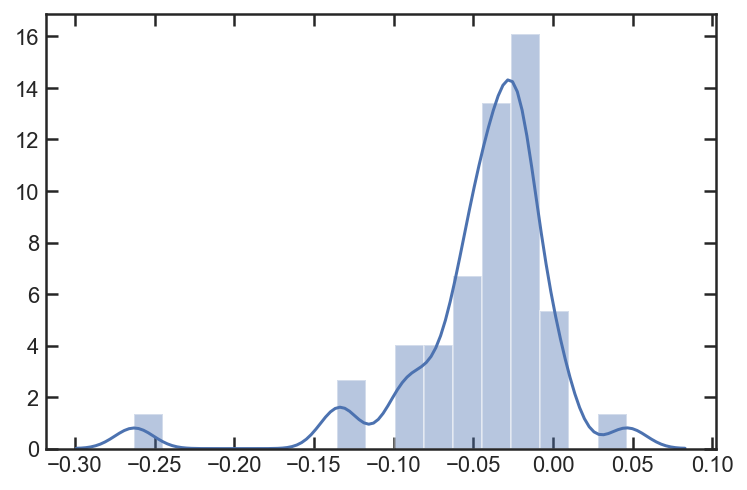

In [359]:
sea.distplot(res)

# Figure 4

In [315]:
def Roll_seg(X,Y,seg_limit,bin_size):
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_ratio = [] #; binned_low = [] ; binned_high = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        
        low = 0
        high = 0
        
        for U in Y[IDX]:
            if U <= seg_limit:
                low +=1
            else:
                high +=1
                
        binned_ratio.append(high / low) 
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_ratio)#, np.array(binned_wmean) , np.array(binned_err)


def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [312]:
lowlim = 1
z5_errbin_ls = []
z5_errbin_hs = []

while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_hs.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage
lowlim = 1
       
while lowlim < 9:
    print(lowlim)
    
    if lowlim < 5:
        addage = 2
    else:
        addage = 4

    
    lowerr = []
    hierr = []
    for i in mdb.index:
        lowerr.append(cosmo.lookback_time(mdb.z_50_hci[i][0]).value)
        hierr.append(cosmo.lookback_time(mdb.z_50_hci[i][1]).value)
       
    z5_errbin_ls.append(np.median((np.array(hierr) - np.array(lowerr))/2))
    
    if lowlim < 5:
        lowlim += addage
    else:
        lowlim += addage

1
3
5
1
3
5


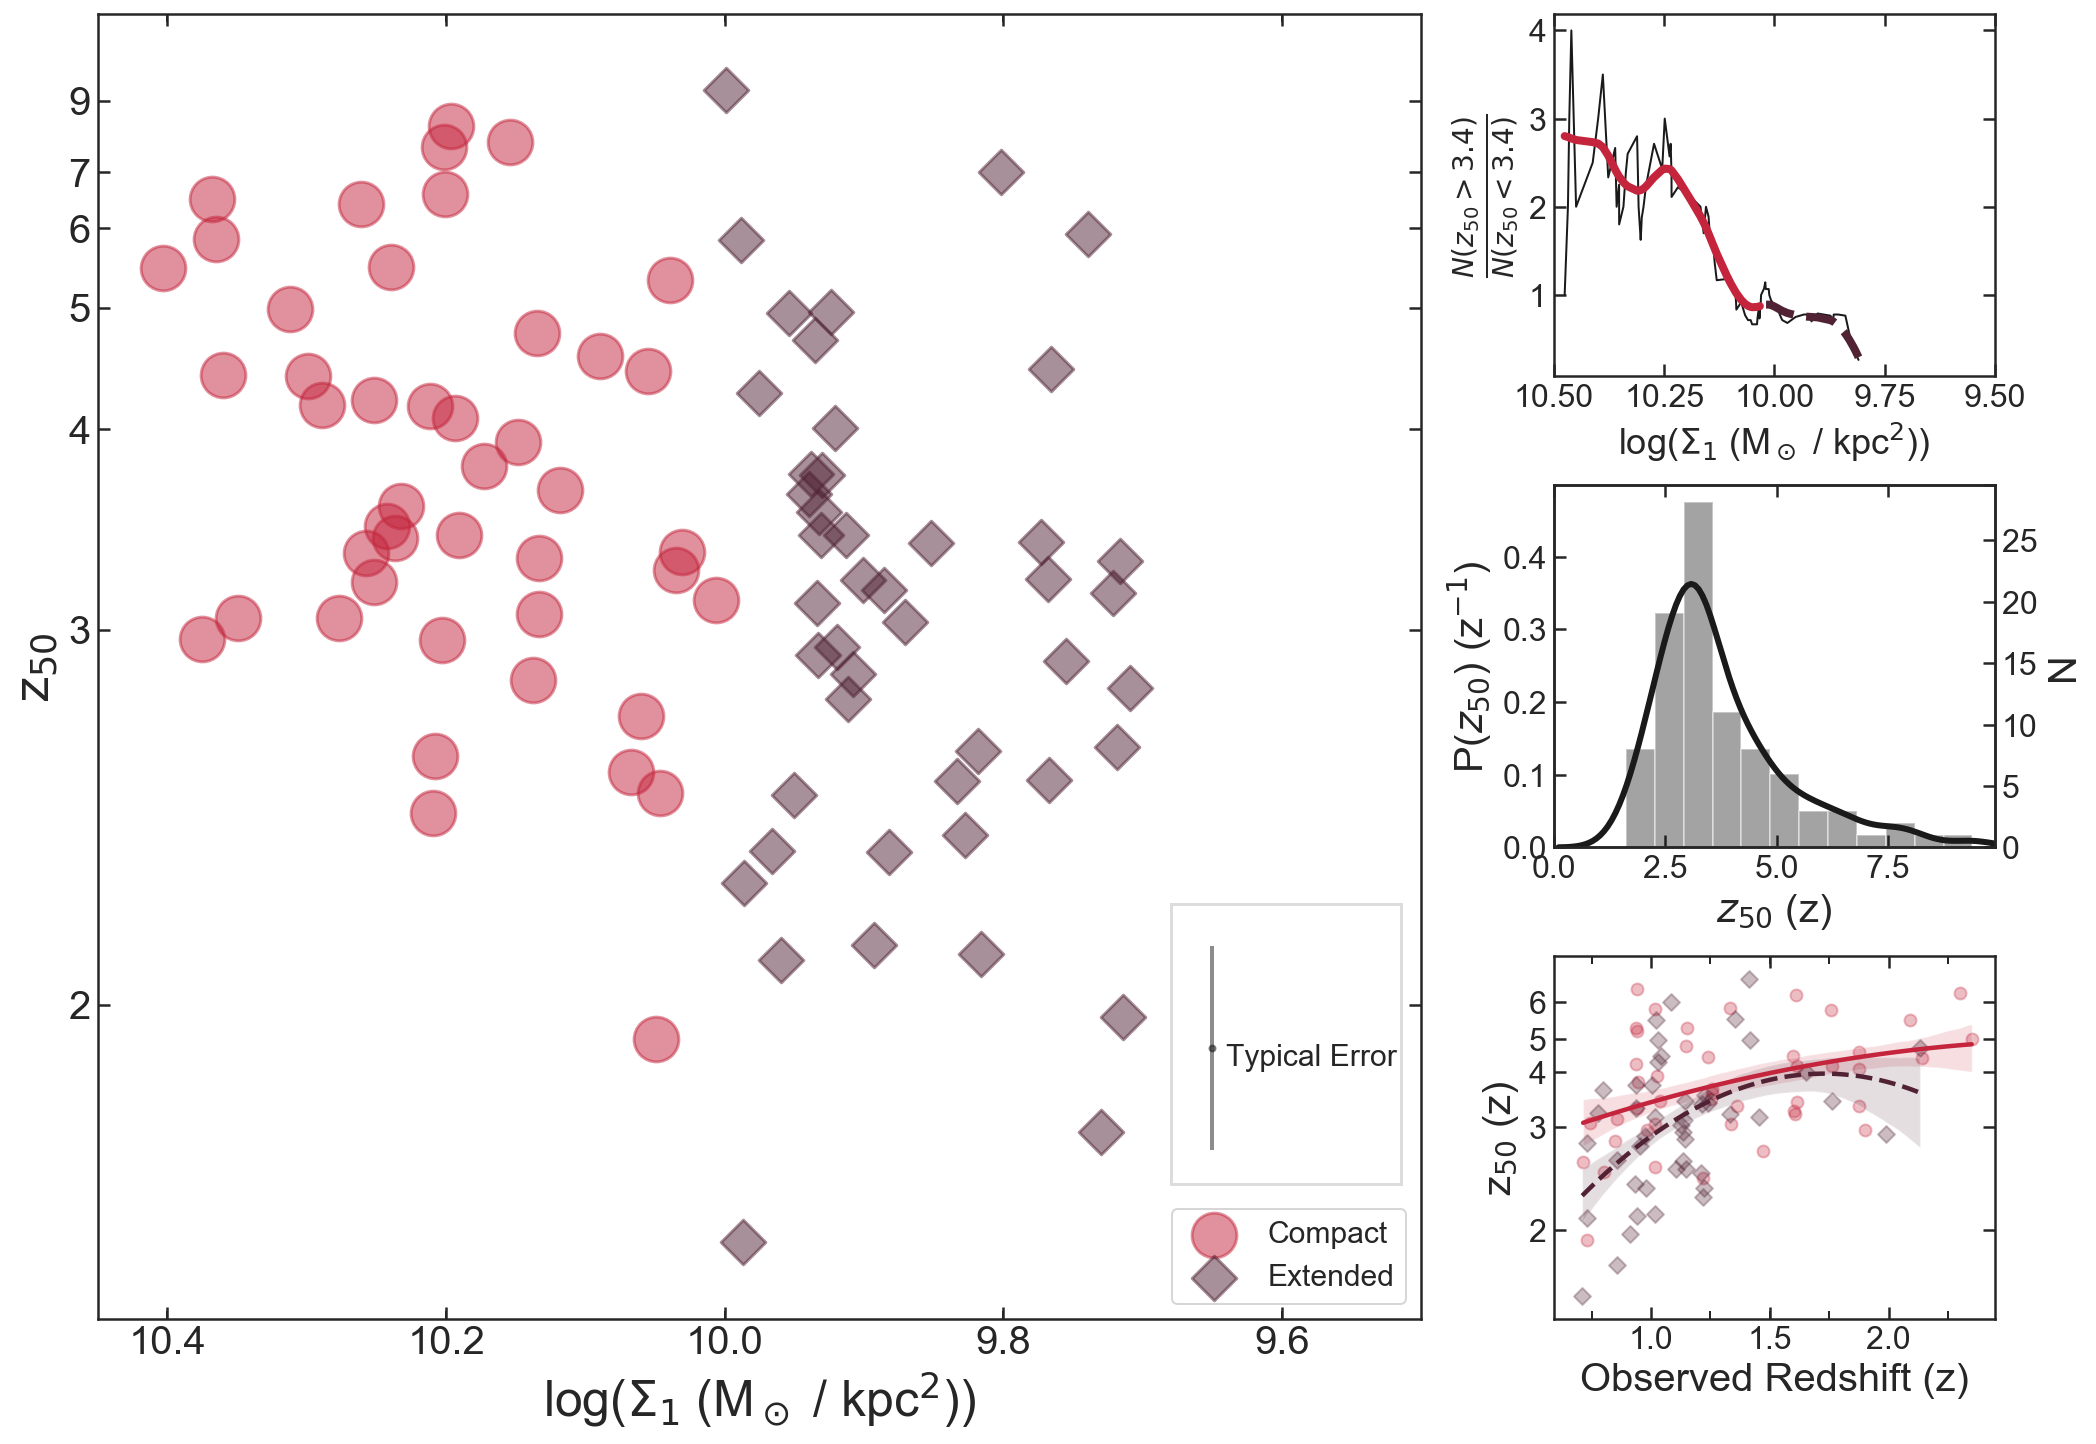

In [319]:
from matplotlib.patches import FancyBboxPatch

gs = gridspec.GridSpec(3,2,width_ratios=[3,1],hspace=0.3,wspace=0.15)

plt.figure(figsize=[17,12])

ax1 = plt.subplot(gs[:,0])

sea.scatterplot(np.log10(mdb.query('Sigma1 > 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 > 10**10').z_50),  legend=False,
                ax=ax1, color = '#C4253C', s = 500, marker = 'o', label = 'Compact', alpha = 0.5,
                edgecolor = '#C4253C', linewidth = 1.5)

sea.scatterplot(np.log10(mdb.query('Sigma1 < 10**10').Sigma1), 
                cosmo.lookback_time(mdb.query('Sigma1 < 10**10').z_50),  legend=False,
                ax=ax1, color = '#502234', s = 250, marker = 'D', label = 'Extended', alpha = 0.5,
               edgecolor = '#502234', linewidth = 1.5)

ax1.set_yticks(cosmo.lookback_time([2,3,4,5,6,7,9]).value)
ax1.set_yticklabels([2,3,4,5,6,7,9])
ax1.minorticks_off()

ax1.set_xticks([ 10.4, 10.2, 10.0, 9.8, 9.6], minor=True)
plt.xlim(10.45,9.5)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=25)
plt.ylabel('z$_{50}$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize=15, loc = 4)

rleg =plt.Rectangle((9.515, cosmo.lookback_time(1.7).value), 0.165,  0.85,
                     ec='k', fc='none', linewidth=1.5, alpha = 0.15)

ax1.add_artist(rleg)

plt.errorbar(9.65,cosmo.lookback_time(1.92).value, yerr=z5_errbin_ls[0], fmt = '.', ecolor = 'k',  color = 'k',
            elinewidth = 2, alpha = 0.5)
plt.text(9.64,cosmo.lookback_time(1.89).value, 'Typical Error', fontsize = 15)

ax2 = plt.subplot(gs[0,1])

med, mn, sratio = Roll_seg(np.log10(mdb.Sigma1.values), mdb.z_50.values, np.median(mdb.z_50), 0.2)

plt.plot(mn, sratio, linewidth=1, color = 'k')
plt.plot(mn[32:],Smooth(mn,sratio,0.03)[32:], linewidth=4, color='#C4253C')
plt.plot(mn[:31],Smooth(mn,sratio,0.03)[:31], linewidth=4, color='#502234', linestyle = '--')
plt.xlim(10.5,9.5)
plt.ylabel('$\\frac{N(z_{50} > 3.4)}{N(z_{50} < 3.4)}$', fontsize=20)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=18)

plt.tick_params(axis='both', which='major', labelsize=16)

ax3 = plt.subplot(gs[2,1])
Cmdb = mdb.query('Sigma1 > {0}'.format(10**10))
Emdb = mdb.query('Sigma1 < {0}'.format(10**10))
sea.regplot(Cmdb.zgrism, cosmo.lookback_time(Cmdb.z_50),order=2, 
            color = '#C4253C',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3})
sea.regplot(Emdb.zgrism, cosmo.lookback_time(Emdb.z_50),order=2, 
            color = '#502234',truncate=True, ax=ax3, ci = 68, scatter_kws={'alpha':0.3}, marker = 'D', line_kws= {'linestyle' : '--'})
ax3.set_xlabel('Observed Redshift (z)', fontsize=20)
ax3.set_ylabel('z$_{50}$ (z)', fontsize=20)

ax3.set_yticks(cosmo.lookback_time([2,3,4,5,7]).value)
ax3.set_yticklabels([2,3,4,5,6,7,9])
ax3.minorticks_off()
ax3.set_xticks([0.75, 1.25, 1.5,1.75, 2.25], minor = True)

plt.tick_params(axis='both', which='major', labelsize=16)

ax4 = plt.subplot(gs[1,1])
sea.distplot(mdb.z_50, ax = ax4,kde_kws= {'linewidth':3}, color = 'k')
ax4a = ax4.twinx()
ax4a.set_ylim(ax4.get_ylim())
ax4a.set_yticks([0,5,10,15,20,25,29.5])
ax4a.set_yticklabels([0,5,10,15,20,25,])
ax4a.yaxis.set_ticks_position('right')
ax4.set_ylabel('P($z_{50}$) (z$^{-1}$)', fontsize=20)
ax4.set_xlabel('$z_{50}$ (z)', fontsize=20)
ax4a.set_ylabel('N', fontsize=20)
ax4.tick_params(axis='both', which='major', labelsize=16)
ax4a.tick_params(axis='both', which='major', labelsize=16)
ax4.set_xlim(0,9.9)
plt.savefig('../plots/compact_sig1.pdf', bbox_inches = 'tight')

Text(0.5,0,'log($\\Sigma_1$ (M$_\\odot$ / kpc$^2$))')

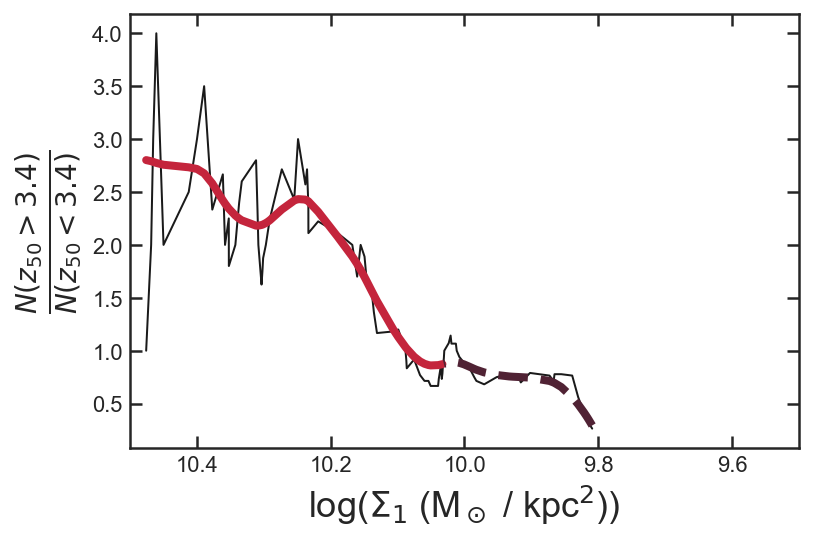

In [316]:
med, mn, sratio = Roll_seg(np.log10(mdb.Sigma1.values), mdb.z_50.values, np.median(mdb.z_50), 0.2)

plt.plot(mn, sratio, linewidth=1, color = 'k')
plt.plot(mn[32:],Smooth(mn,sratio,0.03)[32:], linewidth=4, color='#C4253C')
plt.plot(mn[:31],Smooth(mn,sratio,0.03)[:31], linewidth=4, color='#502234', linestyle = '--')
plt.xlim(10.5,9.5)
plt.ylabel('$\\frac{N(z_{50} > 3.4)}{N(z_{50} < 3.4)}$', fontsize=20)
plt.xlabel('log($\Sigma_1$ (M$_\odot$ / kpc$^2$))', fontsize=18)

In [318]:
np.mean(mdb.z_50)

3.7663176970182155

# Figure 5

In [484]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)
    ################
    stack = np.zeros(len(lbt))
    for i in range(len(lbt)):
#         weights = len(sfhgrid[i][sfhgrid[i] > 0])
        stack[i] = np.mean(sfhgrid[i])        
#         stack[i] = np.median(sfhgrid[i])        

    return stack

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


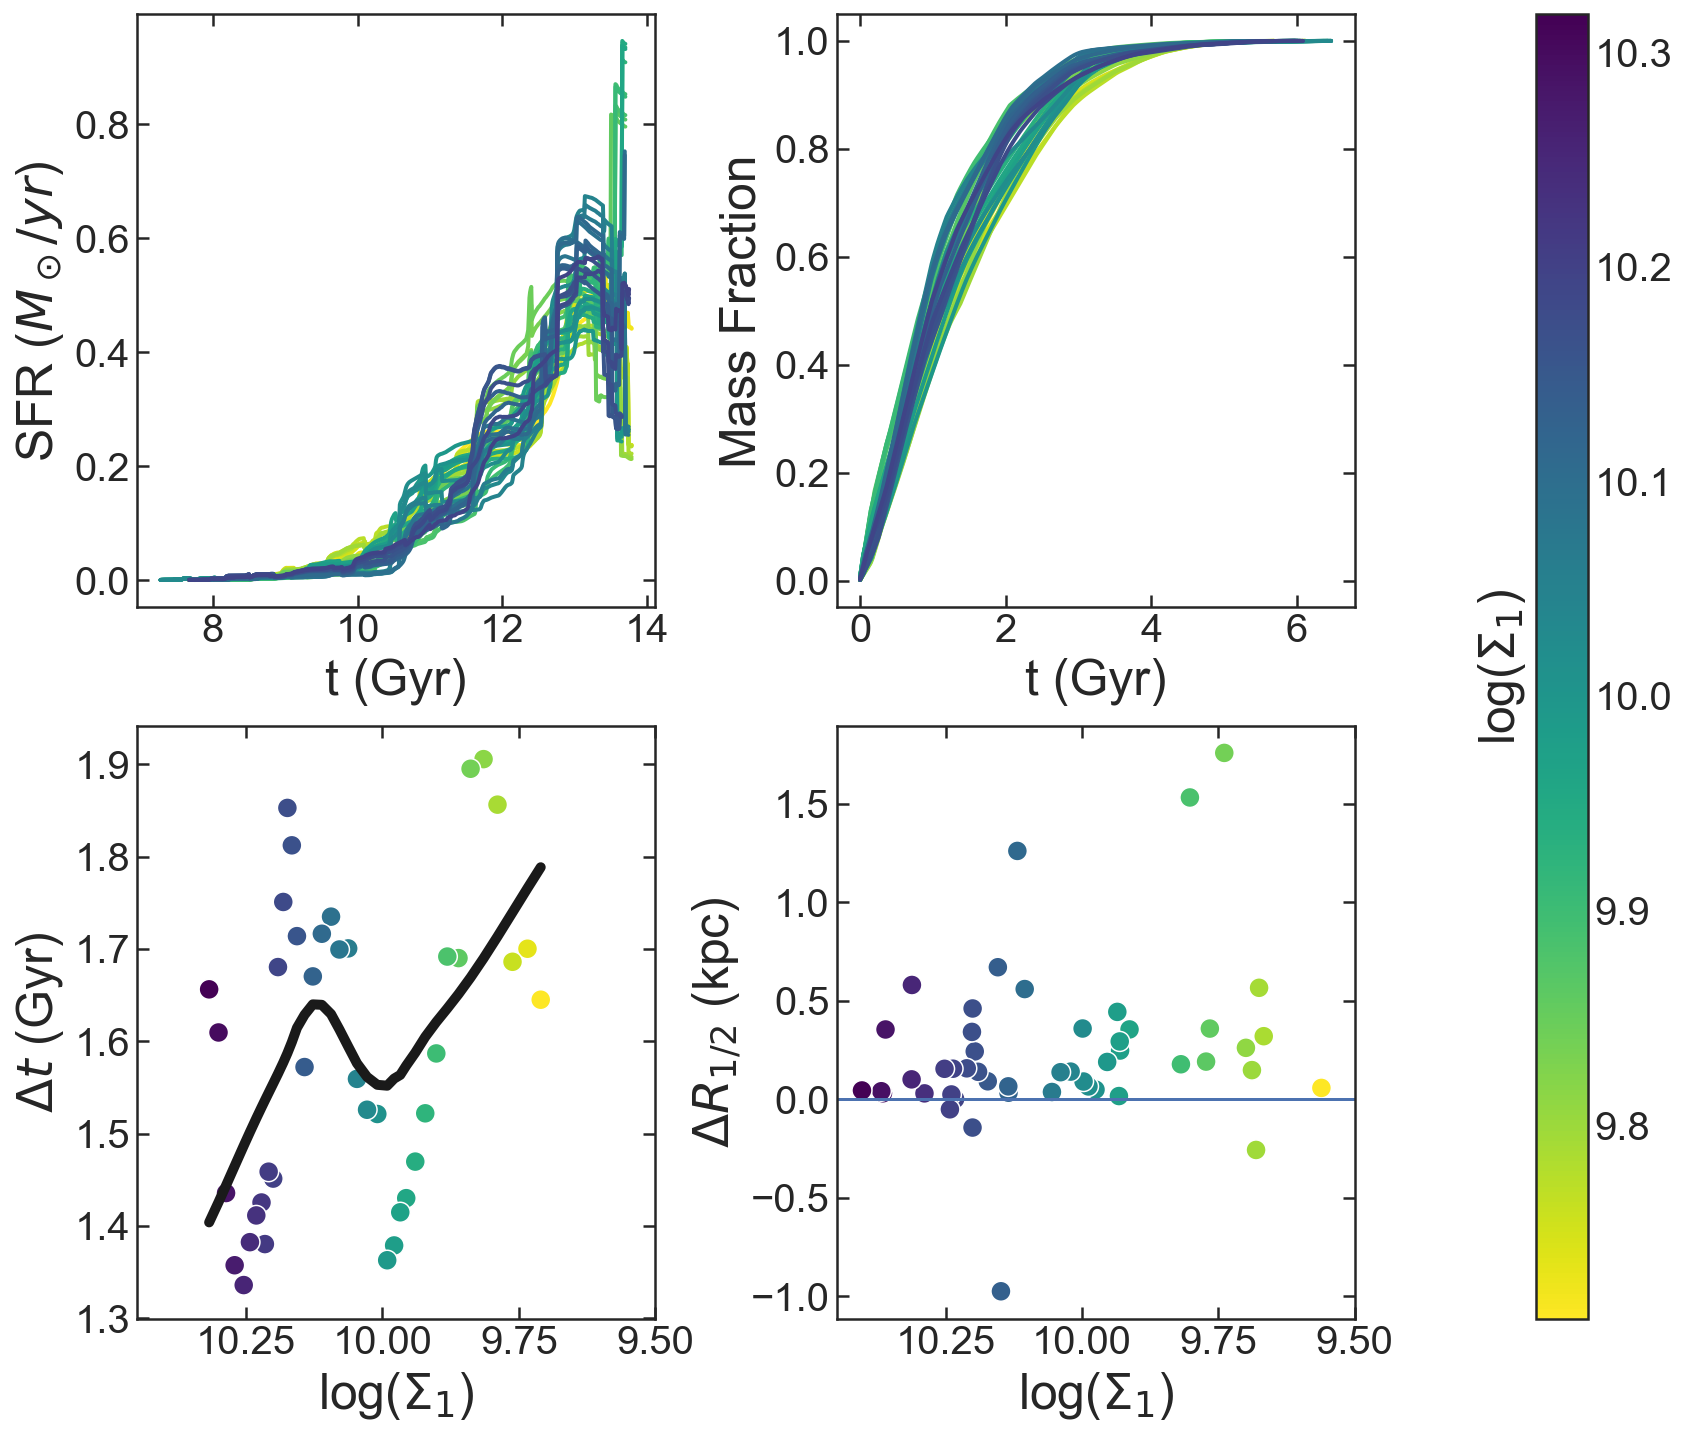

In [663]:
#import colormap
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(Smdb))

IDS = Smdb.index.values

bs =9

gs = gridspec.GridSpec(2,3, wspace=0.5, width_ratios=[1,1,0.1])

plt.figure(figsize =[13,12])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])

idx = 0

t50 = []
t90 = []
s1 = []

LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

for i in range(len(IDS) - bs):
    SFH_grid = []
    
    for ii in range(bs):
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[IDS[i + ii]], mdb.id[IDS[i + ii]]))

        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[IDS[i + ii]]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

    L,S= Stack_SFH(LBT, SFH_grid)
    
    ax1.plot(L, S/np.trapz(S,L), linewidth = 2,color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255 )
    ax2.plot(L - min(L), np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])), linewidth = 2, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255)
    idx+=1
    
    mb = interp1d(np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])),L - min(L))
    t50.append(mb(0.5))
    t90.append(mb(0.9))
    samp = []
    for ii in range(bs+1):
        samp.append(Smdb.Sigma1[IDS[i + ii]])
        
    s1.append(np.mean(samp))
    
sea.regplot(np.log10(s1),np.array(t90)-np.array(t50),lowess=True, scatter=False,line_kws={"linewidth" : 5}, color='k')
# for i in range(len(IDS) - bs):
#     sea.scatterplot(np.log10(s1[i]),np.array(t90[i])-np.array(t50[i]), s=100, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255,
#                    ax = ax3)
sea.scatterplot(np.log10(s1),np.array(t90)-np.array(t50), s=100, palette = 'viridis_r',hue = np.log10(s1),legend = False)
plt.xlim(10.45,9.5)

ax1.set_ylabel('SFR ($M_\odot / yr$)', fontsize=25)
ax1.set_xlabel('t (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.set_ylabel('$\Delta t$ (Gyr)', fontsize=25)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax4 = plt.subplot(gs[1,1])
sea.scatterplot(np.log10(Smdb.Sigma1), Smdb.Re_f125 - Smdb.Re_f160, ax = ax4, palette = 'viridis_r', hue = np.log10(Smdb.Sigma1),
               legend = False, s= 100)
plt.axhline(0)
plt.xlim(10.45,9.5)
ax4.set_ylabel('$\Delta R_{1/2}$ (kpc)', fontsize=25)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax5 = plt.subplot(gs[:,2])
cmap = 'viridis_r'
norm = mpl.colors.Normalize(vmin=min(np.log10(s1)), vmax = max(np.log10(s1)))
mpl.colorbar.ColorbarBase(ax5, cmap = cmap, norm=norm, orientation='vertical')
ax5.set_ylabel('log($\Sigma_1$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.yaxis.set_label_position('left')

# plt.savefig('../plots/sfh_dt.pdf', bbox_inches = 'tight')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


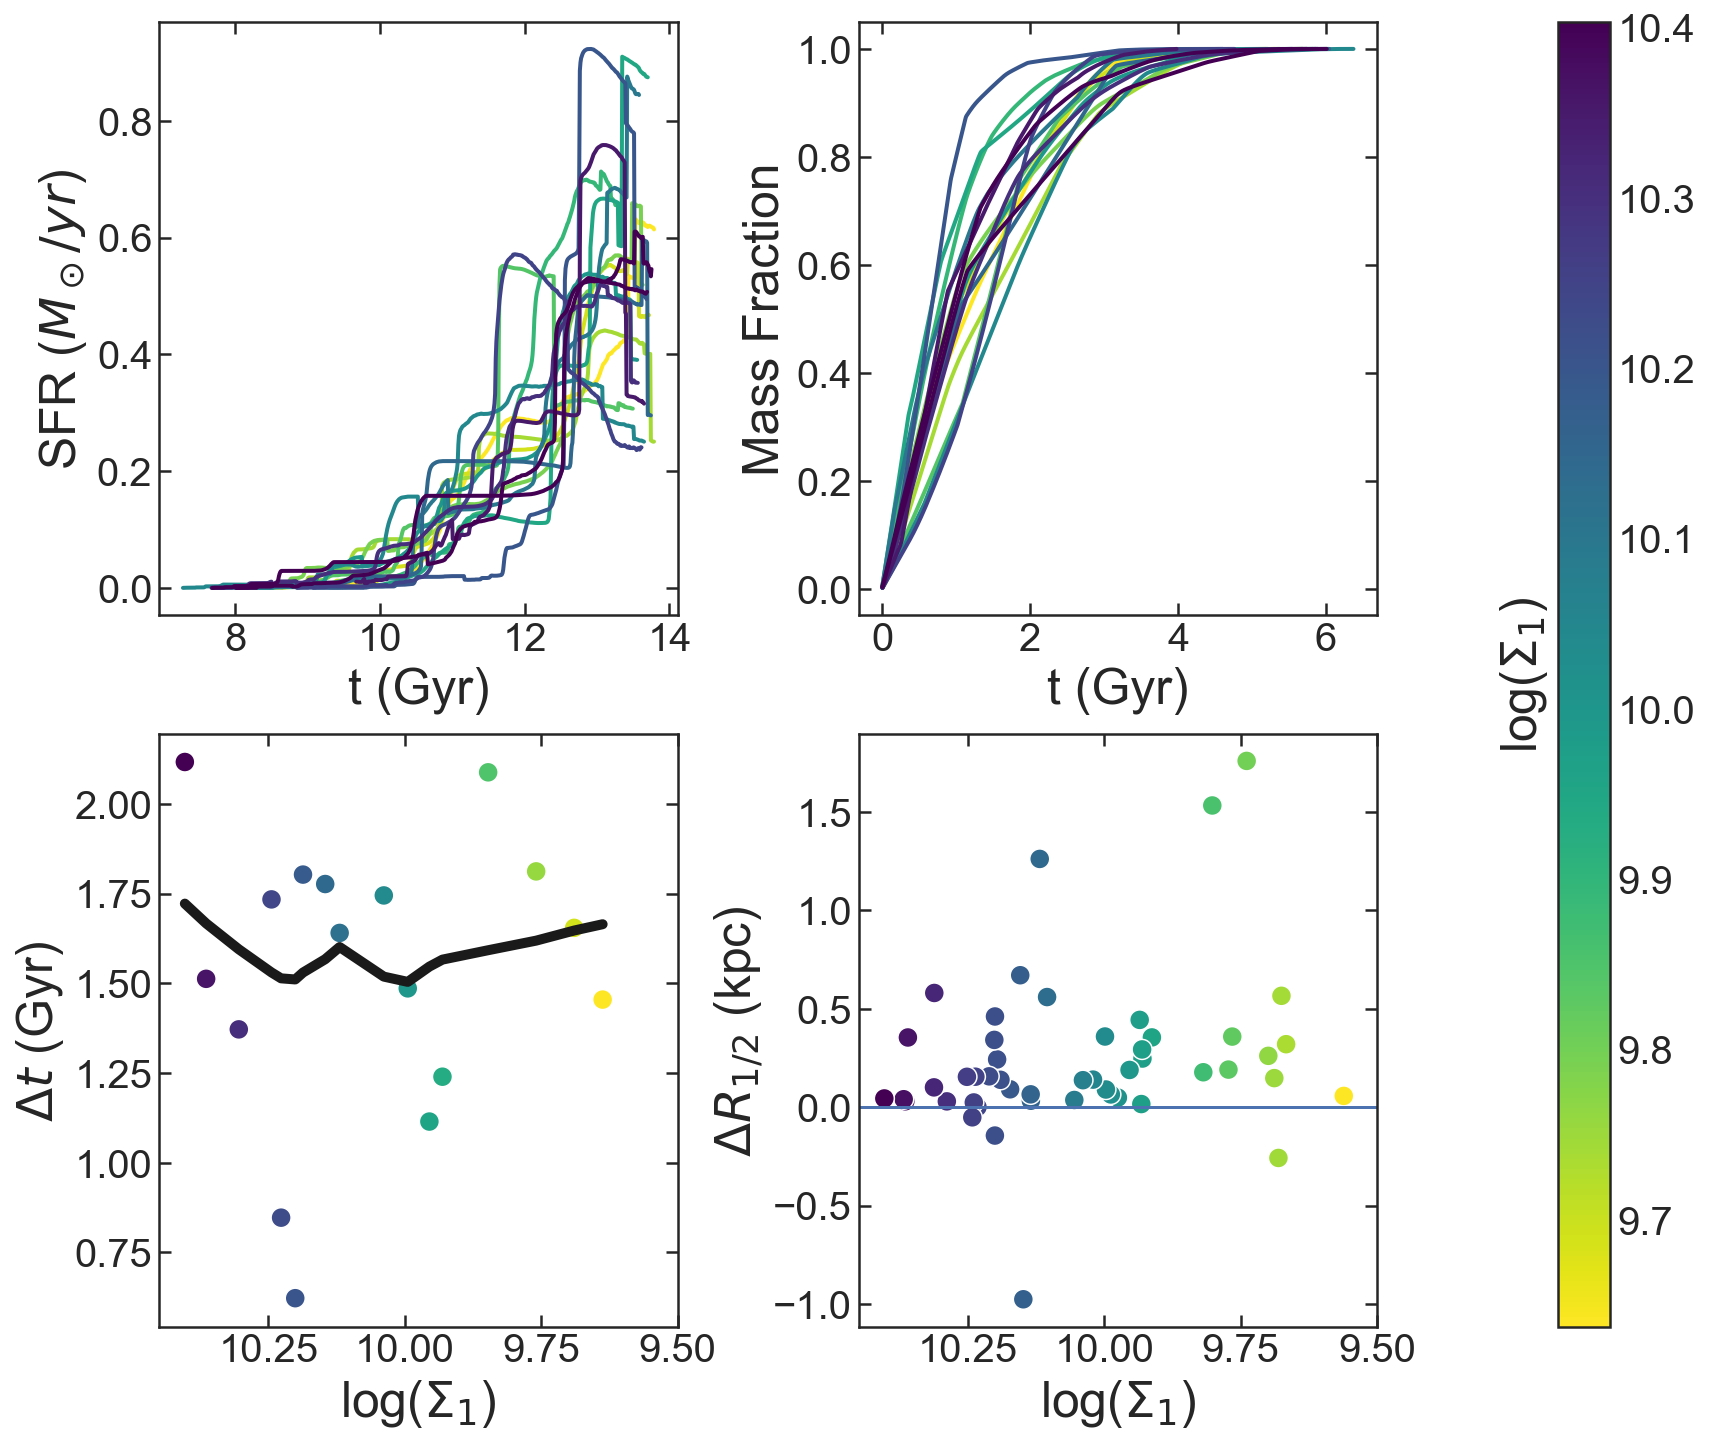

In [10]:
#import colormap
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=15)

IDS = Smdb.index.values

bs = 3

gs = gridspec.GridSpec(2,3, wspace=0.5, width_ratios=[1,1,0.1])

plt.figure(figsize =[13,12])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])

idg = 0
idx = 0
t50 = []
t90 = []
s1 = []
LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

while idg < len(IDS):
    SFH_grid = []
    samp = []
    for ii in IDS[idg:idg+bs]:
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[ii], mdb.id[ii]))

        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[ii]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))
        samp.append(Smdb.Sigma1[ii])

    L,S= Stack_SFH(LBT, SFH_grid)
    
    ax1.plot(L, S/np.trapz(S,L), linewidth = 2,color = np.array(cm.viridis_r(norm(idx),bytes=True)) / 255 )
    ax2.plot(L - min(L), np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])), linewidth = 2, 
             color = np.array(cm.viridis_r(norm(idx),bytes=True)) / 255)
    idx+=1
    
    mb = interp1d(np.cumsum(S[::-1]) / max(np.cumsum(S[::-1])),L - min(L))
    t50.append(mb(0.5))
    t90.append(mb(0.9))        
    s1.append(np.mean(samp))
    
    idg += bs

sea.regplot(np.log10(s1),np.array(t90)-np.array(t50),lowess=True, scatter=False,line_kws={"linewidth" : 5}, color='k')
# for i in range(len(IDS) - bs):
#     sea.scatterplot(np.log10(s1[i]),np.array(t90[i])-np.array(t50[i]), s=100, color = np.array(cm.viridis_r(norm(i),bytes=True)) / 255,
#                    ax = ax3)
sea.scatterplot(np.log10(s1),np.array(t90)-np.array(t50), s=100, palette = 'viridis_r',hue = np.log10(s1),legend = False)
plt.xlim(10.45,9.5)

ax1.set_ylabel('SFR ($M_\odot / yr$)', fontsize=25)
ax1.set_xlabel('t (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax3.set_ylabel('$\Delta t$ (Gyr)', fontsize=25)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax4 = plt.subplot(gs[1,1])
sea.scatterplot(np.log10(Smdb.Sigma1), Smdb.Re_f125 - Smdb.Re_f160, ax = ax4, palette = 'viridis_r', hue = np.log10(Smdb.Sigma1),
               legend = False, s= 100)
plt.axhline(0)
plt.xlim(10.45,9.5)
ax4.set_ylabel('$\Delta R_{1/2}$ (kpc)', fontsize=25)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax5 = plt.subplot(gs[:,2])
cmap = 'viridis_r'
norm = mpl.colors.Normalize(vmin=min(np.log10(s1)), vmax = max(np.log10(s1)))
mpl.colorbar.ColorbarBase(ax5, cmap = cmap, norm=norm, orientation='vertical')
ax5.set_ylabel('log($\Sigma_1$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.yaxis.set_label_position('left')

# plt.savefig('../plots/sfh_dt.pdf', bbox_inches = 'tight')

(10.45, 9.5)

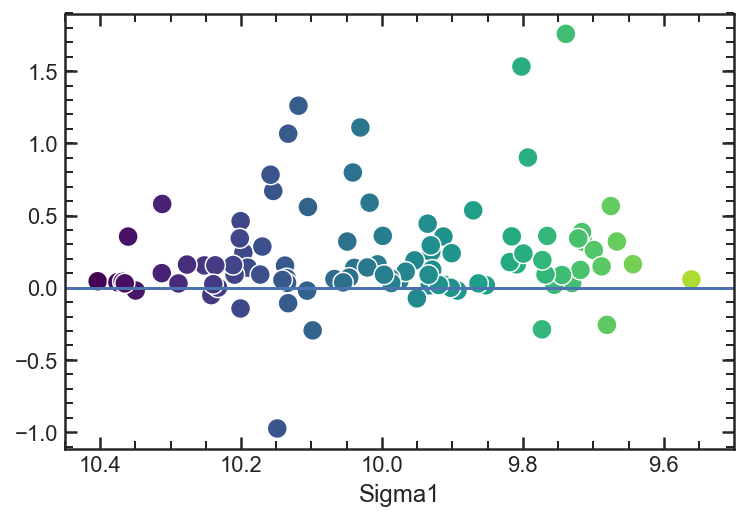

In [6]:
plt.figure()
ax4 = plt.subplot()
sea.scatterplot(np.log10(mdb.Sigma1), mdb.Re_f125 - mdb.Re_f160, ax = ax4, palette = 'viridis_r', hue = np.log10(mdb.Sigma1),
               legend = False, s= 100)
ax4.axhline(0)
plt.xlim(10.45,9.5)


1.5729127281013753
1.468525482294067
0.8677658756335594


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


1.4482122973366889


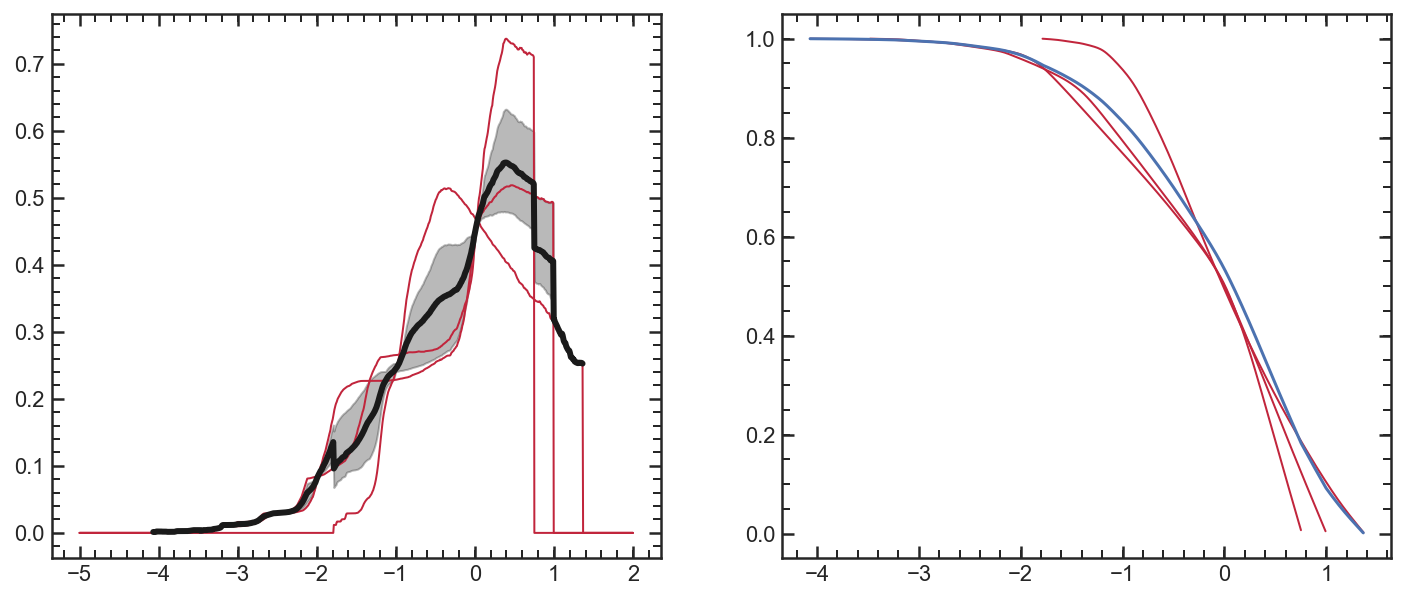

In [30]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

Smdb = Smdb.sort_values('Sigma1')

LBT = np.linspace(-5,2,1000)
SFH_grid = []

gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[12,5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

idx = 0
for i in Smdb.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    lbt, mt = Get_mass_track(mdb.field[i], mdb.id[i],mdb.lmass[i])
    print(mdb.t_50[i] - mdb.t_90[i])
    
    isfh = interp1d(lbt - mdb.t_50[i],sfh, fill_value=0, bounds_error=False)(LBT)    
    ax1.plot(LBT , isfh / np.trapz(isfh, LBT), color = '#C1253C', linewidth = 1)
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

    ax2.plot(lbt - mdb.t_50[i], mt / max(mt), color = '#C1253C', linewidth = 1)

    
    idx+=1
    if idx == 3:
        break

    
L ,S ,S16 ,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 50)

ax1.plot(L, S, 'k', linewidth = 3)
ax1.fill_between(L, S16, S84,color = 'k', alpha = 0.3)


mt = np.cumsum(S[::-1]) * (LBT[1] - LBT[0])*1E9

#put into lookback time
mt = np.array(mt)[::-1]
mt = mt/max(mt)        

print(interp1d(mt,L)(0.5)-interp1d(mt,L)(0.9))
ax2.plot(L,mt)

In [158]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)

    ################   
    SFH = []
    ltimes = []

    for i in range(len(lbt)):
        gdat = sfhgrid[i][sfhgrid[i]>0]

        SFH.append(np.mean(gdat) )
        ltimes.append(lbt[i])

    SFH = np.array(SFH)
    LBT = np.array(ltimes)
    return LBT[SFH**2 > 0], SFH[SFH**2 > 0]

def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))    
        L,S= Stack_SFH(lbt, np.array(sfh)[IDX])
        istack = interp1d(L,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)

    sfh_bs = np.array(sfh_bs)
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84

KeyboardInterrupt: 

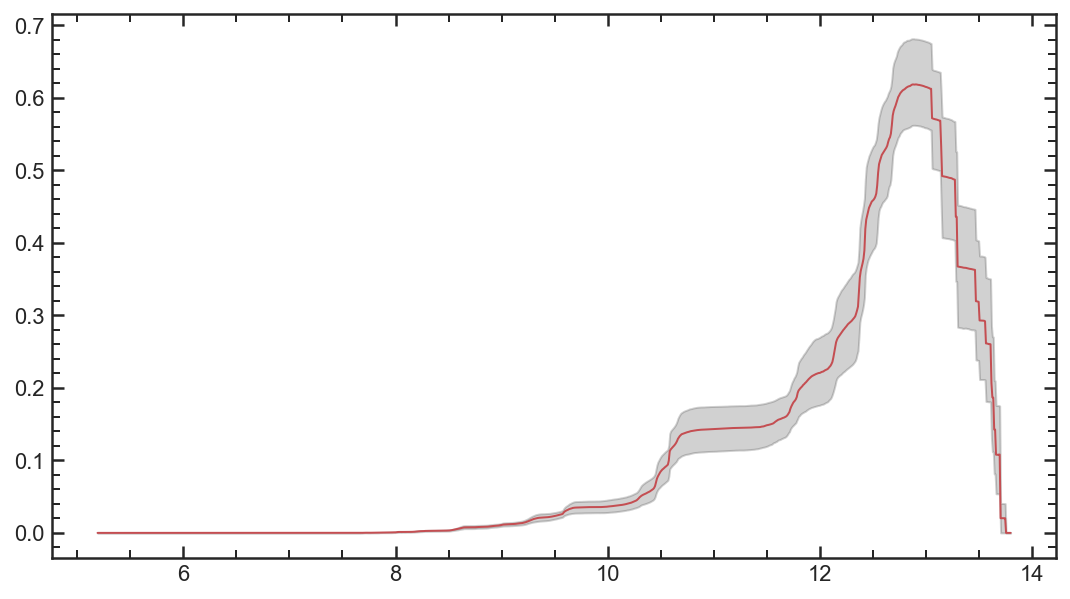

In [4]:
def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))
        newgrid = np.transpose(np.array(sfh)[IDX])
    
        stack = np.zeros(len(lbt))
        for i in range(len(lbt)):   
            stack[i] = np.mean(newgrid[i])        

        sfh_bs.append(stack)
    return np.percentile(sfh_bs,50,axis=0), np.percentile(sfh_bs,16,axis=0), np.percentile(sfh_bs,84,axis=0)

plt.figure(figsize=[9,5])
LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)
SFH_grid = []

for i in mdb.query('0.9 < zgrism < 1.1 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(LBT, S,'r', linewidth=1)
plt.fill_between(LBT, S16, S84,color='k', alpha = 0.2)

SFH_grid = []
for i in mdb.query('0.9 < zgrism < 1.1 and z_50 < 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))   
    isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
    SFH_grid.append(isfh / np.trapz(isfh, LBT))

S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(LBT, S,'b', linewidth=1)
plt.fill_between(LBT, S16, S84,color='k', alpha = 0.2)

plt.xticks(cosmo.lookback_time([1,2,4,6,8]).value,[1,2,4,6,8])
plt.xlim(7,13.8)

In [15]:
def Stack_SFH(lbt, sfh):
    sfhgrid = np.transpose(sfh)

    ################   
    SFH = []
    ltimes = []

    for i in range(len(lbt)):
        gdat = sfhgrid[i][sfhgrid[i]>0]

        SFH.append(np.mean(gdat) )
        ltimes.append(lbt[i])

    SFH = np.array(SFH)
    LBT = np.array(ltimes)
    return LBT[SFH**2 > 0], SFH[SFH**2 > 0]

def Stack_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))    
        L,S= Stack_SFH(lbt, np.array(sfh)[IDX])
        istack = interp1d(L,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)

    sfh_bs = np.array(sfh_bs)
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84


# L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 10)

# plt.plot(L, S)
# plt.fill_between(L,S16,S84, alpha = 0.3)

In [656]:
from matplotlib import cm
from matplotlib import colors
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')
Smdb = Smdb.sort_values('Sigma1')

#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(Smdb))

IDS = Smdb.index.values

bs = 9

LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)

for i in range(len(IDS) - bs):
    SFH_grid = []
    
    for ii in range(bs):
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[IDS[i + ii]], mdb.id[IDS[i + ii]]))

        
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[IDS[i + ii]]).value, sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

    L,S,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its = 500)
    
SFH_grid = np.array(SFH_grid)

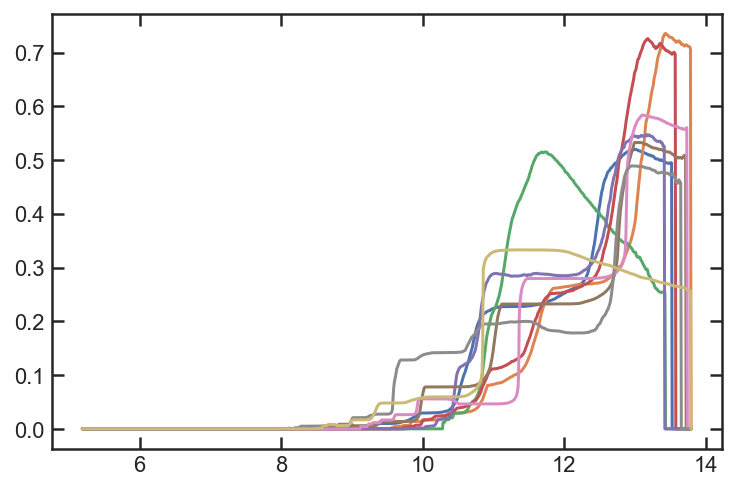

In [657]:
plt.plot(LBT,SFH_grid.T)

In [7]:
def Get_mass_track(field, galaxy, lmass):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))    
    #make mass track
    mt = np.cumsum(sfh[::-1]) * (lbt[1] - lbt[0])*1E9
    
    #put into lookback time
    mt = np.array(mt)[::-1]
    
    #rescale
    mt /= max(mt)
    mt *= 10**lmass
    return lbt, mt

def Get_tq(field, galaxy):
    lbt, sfh = np.load('../data/SFH/{}_{}.npy'.format(field, galaxy))
    lbt, mtk = Get_mass_track(field, galaxy, mdb.query('id == {}'.format(galaxy)).lmass.values[0])
    
    sSFR = np.log10(sfh/mtk)
    
    prop_t = lbt + cosmo.lookback_time(mdb.query('id == {}'.format(galaxy)).zgrism.values[0]).value
    prop_a = (cosmo.lookback_time(1E5).value - prop_t) * 1E9
    
    sf_lim = np.log10(1/prop_a)
    q_lim = np.log10(0.2/prop_a)
    
    sf_frm = sSFR - sf_lim
    q_frm = sSFR - q_lim
    
    tq = interp1d(sf_frm, prop_t)(0) - interp1d(q_frm,prop_t)(0)
    th = interp1d(q_frm,prop_a)(0)
    
    return np.array([tq,th*1E-9])


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


(10.45, 9.4)

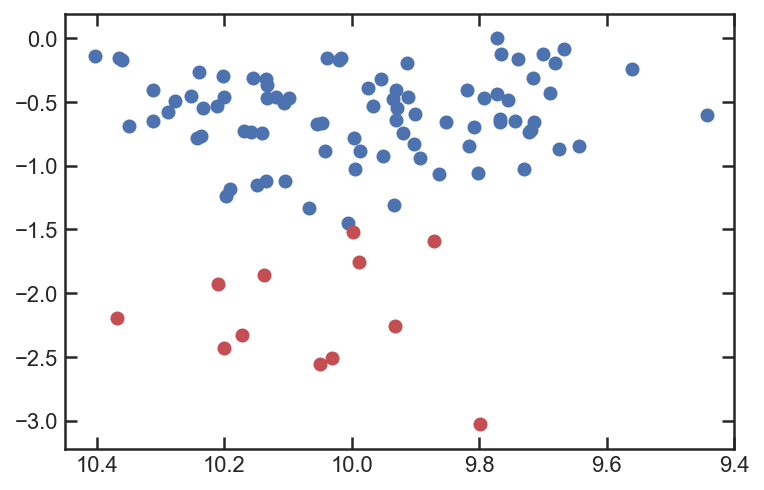

In [92]:
zlim = np.percentile(mdb.z_50,50)
Smdb = mdb.query('z_50 > {}'.format(zlim)).sort_values('Sigma1')

trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th) > -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'b')
        
    if np.log10(tq/th) < -1.5:  
        plt.scatter(np.log10(mdb.Sigma1[i]) ,np.log10(tq/th),color = 'r')
    trk.append(np.log10(tq/th)) 
plt.xlim(10.45,9.4)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


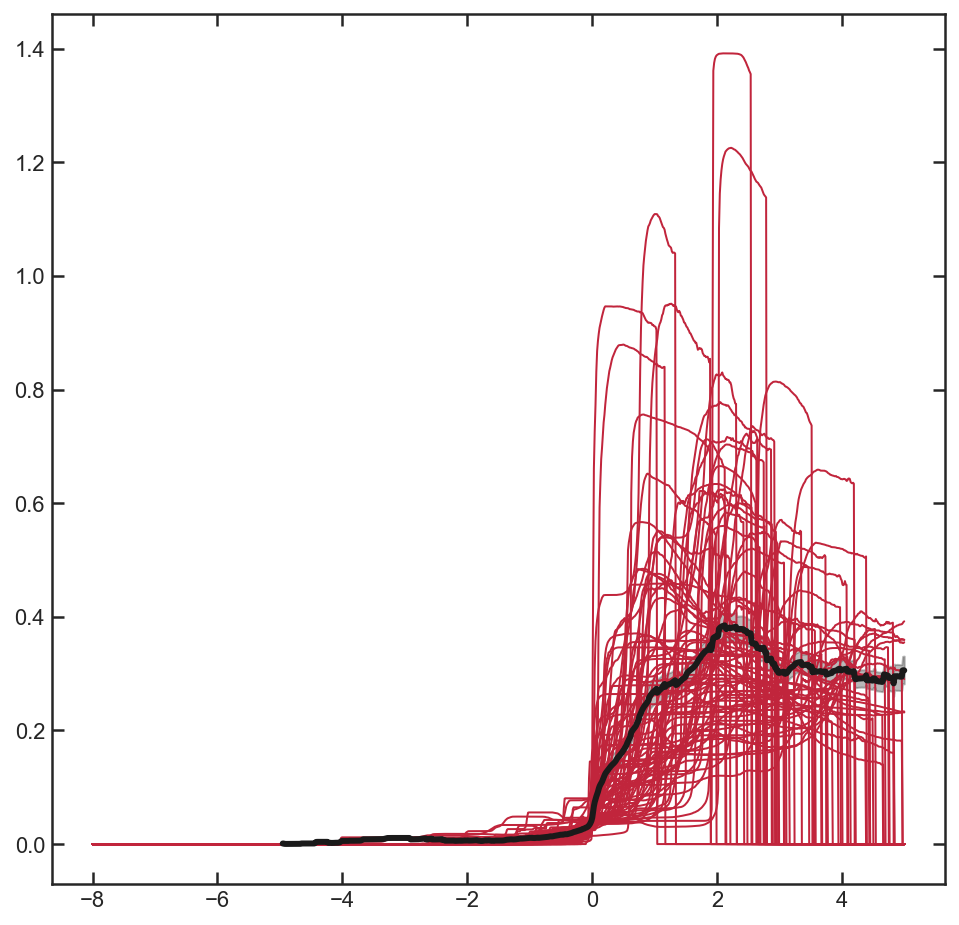

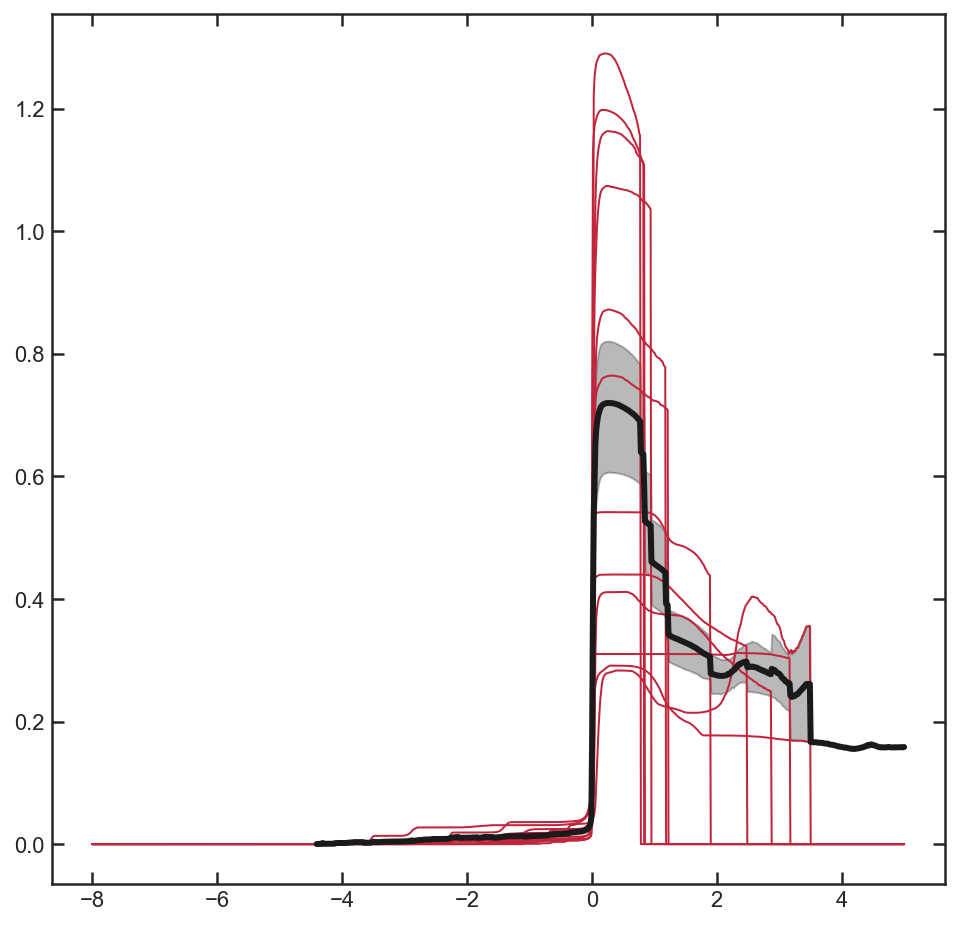

In [93]:
plt.figure(figsize =[8,8])

# LBT = np.linspace(cosmo.lookback_time(0.5).value,cosmo.lookback_time(1000).value,1000)
LBT = np.linspace(-8,5,1000)

SFH_grid = []
for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) > -1.5:  
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value - (cosmo.lookback_time(1E5).value - th), sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

        plt.plot(LBT, isfh / np.trapz(isfh, LBT), color = '#C1253C', linewidth = 1)
    
L_lz,S_lz,S16_lz,S84_lz = Stack_SFH_bs(LBT, SFH_grid, its = 1000)
plt.plot(L_lz, S_lz, 'k', linewidth = 3)
plt.fill_between(L_lz, S16_lz, S84_lz,color = 'k', alpha = 0.3)

plt.figure(figsize =[8,8])

SFH_grid = []
for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    field = mdb.field[i]
    galaxy = mdb.id[i]
    if np.log10(tq/th) < -1.5:  
        lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
        isfh = interp1d(lbt + cosmo.lookback_time(mdb.zgrism[i]).value - (cosmo.lookback_time(1E5).value - th), 
                        sfh, fill_value=0, bounds_error=False)(LBT)    
        SFH_grid.append(isfh / np.trapz(isfh, LBT))

        plt.plot(LBT , isfh / np.trapz(isfh, LBT), color = '#C1253C', linewidth = 1)
       
    
L_hz,S_hz,S16_hz,S84_hz = Stack_SFH_bs(LBT, SFH_grid, its = 1000)

plt.plot(L_hz, S_hz, 'k', linewidth = 3)
plt.fill_between(L_hz, S16_hz, S84_hz,color = 'k', alpha = 0.3)

In [65]:
cosmo.lookback_time(1.25),cosmo.lookback_time(1E5) - cosmo.age(1.25)

(<Quantity 8.82446898 Gyr>, <Quantity 8.8244689 Gyr>)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


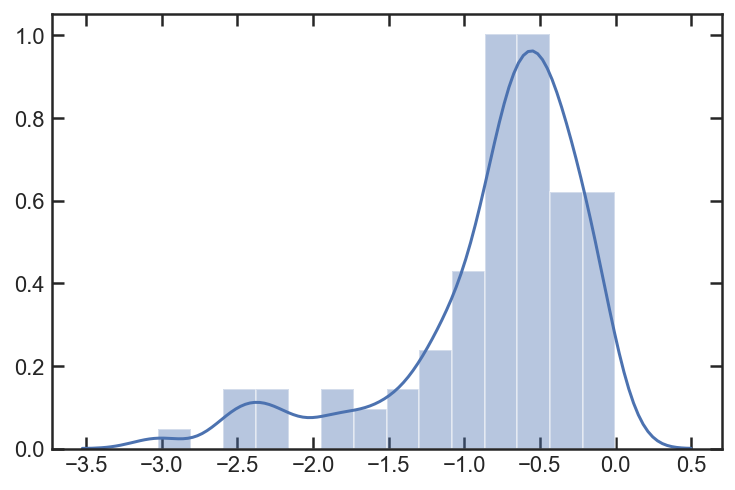

In [91]:
trk = []

for i in mdb.index:
    tq,th = Get_tq(mdb.field[i], mdb.id[i])
    if np.log10(tq/th)**2 > 0:
#         print(tq,th,i)
        trk.append(np.log10(tq/th)) 

sea.distplot(trk)

In [347]:
S1db = mdb.query('z_50 > 3.4').sort_values('Sigma1')

In [463]:
import pickle
idx = 0
LBT = np.linspace(0,14, 1000)
L=[]
S=[]
Sl=[]
Sh=[]
DT=[]
DTl=[]
DTh=[]

Sig1 = []
M = []
while idx < len(S1db.index)-14:
    SFH_grid = []
    s1_grid = []
    M_grid = []
    for i in S1db.index[idx:idx + 15]:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
            
        except:
            with open('../data/SFH/{}_{}.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                sfh = pickle.load(sfh_file)
            lbt = sfh.LBT 
            sfh = sfh.SFH 
                
        isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
#         SFH_grid.append(isfh/ np.trapz(isfh, LBT))
        SFH_grid.append(isfh)
        s1_grid.append(S1db.Sigma1[i])
        M_grid.append(10**S1db.lmass[i])
    
#     L1,S1,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its=50)
    L1,S1,S16,S84,dt, dt16, dt84  = Sum_SFH_bs(LBT, SFH_grid)
    L.append(L1)
    S.append(S1)
    Sl.append(S16)
    Sh.append(S84)
    DT.append(dt)
    DTl.append(dt16)
    DTh.append(dt84)
    
    Sig1.append(np.mean(s1_grid))
    M.append(np.mean(M_grid))
    
    idx+=1

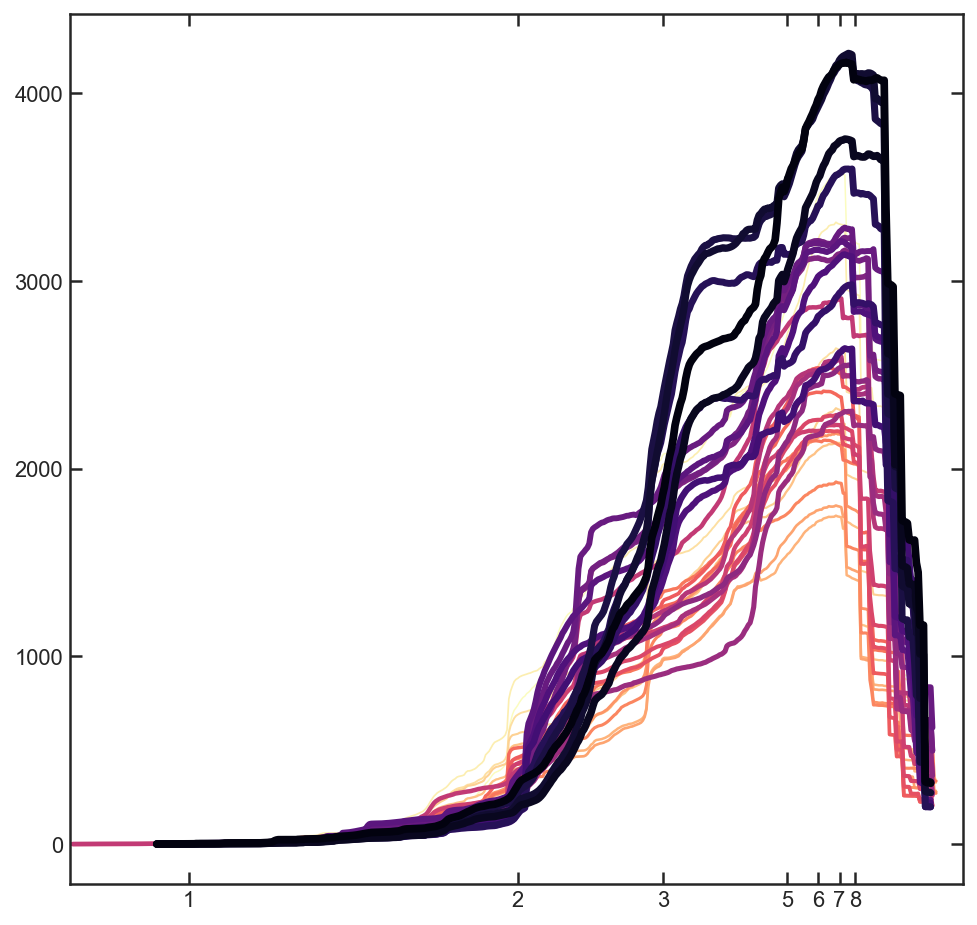

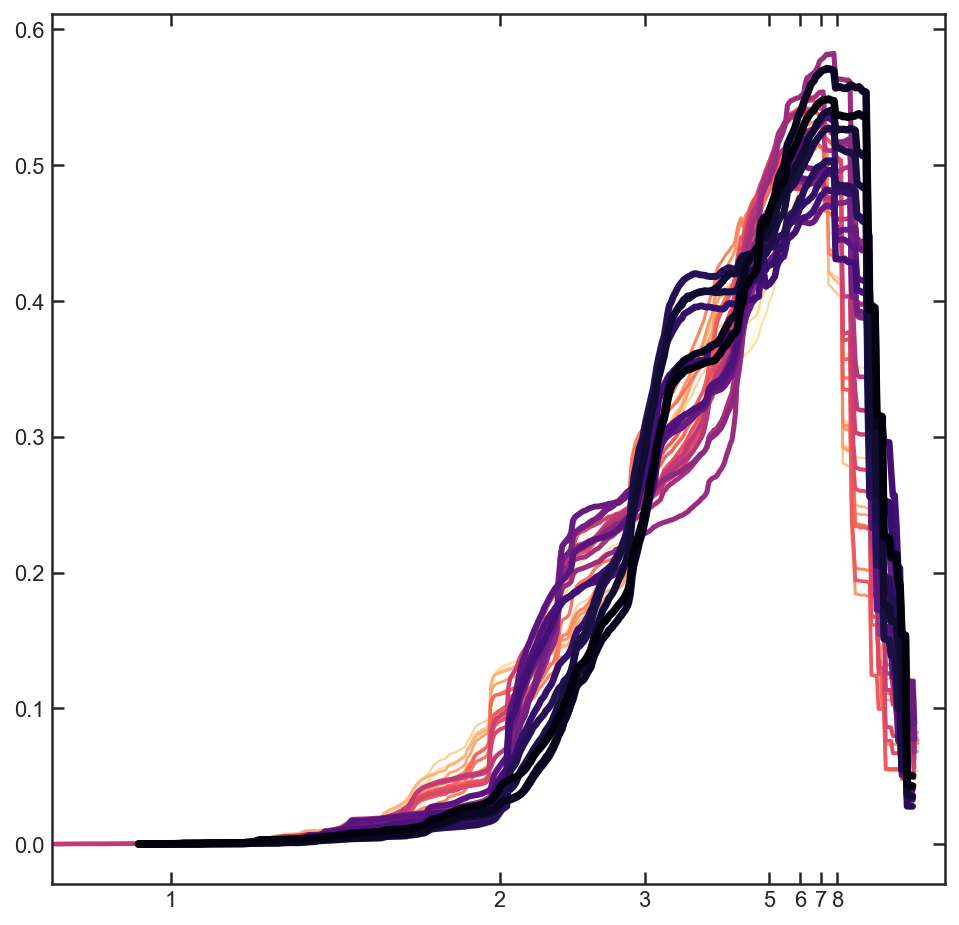

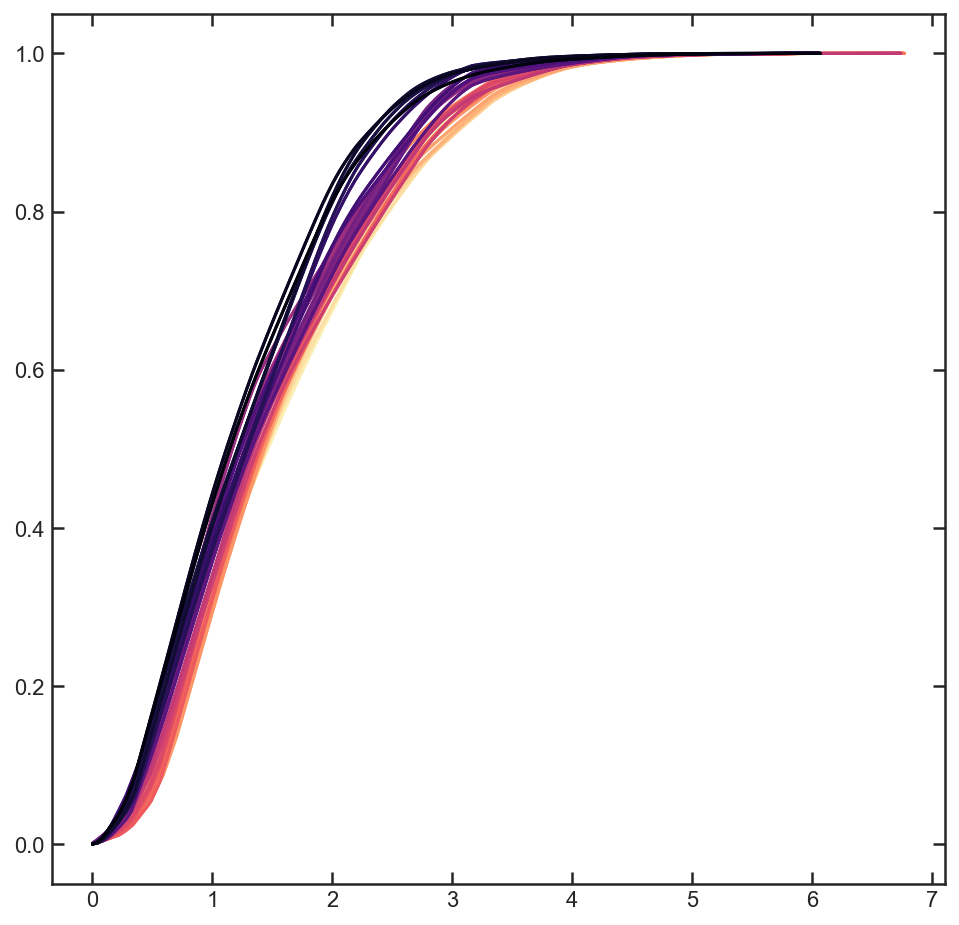

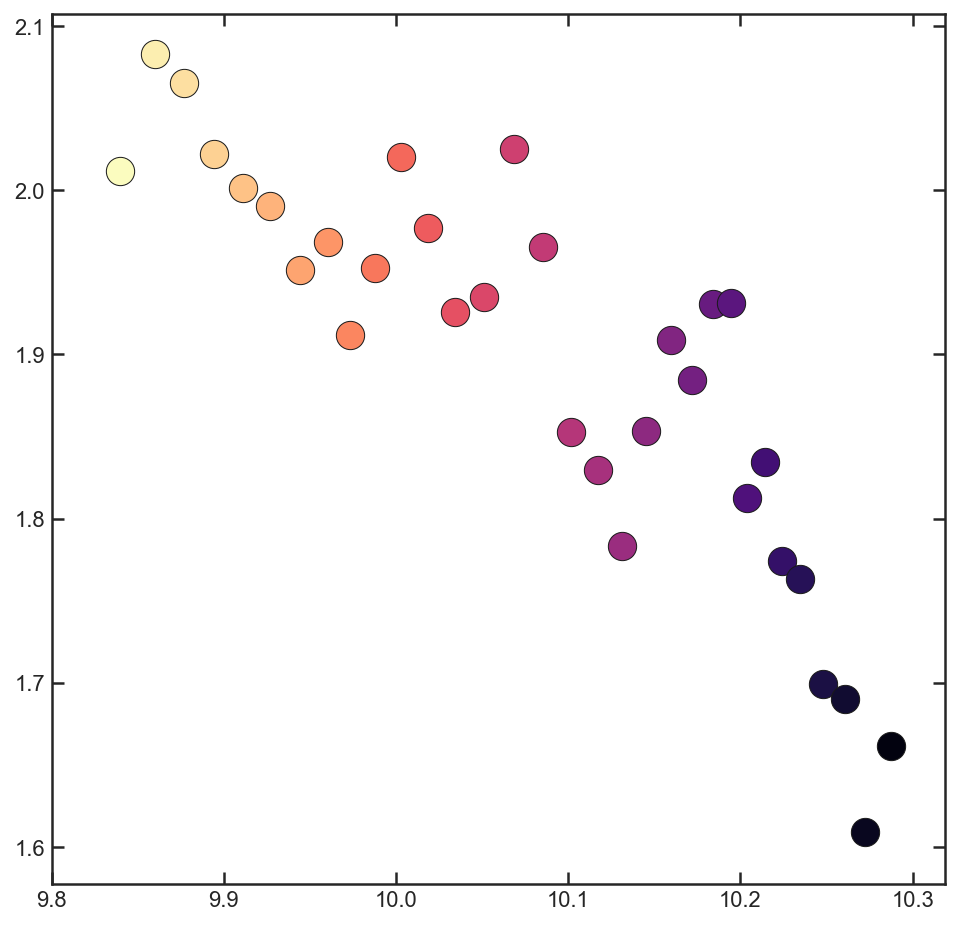

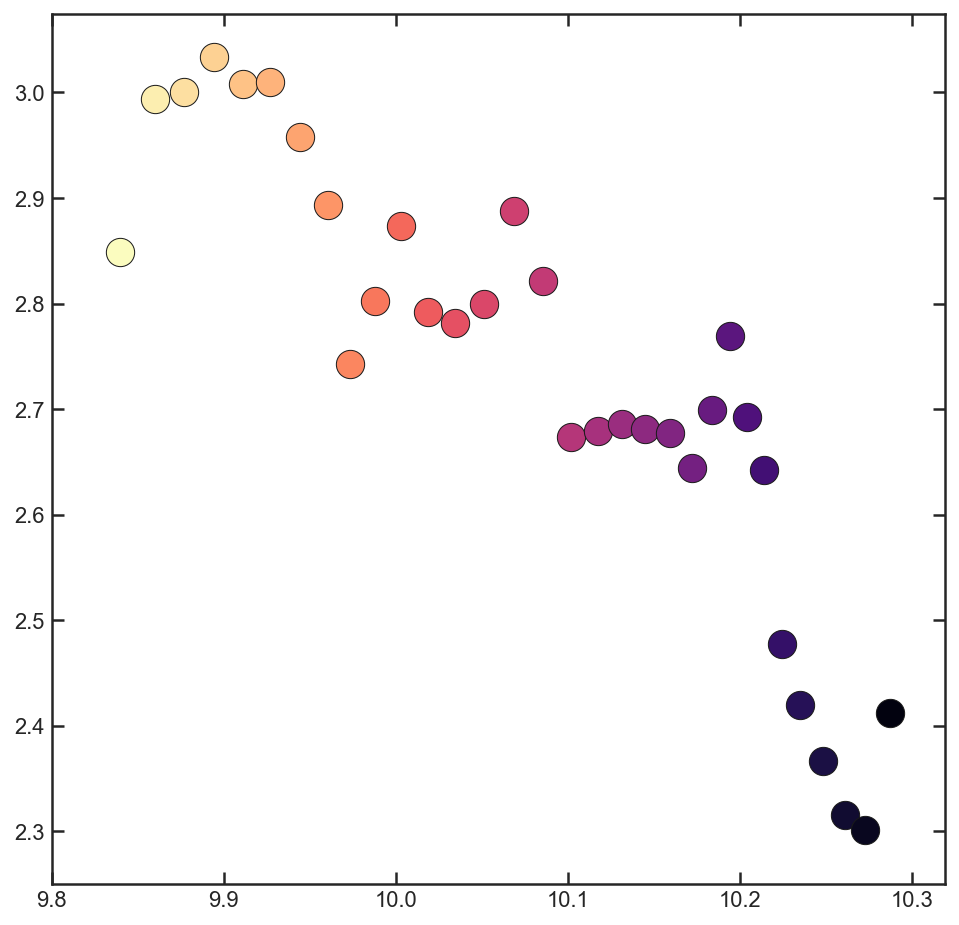

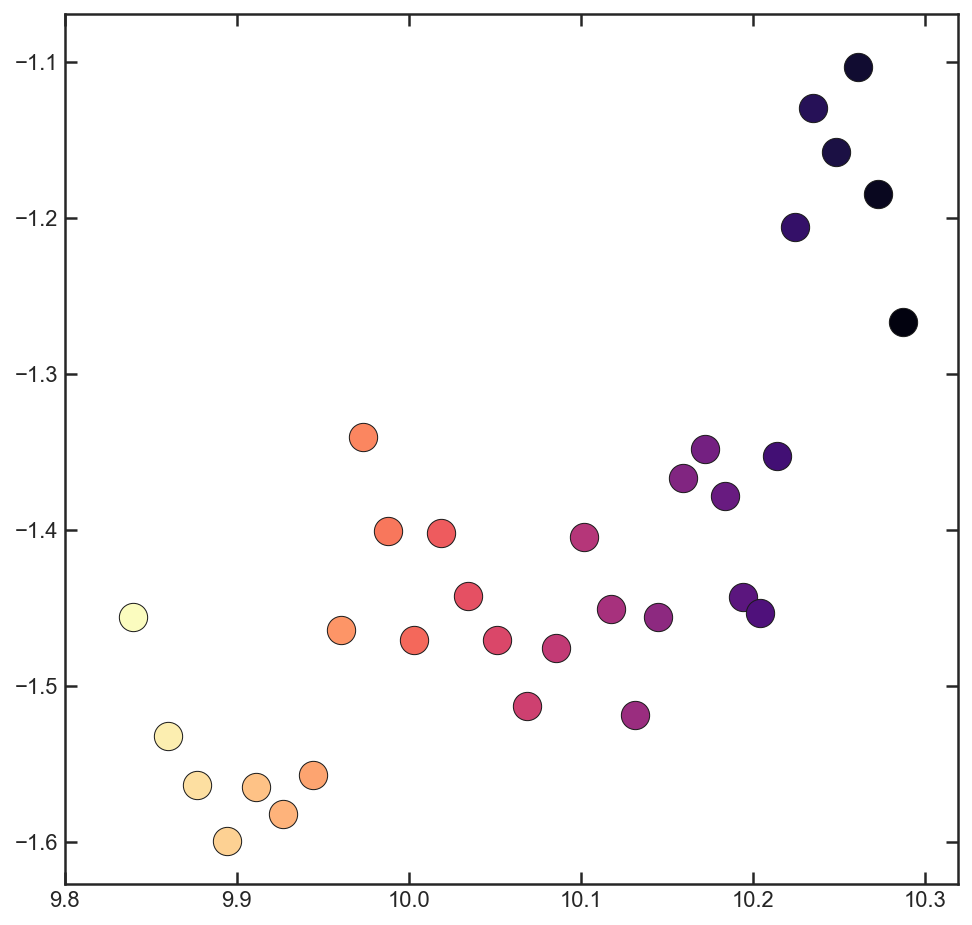

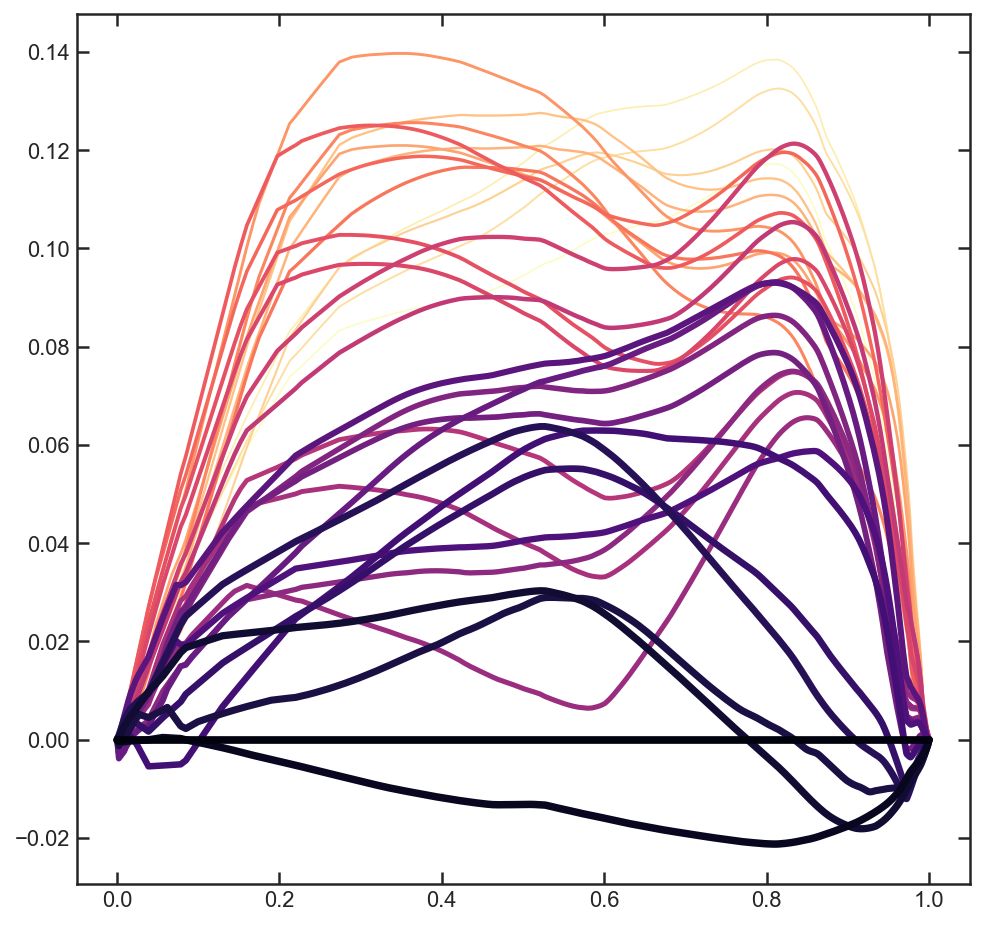

In [464]:
from matplotlib import cm
from matplotlib import colors
#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(L))

plt.figure(figsize = [8,8])
for i in range(len(L)):
    plt.plot(L[i],S[i]/15,color =  np.array(cm.magma_r(norm(i),bytes=True))/255, linewidth = i*0.1+0.75)
plt.xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
plt.xlim(7,14)

plt.figure(figsize = [8,8])
for i in range(len(L)):
    plt.plot(L[i],S[i] / np.trapz(S[i], L[i]), color =  np.array(cm.magma_r(norm(i),bytes=True))/255, linewidth = i*0.1+0.75)
plt.xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
plt.xlim(7,14)

plt.figure(figsize=[8,8])
for i in range(len(L)):
    plt.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255)
    plt.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255)

plt.figure(figsize=[8,8])
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    plt.scatter(np.log10(Sig1[i]),iT(0.7),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, edgecolors='k', linewidths=0.5,s = 200)

            
plt.figure(figsize=[8,8])
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))    
    plt.scatter(np.log10(Sig1[i]),iT(0.9),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, edgecolors='k', linewidths=0.5,s = 200 )

        
plt.figure(figsize=[8,8])
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    
    plt.scatter(np.log10(Sig1[i]),iT(0.5)-iT(0.9),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
                edgecolors='k', linewidths=0.5,s = 200 )
        
        
Lc = L[-1] - min(L[-1])
Sc = np.cumsum(S[-1][::-1]) / np.cumsum(S[-1][::-1])[-1]
iS1 = interp1d(Lc, Sc, bounds_error = False, fill_value =1)(Lc)

plt.figure(figsize=[8,8])
for i in range(len(L)):
    Sc = np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1]
    iS = interp1d(L[i] - min(L[i]), Sc, bounds_error = False, fill_value =1)(Lc)
    plt.plot(iS1,(iS1-iS) ,color =  np.array(cm.magma_r(norm(i),bytes=True))/255, linewidth = i*0.1+0.75)
        

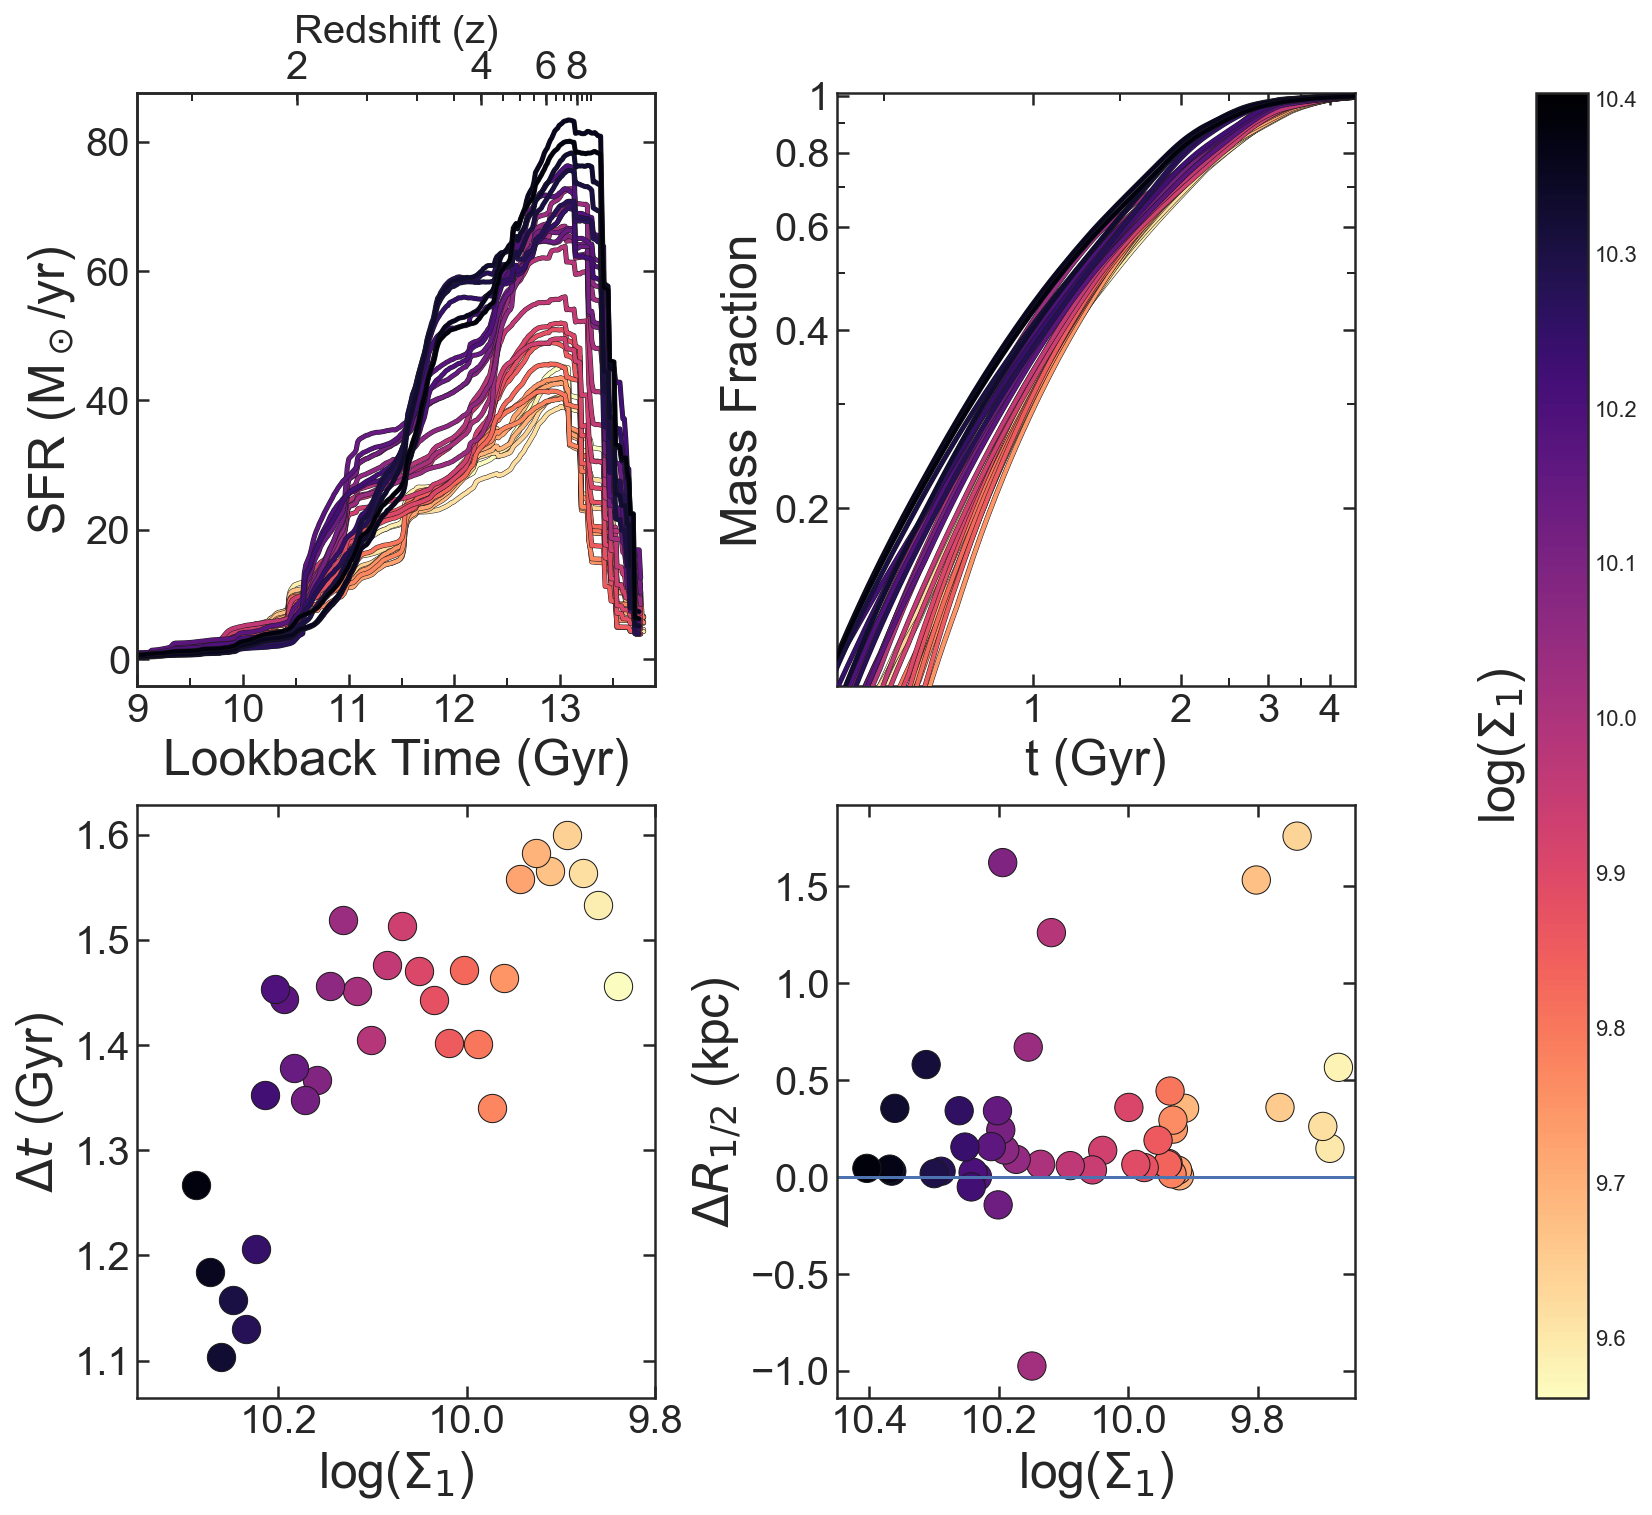

In [472]:
from matplotlib import cm
from matplotlib import colors
#normalize item number values to colormap
norm = colors.Normalize(vmin=0, vmax=len(L))

gs = gridspec.GridSpec(2,3, wspace=0.5, width_ratios=[1,1,0.1])

plt.figure(figsize =[13,12])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[:,2])


######## SFH
idx = 0
for i in range(len(L)):
    ax1.plot(L[i],S[i]/np.trapz(S[i],L[i])*M[i]*1E-9,color =  np.array(cm.magma_r(norm(i),bytes=True))/255, linewidth = 2, zorder = idx+1)
    ax1.plot(L[i],S[i]/np.trapz(S[i],L[i])*M[i]*1E-9,color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1

# ax1.set_ylim(0,130)
ax1.set_xlim(9,13.9)
ax1.set_ylabel('SFR (M$_\odot$/yr)', fontsize=25)
ax1.set_xlabel('Lookback Time (Gyr)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1a = ax1.twiny()
ax1a.set_xlim(ax1.get_xlim())

ax1a.set_xticks(cosmo.lookback_time([2,4,6,8]).value)
ax1a.set_xticklabels([2,4,6,8])
ax1a.set_xticks(cosmo.lookback_time(np.arange(1.5,10,.5)).value, minor=True)

ax1.set_xticks([9,10,11,12,13])
ax1.set_xticks([9.5,10.5,11.5,12.5,13.5], minor = True)

# ax1.set_yticks([25,50,75,100,125])
# ax1.set_yticklabels([10,50,100,150])
# ax1.set_yticks(np.arange(5,130,5), minor = True)
# ax1.set_yticklabels([], minor = True)

ax1a.xaxis.set_ticks_position('top')
ax1a.set_xlabel('Redshift (z)', fontsize=20)
ax1a.tick_params(axis='both', which='major', labelsize=20)

######## C SFH
idx = 0
for i in range(len(L)):
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
             linewidth = 2, zorder = idx + 1)
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1
ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.4,4.5)
ax2.set_ylim(0.1,1.01)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels([1,2,3,4])
ax2.set_xticks([0.5,1.5,2.5,3.5], minor=True)

ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0.3,0.5,0.7,0.9], minor=True)

ax2.tick_params(axis='both', which='major', labelsize=20)

########## delta t    
dt = []
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
#     ax3.errorbar(np.log10(Sig1[i]),iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
#                 color = 'k', zorder =1, elinewidth = 3)
#     ax3.errorbar(np.log10(Sig1[i]),iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
#                 color =  np.array(cm.magma_r(norm(i),bytes=True))/255, zorder =2)
    ax3.scatter(np.log10(Sig1[i]),iT(0.9)-iT(0.5),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
                edgecolors='k', linewidths=0.5,s = 200, zorder =3 )
    

ax3.set_xlim(10.35,9.8)
ax3.set_ylabel('$\Delta t$ (Gyr)', fontsize=25)
ax3.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
# sea.regplot(np.log10(Sig1), dt, ax=ax3, ci=68, order = 1, scatter=False, truncate=True)

    
########### delta R1/2    
norm = colors.Normalize(vmin=0, vmax=len(S1db))

cols= []
idx=0
for i in S1db.index:
    cols.append(np.array(cm.magma_r(norm(idx),bytes=True))/255)
    idx+=1
    
ax4.scatter(np.log10(S1db.Sigma1), S1db.Re_f125 - S1db.Re_f160,color =  cols, edgecolors='k', linewidths=0.5,s = 200 )
ax4.set_xlim(10.45,9.65)
ax4.set_ylabel('$\Delta R_{1/2}$ (kpc)', fontsize=25)
ax4.set_xlabel('log($\Sigma_1$)', fontsize=25)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax4.axhline(0)

cmap = 'magma_r'
norm = mpl.colors.Normalize(vmin=min(np.log10(S1db.Sigma1)), vmax = max(np.log10(S1db.Sigma1)))
mpl.colorbar.ColorbarBase(ax5, cmap = cmap, norm=norm, orientation='vertical')
ax5.set_ylabel('log($\Sigma_1$)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
ax5.yaxis.set_label_position('left')
plt.savefig('../plots/sfh_dt.pdf', bbox_inches = 'tight')

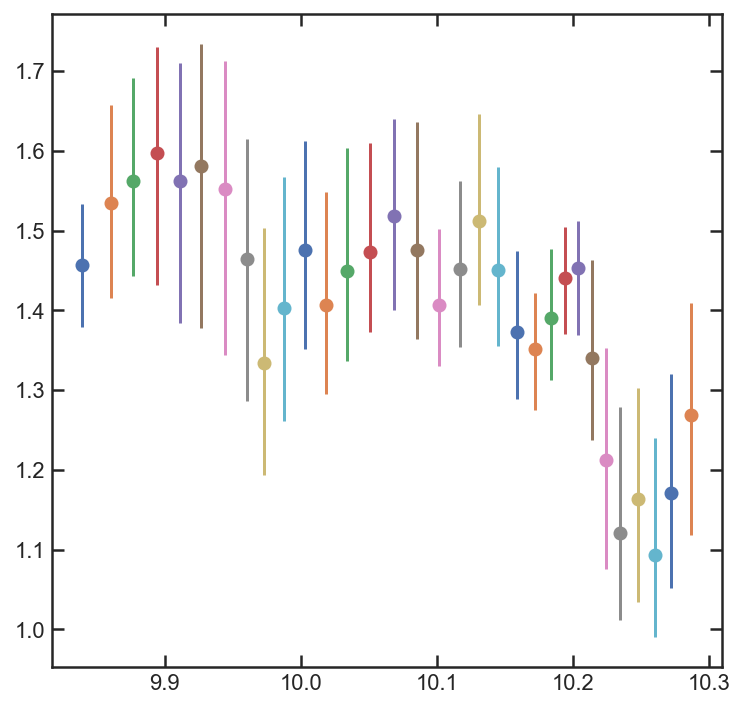

In [469]:
plt.figure(figsize=[6,6])
ax2 = plt.subplot()
for i in range(len(L)):
    ax2.errorbar(np.log10(Sig1[i]), DT[i], yerr = [[DT[i]-DTl[i]],[DTh[i]-DT[i]]], fmt='o')


In [475]:
r50 = []
r90 = []

for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    r50.append(iT(.50))
    r90.append(iT(.90))    

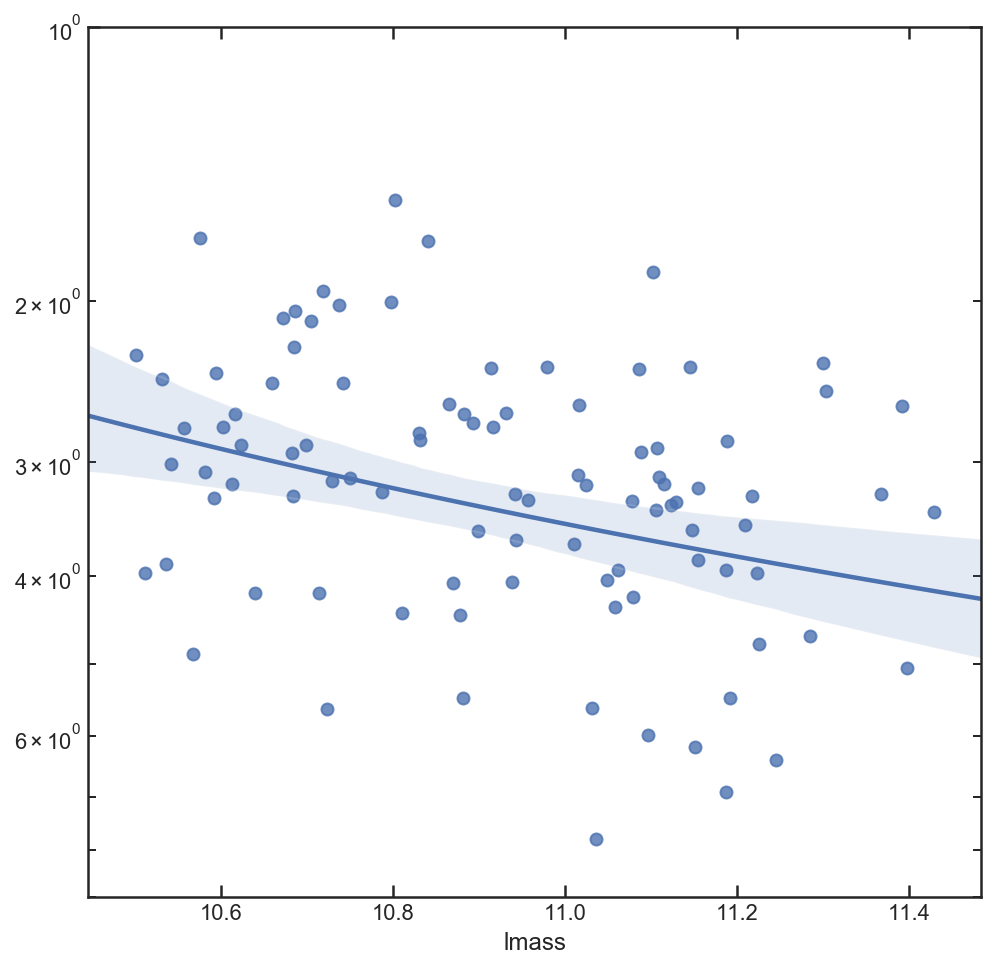

In [499]:
plt.figure(figsize=[8,8])
# sea.scatterplot(mdb.lmass, mdb.z_50)

formz = [z_at_value(cosmo.lookback_time,(cosmo.lookback_time(mdb.zgrism[U]).value + mdb.mwa[U])*u.Gyr) for U in mdb.index]

sea.regplot(mdb.lmass, formz)

plt.ylim(9,1)
plt.yscale('log')

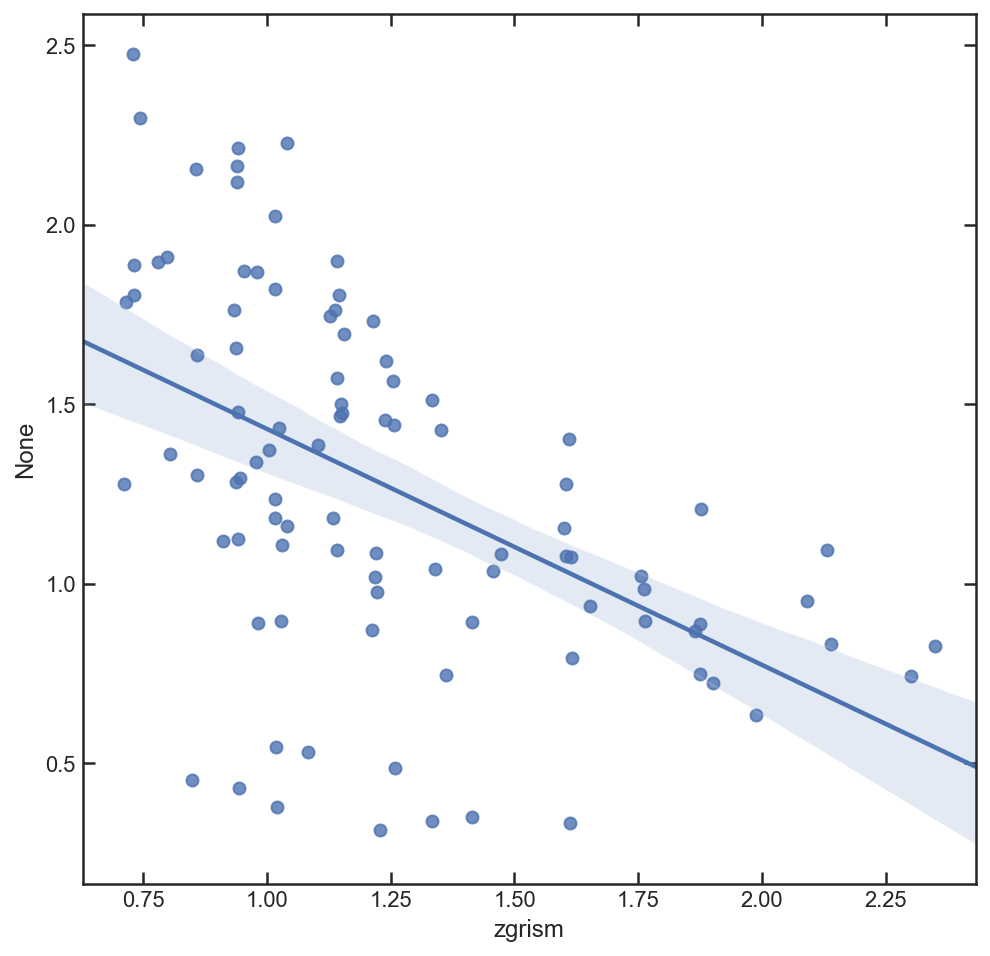

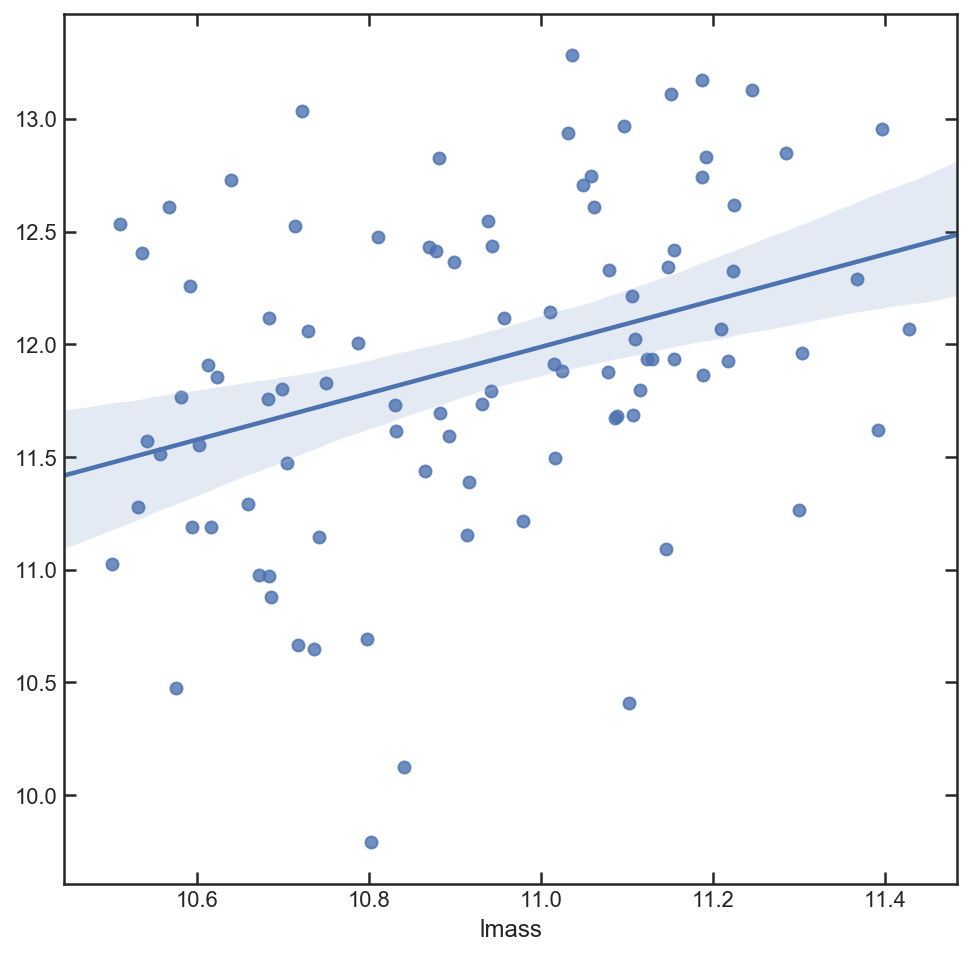

In [510]:
plt.figure(figsize=[8,8])
sea.regplot(mdb.zgrism, mdb.t_50 - mdb.t_90)

plt.figure(figsize=[8,8])
sea.regplot(mdb.lmass, cosmo.lookback_time(mdb.z_50))

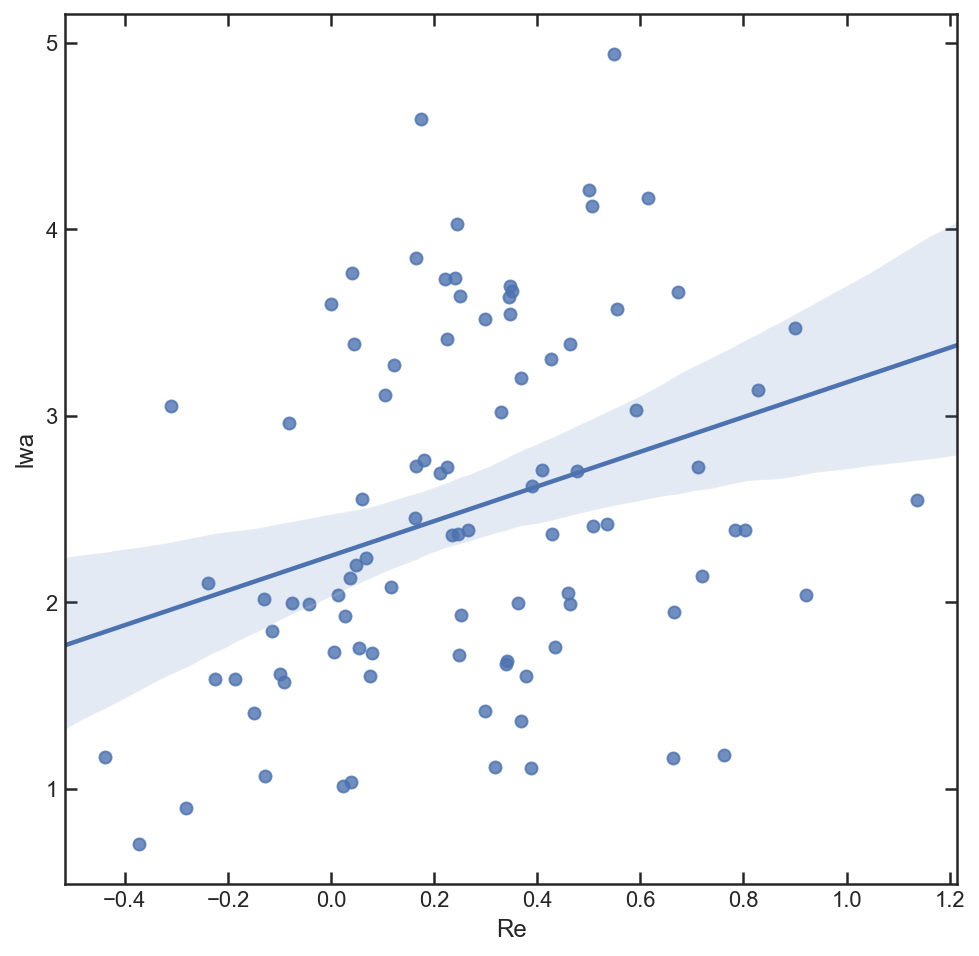

In [523]:
plt.figure(figsize=[8,8])
sea.regplot(np.log10(mdb.Re), mdb.lwa)

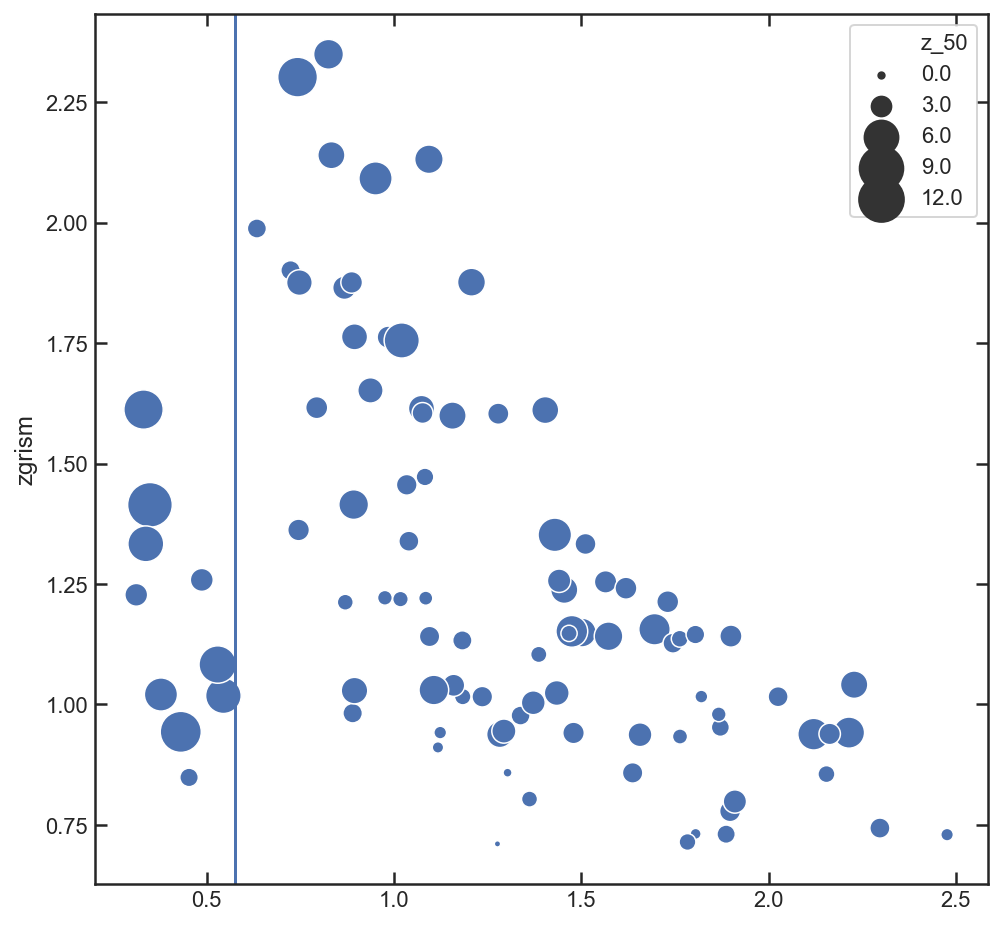

In [588]:

# plt.figure(figsize=[8,8])

# sea.scatterplot(mdb.VJ, mdb.UV,marker = 'o', size=mdb.log_ssfr, sizes=(10,500))


# plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
# plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
# plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)

# plt.xlabel('V-J (mag)', fontsize=25)
# plt.ylabel('U-V (mag)', fontsize=25)
# plt.tick_params(axis='both', which='major', labelsize=20)


# plt.figure(figsize=[8,8])

# sea.scatterplot(mdb.lmass, np.log10(mdb.Re),marker = 'o', size=mdb.log_ssfr, sizes=(10,500))
# sea.scatterplot(mdb.query('UV < 1.7').lmass, np.log10(mdb.query('UV < 1.7').Re),marker = 'o', size=mdb.query('UV < 1.7').log_ssfr, sizes=(10,500))

plt.figure(figsize=[8,8])

sea.scatterplot(mdb.t_50 - mdb.t_90,mdb.zgrism, size=mdb.z_50, sizes=(10,500))
# sea.scatterplot(mdb.query('UV < 1.7').zgrism, mdb.query('UV < 1.7').t_50 - mdb.query('UV < 1.7').t_90,marker = 'o'
#                 , size=mdb.query('UV < 1.7').UV, sizes=(10,500))
plt.axvline(0.575)

In [589]:
lbt, sfh = np.load('../data/SFH/GND_21156.npy')

(30000, 0)

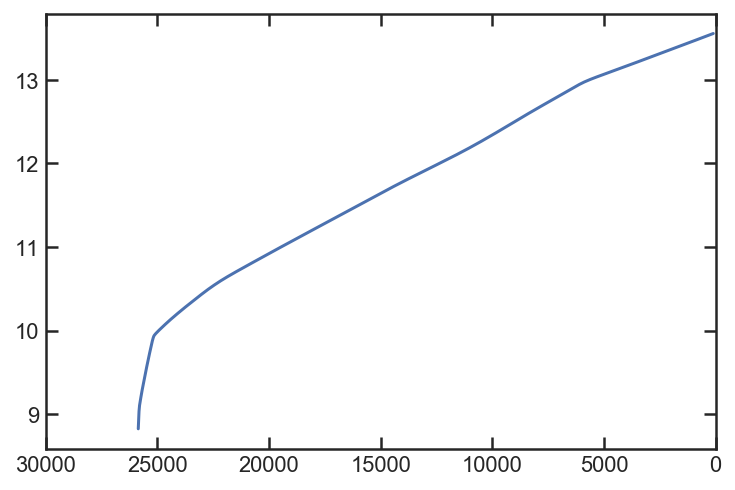

In [604]:
plt.plot(np.cumsum(sfh[::-1])[::-1],lbt + cosmo.lookback_time(1.25).value)
plt.xlim(30000,0)

In [31]:
cols = np.loadtxt('../data/plot_points/schreiber_table3.dat.txt', skiprows=4, dtype =str, delimiter='|', )[0]
dat = np.loadtxt('../data/plot_points/schreiber_table3.dat.txt', skiprows=4, dtype =str, delimiter='|', )[2:].T

In [43]:
cols, cols[3], cols[12], cols[24]

(array(['ID          ', '     RAdeg       DEdeg', 'z', '    z', '   e_z',
        '   E_z', ' U-V', '_U-V', '_U-V', ' V-J', '_V-J', '_V-J', 'Mass',
        'Mass', 'Mass', ' Av', '_Av', '_Av', '  SFR', 'e_SFR', 'E_SFR',
        '  tq', 'e_tq', 'E_tq', '  zf', 'e_zf', 'E_zf', ' tsf', '_tsf',
        '_tsf', 'SFRp', 'SFRp', '  E_'], dtype='<U22'),
 '    z',
 'Mass',
 '  zf')

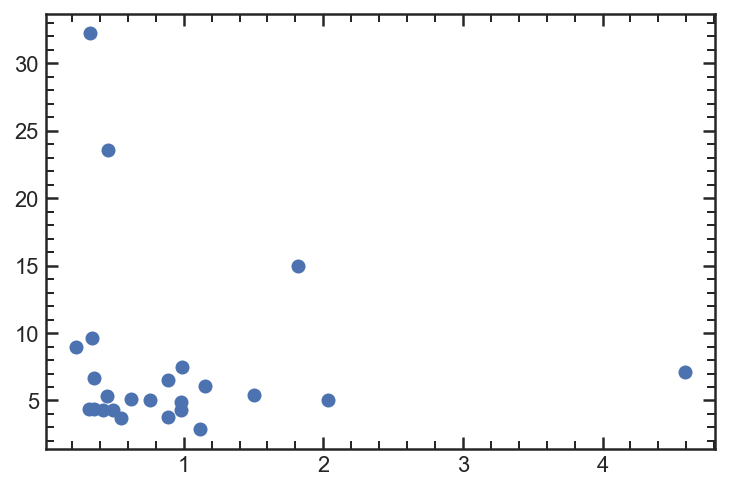

In [44]:
plt.plot(dat[12].astype(float),dat[24].astype(float), 'o')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


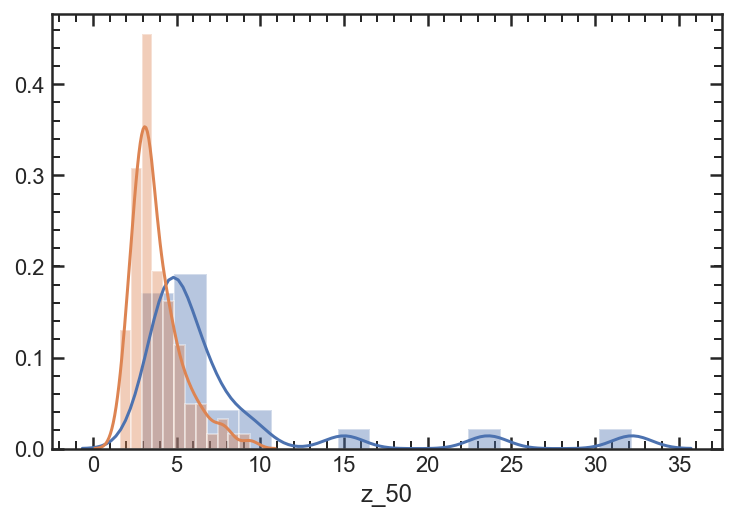

In [46]:
sea.distplot(dat[24].astype(float))
sea.distplot(mdb.z_50)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


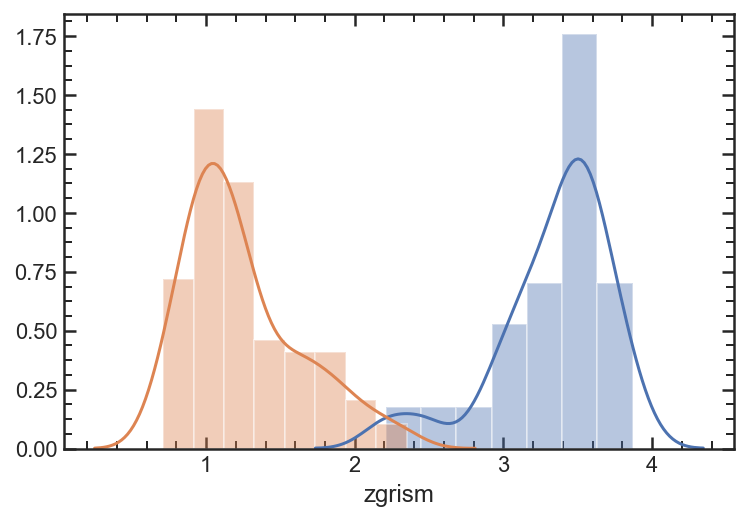

In [47]:
sea.distplot(dat[3].astype(float))
sea.distplot(mdb.zgrism)

In [479]:
print(max(r50) - min(r50), max(r90) - min(r90), max(r90) ,min(r90))

0.34520993079981177 0.7328573638999454 3.0339120703074176 2.3010547064074722


(7, 14)

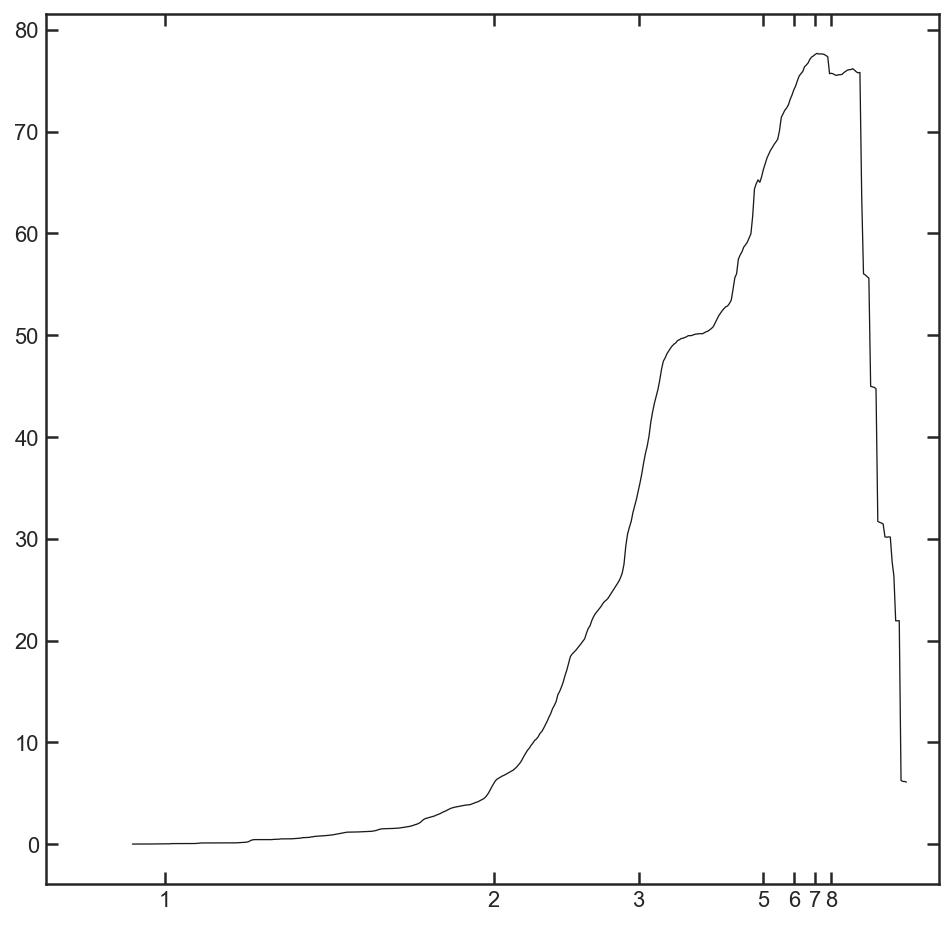

In [462]:
norm = colors.Normalize(vmin=0, vmax=len(L))

# plt.figure(figsize = [8,8])
# for i in range(len(L)):
#     plt.plot(L[i],S[i],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, linewidth = i*0.1+0.75)
# plt.xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
# plt.xlim(7,14)


plt.figure(figsize = [8,8])
i=-1
plt.plot(L[i],S[i]/np.trapz(S[i],L[i])*M[i]*1E-9,color =  'k', linewidth = i*0.1+0.75)
# plt.fill_between(L[i],Sl[i]/np.trapz(S[i]/L[i]),Sh[i]/np.trapz(S[i]/L[i]),color = 'k')

plt.xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
plt.xlim(7,14)


In [435]:
np.trapz(S[i],L[i])

2062.1728436002936

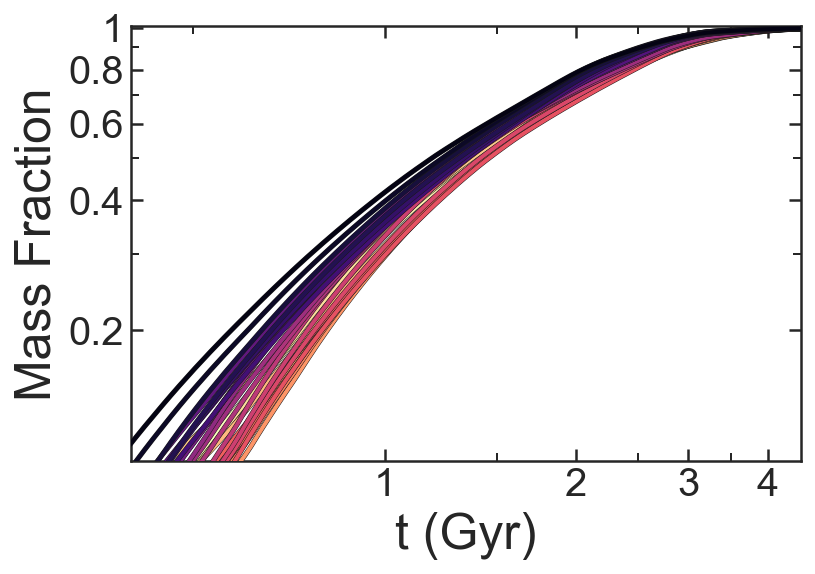

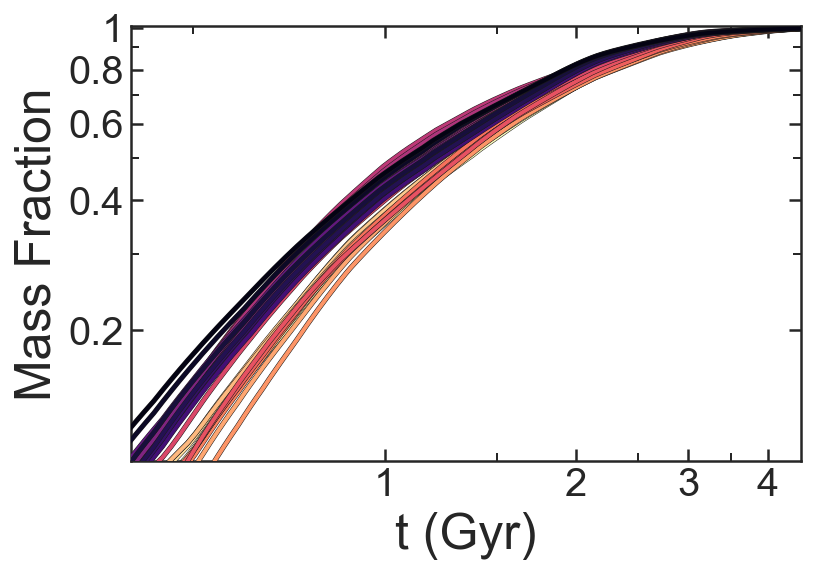

In [425]:
plt.figure()
ax2 = plt.subplot()

idx = 0
for i in range(len(L)):
    ax2.plot(L2[i] - min(L2[i]), np.cumsum(S2[i][::-1]) / np.cumsum(S2[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
             linewidth = 2, zorder = idx + 1)
    ax2.plot(L2[i] - min(L2[i]), np.cumsum(S2[i][::-1]) / np.cumsum(S2[i][::-1])[-1],color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1
ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.4,4.5)
ax2.set_ylim(0.1,1.01)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels([1,2,3,4])
ax2.set_xticks([0.5,1.5,2.5,3.5], minor=True)

ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0.3,0.5,0.7,0.9], minor=True)

ax2.tick_params(axis='both', which='major', labelsize=20)      

plt.figure()
ax2 = plt.subplot()

idx = 0
for i in range(len(L)):
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
             linewidth = 2, zorder = idx + 1)
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1
ax2.set_ylabel('Mass Fraction', fontsize=25)
ax2.set_xlabel('t (Gyr)', fontsize=25)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.4,4.5)
ax2.set_ylim(0.1,1.01)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels([1,2,3,4])
ax2.set_xticks([0.5,1.5,2.5,3.5], minor=True)

ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0.3,0.5,0.7,0.9], minor=True)

ax2.tick_params(axis='both', which='major', labelsize=20)   

In [457]:
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    dt_bs = []
    w = Leave_one_out(np.array(sfh), lbt)
    wsfh = [w[U]*sfh[U] for U in range(len(sfh))]
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))            
        S= np.sum(np.array(wsfh)[IDX], axis=0)
#         S= np.sum(np.array(sfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)
        iT = interp1d(np.cumsum(istack[::-1]) / np.cumsum(istack[::-1])[-1], lbt - min(lbt))
        dt_bs.append(iT(0.9) - iT(0.5))
        
    sfh_bs = np.array(sfh_bs)
    dt_bs = np.array(dt_bs)
    
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    DT = np.percentile(dt_bs,50)
    DT16 = np.percentile(dt_bs,16)
    DT84 = np.percentile(dt_bs,84)
            
    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84, DT, DT16, DT84

(6, 14)

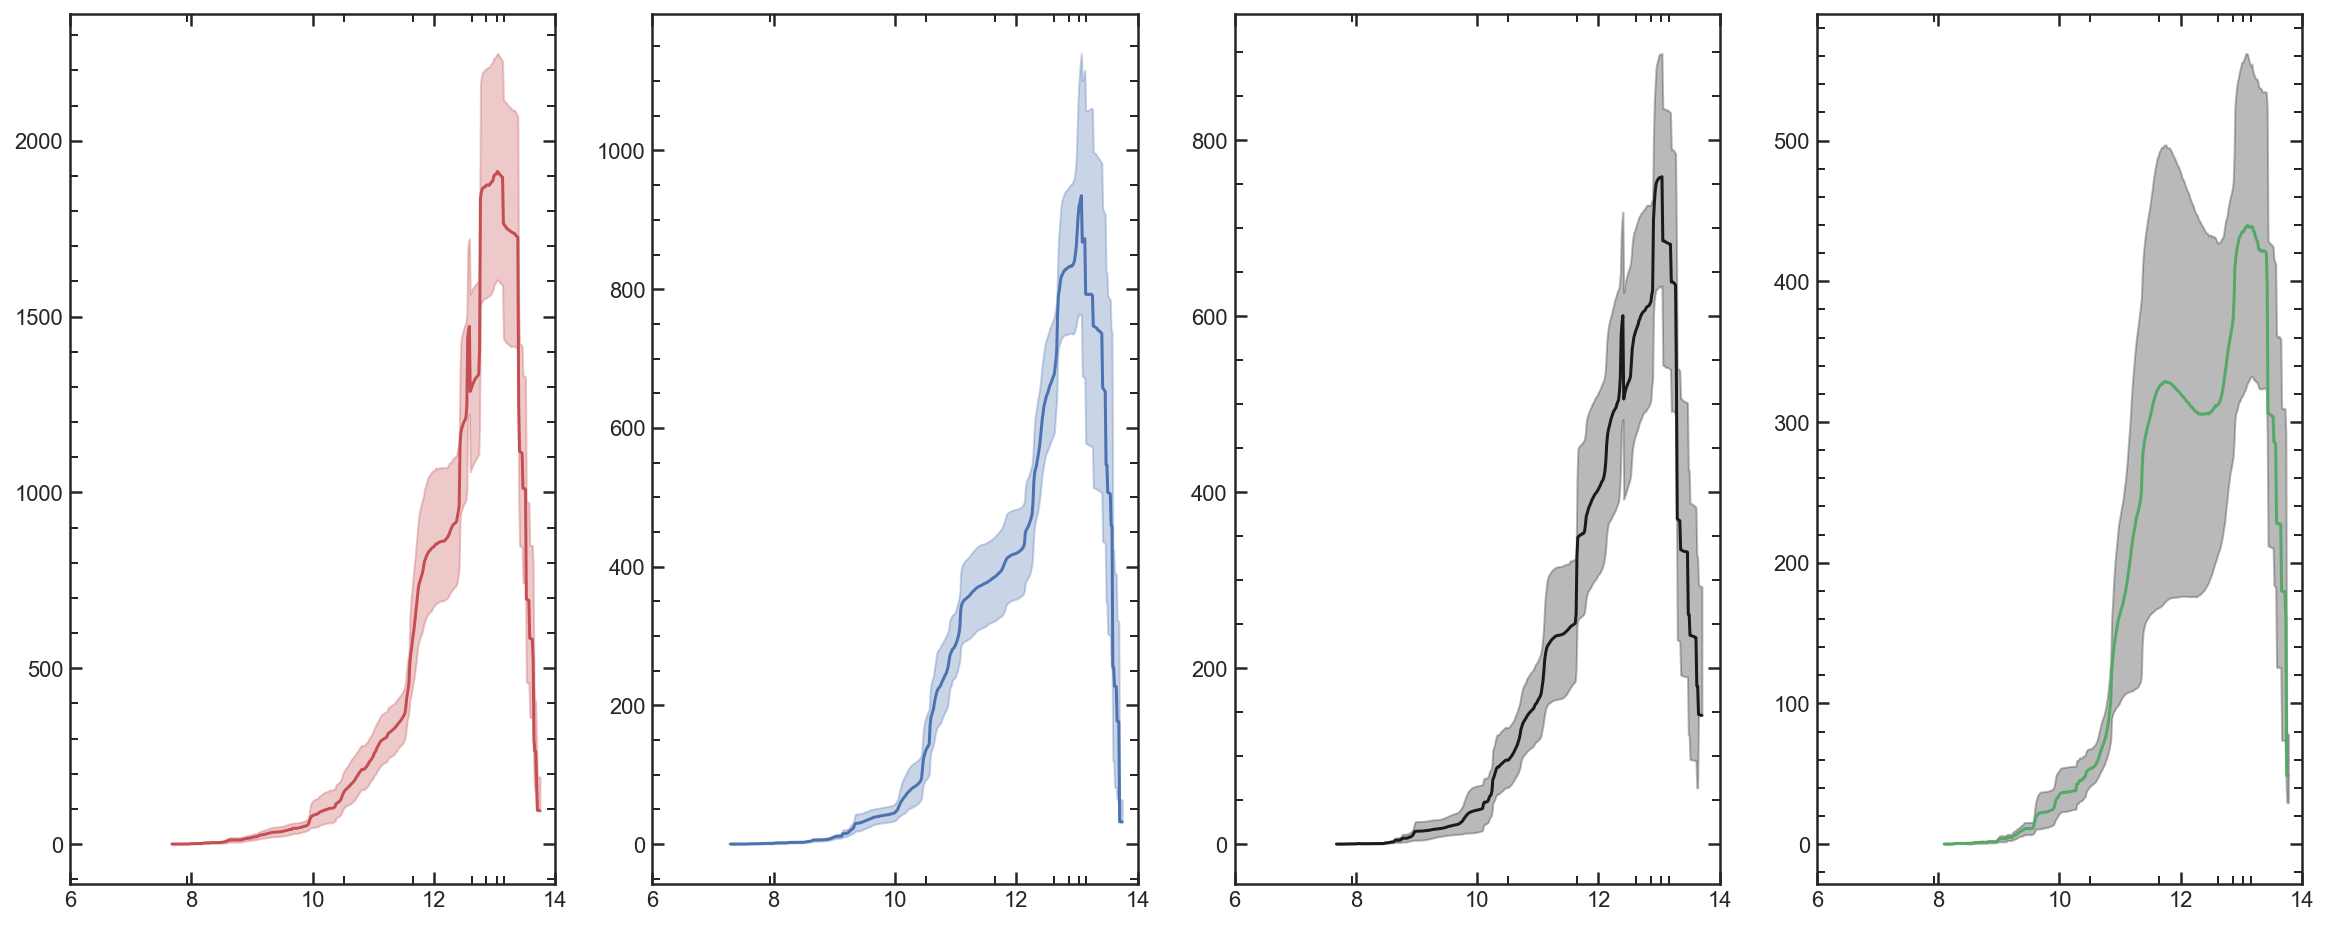

In [158]:
gs = gridspec.GridSpec(1,4)
plt.figure(figsize=[20,8])
ax1=plt.subplot(gs[0])
ax2=plt.subplot(gs[1])
ax3=plt.subplot(gs[2])
ax4=plt.subplot(gs[3])

LBT = np.linspace(0,14, 1000)

SFH_grid = []
for i in mdb.query('Sigma1 > 10**10.2 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh)

L1,S1,S16,S84 = Sum_SFH_bs(LBT, SFH_grid)
ax1.plot(L1, S1 , color = 'r')
ax1.fill_between(L1,S16,S84, alpha = 0.3, color = 'r')
ax1.set_xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
ax1.set_xlim(6,14)

SFH_grid = []
for i in mdb.query('10**10 < Sigma1 < 10**10.2 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh)

L2,S2,S16,S84 = Sum_SFH_bs(LBT, SFH_grid)
ax2.plot(L2, S2 , color = 'b')
ax2.fill_between(L2,S16,S84, alpha = 0.3, color = 'b')
ax2.set_xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
ax2.set_xlim(6,14)

SFH_grid = []
for i in mdb.query('10**9.8 < Sigma1 < 10**10 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh)

L3,S3,S16,S84 = Sum_SFH_bs(LBT, SFH_grid)
ax3.plot(L3, S3, color = 'k')
ax3.fill_between(L3,S16,S84, alpha = 0.3, color = 'k')
ax3.set_xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
ax3.set_xlim(6,14)

SFH_grid = []
for i in mdb.query('Sigma1 < 10**9.8 and z_50 > 3.4').index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(mdb.field[i], mdb.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(mdb.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh)

L4,S4,S16,S84 = Sum_SFH_bs(LBT, SFH_grid)
ax4.plot(L4, S4, color = 'g')
ax4.fill_between(L4,S16,S84, alpha = 0.3, color = 'k')
ax4.set_xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
ax4.set_xlim(6,14)

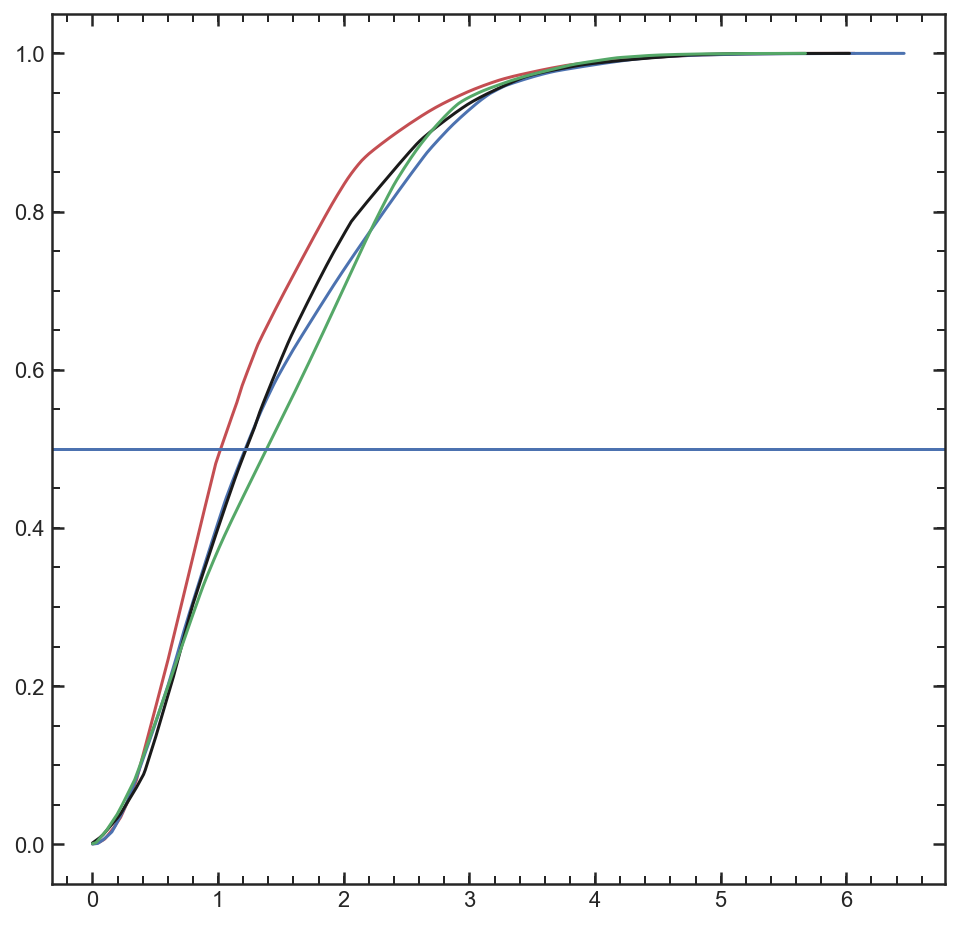

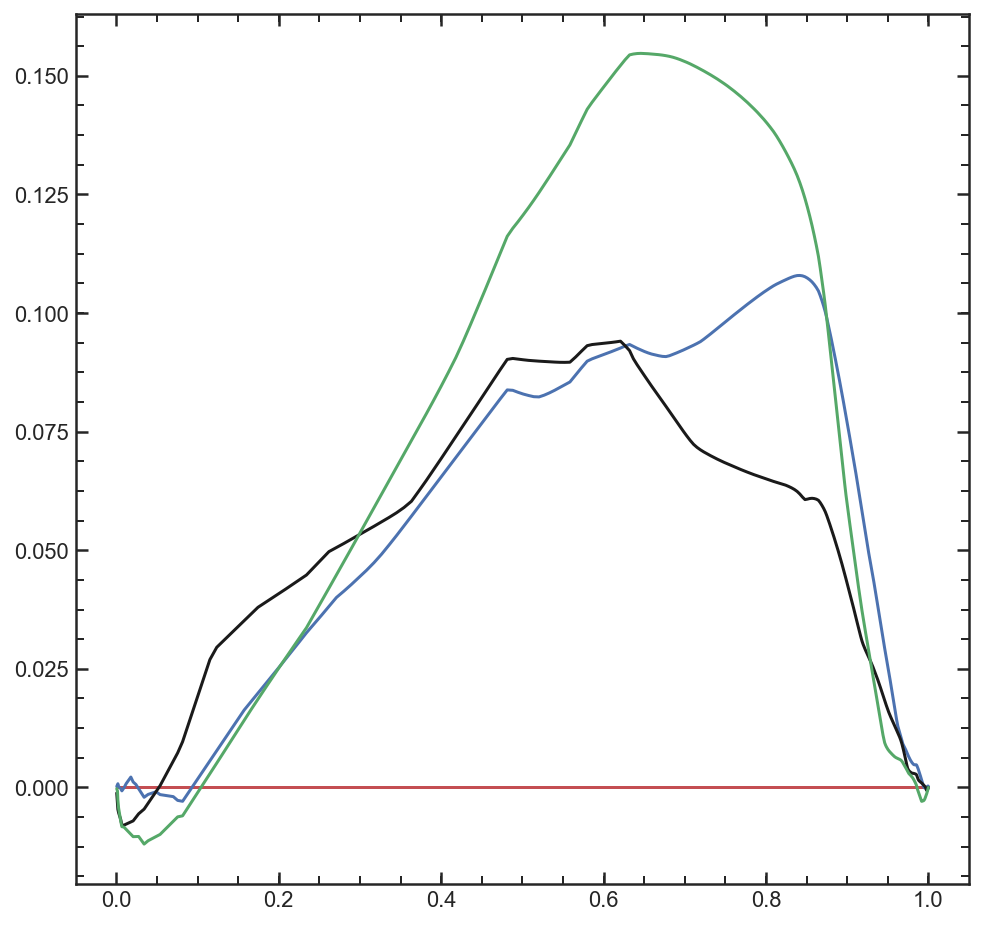

In [161]:
plt.figure(figsize=[8,8])
plt.plot(L1 - min(L1), np.cumsum(S1[::-1]) / np.cumsum(S1[::-1])[-1], color = 'r')
plt.plot(L2 - min(L2), np.cumsum(S2[::-1]) / np.cumsum(S2[::-1])[-1], color = 'b')
plt.plot(L3 - min(L3), np.cumsum(S3[::-1]) / np.cumsum(S3[::-1])[-1], color = 'k')
plt.plot(L4 - min(L4), np.cumsum(S4[::-1]) / np.cumsum(S4[::-1])[-1], color = 'g')

plt.axhline(0.5)

L = L2 - min(L2)
Sc1 = np.cumsum(S1[::-1]) / np.cumsum(S1[::-1])[-1]
Sc2 = np.cumsum(S2[::-1]) / np.cumsum(S2[::-1])[-1]
Sc3 = np.cumsum(S3[::-1]) / np.cumsum(S3[::-1])[-1]
Sc4 = np.cumsum(S4[::-1]) / np.cumsum(S4[::-1])[-1]

iS1 = interp1d(L1 - min(L1), Sc1, bounds_error = False, fill_value =1)(L)
iS2 = interp1d(L2 - min(L2), Sc2, bounds_error = False, fill_value =1)(L)
iS3 = interp1d(L3 - min(L3), Sc3, bounds_error = False, fill_value =1)(L)
iS4 = interp1d(L4 - min(L4), Sc4, bounds_error = False, fill_value =1)(L)

plt.figure(figsize=[8,8])
plt.plot(iS1,(iS1-iS1), color = 'r')
plt.plot(iS1,(iS1-iS2), color = 'b')
plt.plot(iS1,(iS1-iS3), color = 'k')
plt.plot(iS1,(iS1-iS4), color = 'g')

# plt.axvline(0.5)

In [221]:
(L1 - min(L1))[:3],(L2 - min(L2))[:3],(L3 - min(L3))[:3],L[:3]

(array([0.        , 0.01401401, 0.02802803]),
 array([0.        , 0.01401401, 0.02802803]),
 array([0.        , 0.01401401, 0.02802803]),
 array([0.        , 0.01401401, 0.02802803]))

In [58]:
LBT = np.linspace(0,14, 1000)

SFH_grid = []  
for i in S1db.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH_grid.append(isfh)
La,Sa,S16,S84 = Stack_SFH_bs(LBT, SFH_grid, its=500)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


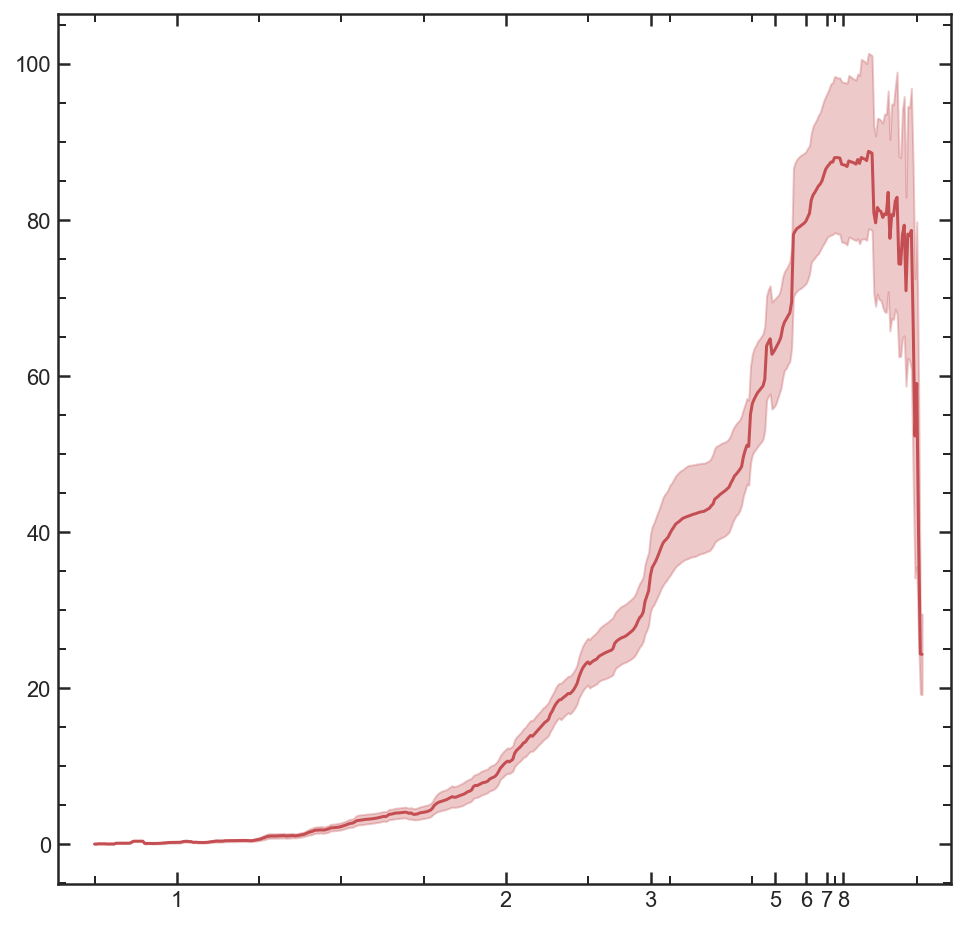

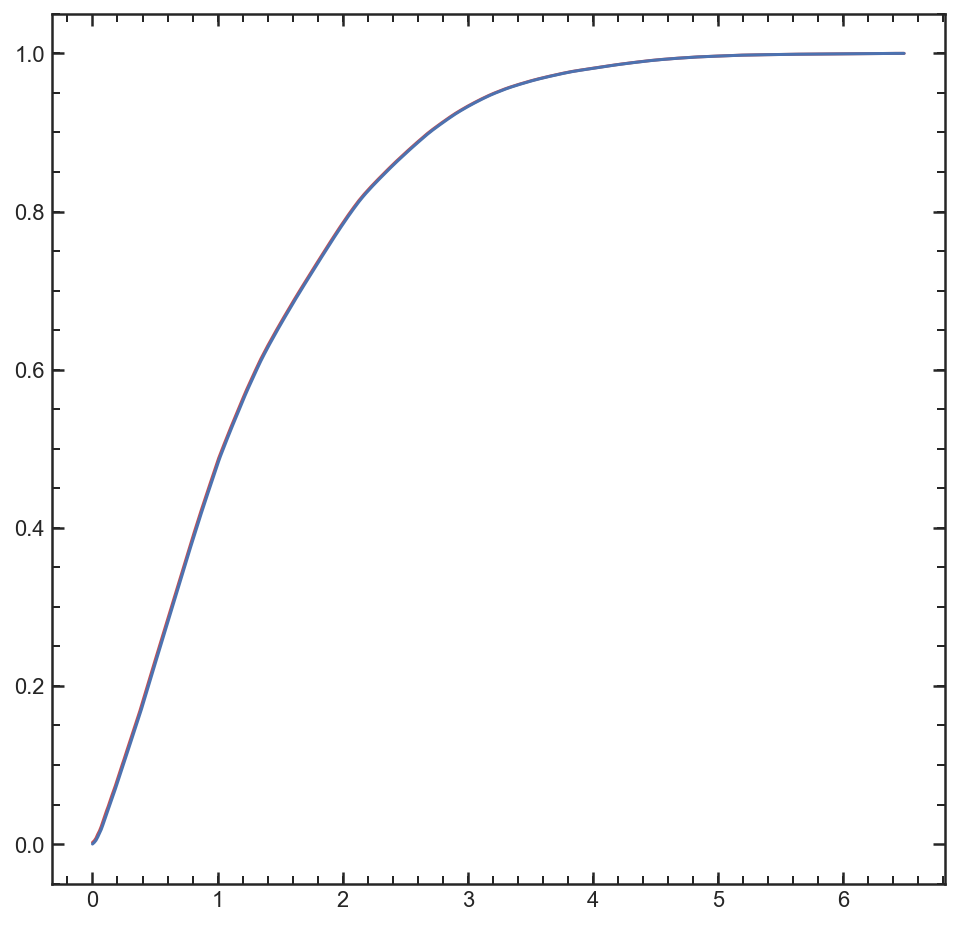

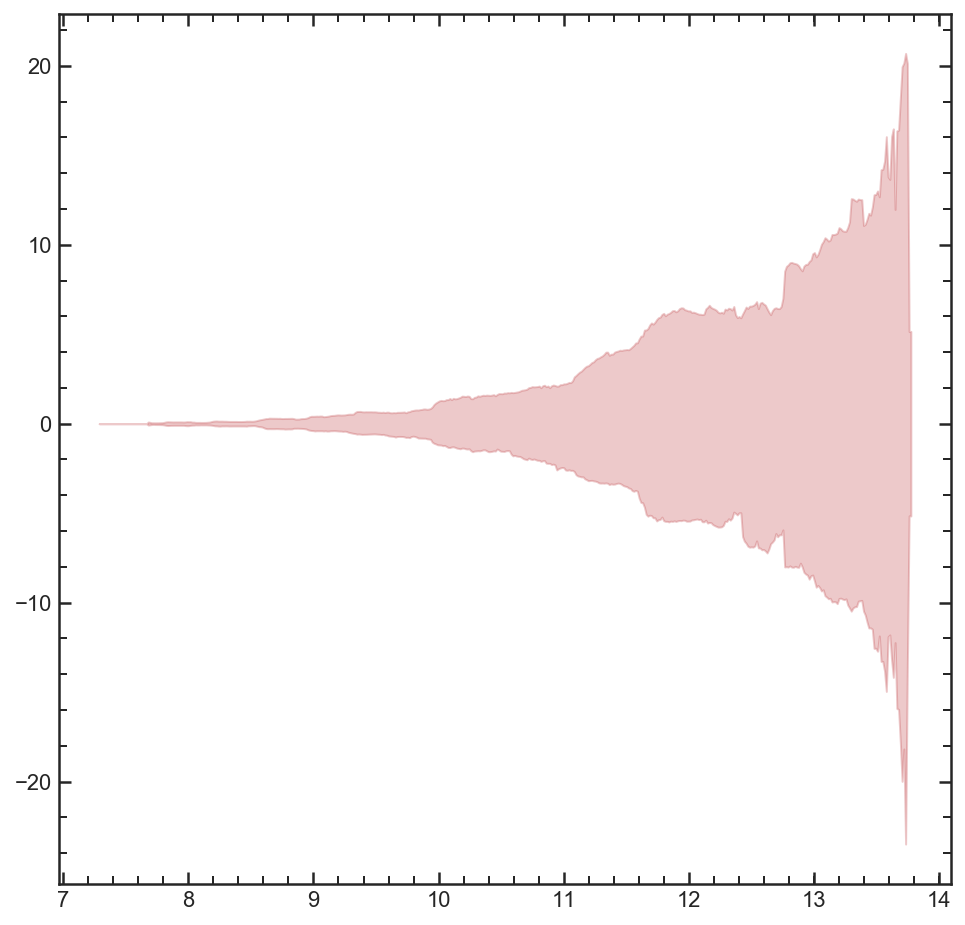

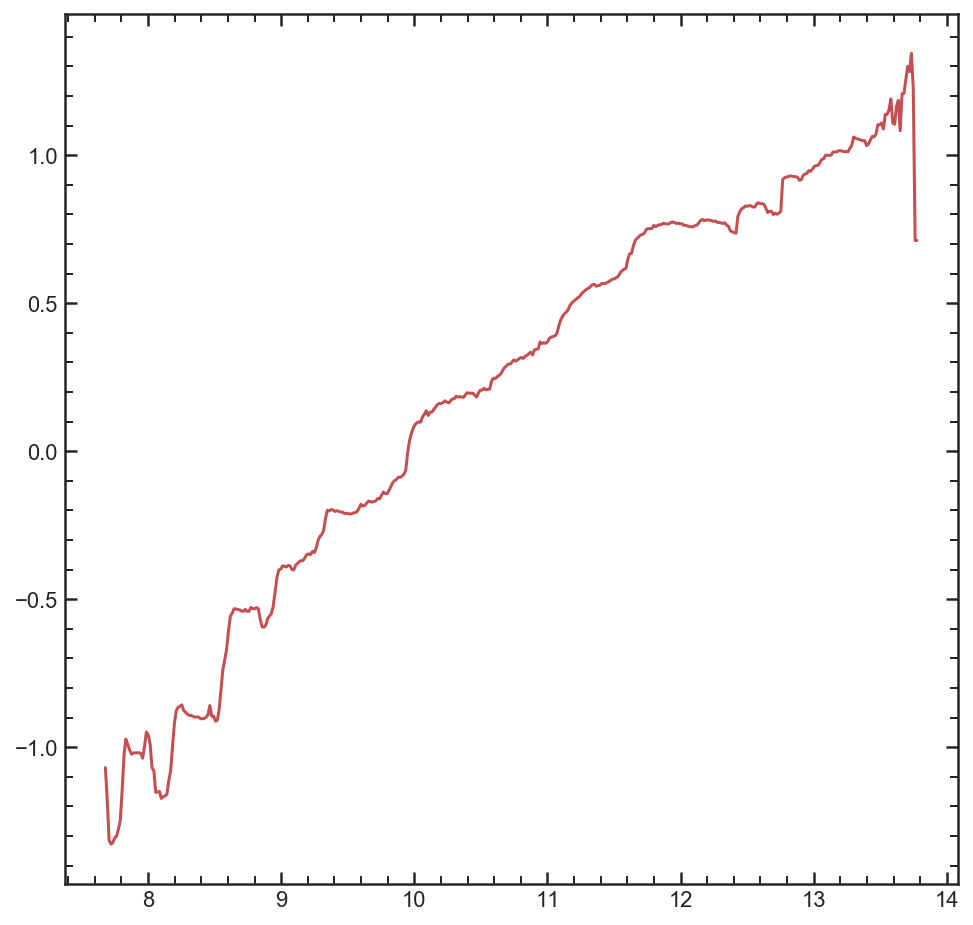

In [133]:
plt.figure(figsize=[8,8])
plt.plot(La, Sa, color = 'r')
plt.fill_between(La,S16,S84, alpha = 0.3, color = 'r')
plt.xticks(cosmo.lookback_time([1,2,3,5,6,7,8]).value,[1,2,3,5,6,7,8] )
plt.xlim(7,14)



plt.figure(figsize=[8,8])
plt.plot(La - min(La), np.cumsum(Sa[::-1]) / max(np.cumsum(Sa[::-1])), color = 'r')

Ls = La - min(La)
nSa = Sa[::-1] / np.trapz(Sa, La)

M =[0]
for i in range(len(Ls)-1):
    M.append(np.trapz(nSa[:i+2], Ls[:i+2]))
plt.plot(Ls, M)

plt.figure(figsize=[8,8])
plt.fill_between(La, S16-Sa, S84-Sa, alpha = 0.3, color = 'r')

plt.figure(figsize=[8,8])
plt.plot(La,np.log10((S84-Sa + Sa-S16)/2), color = 'r')

(0, 15)

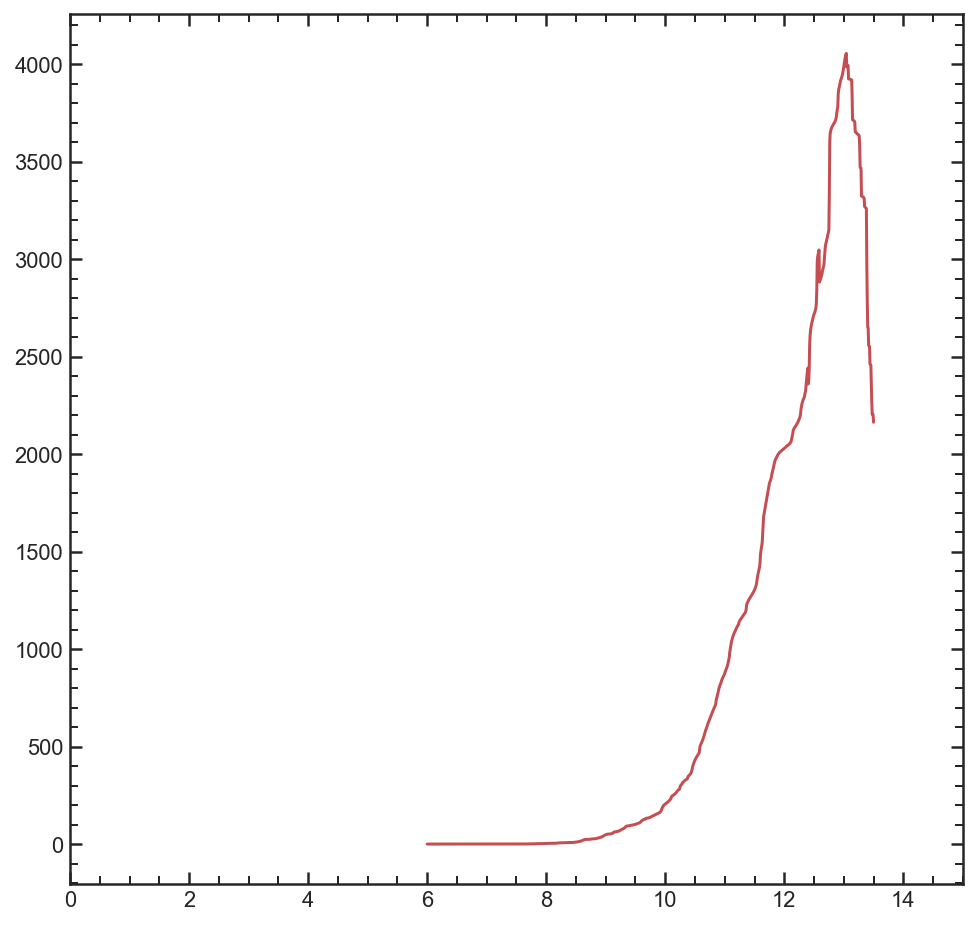

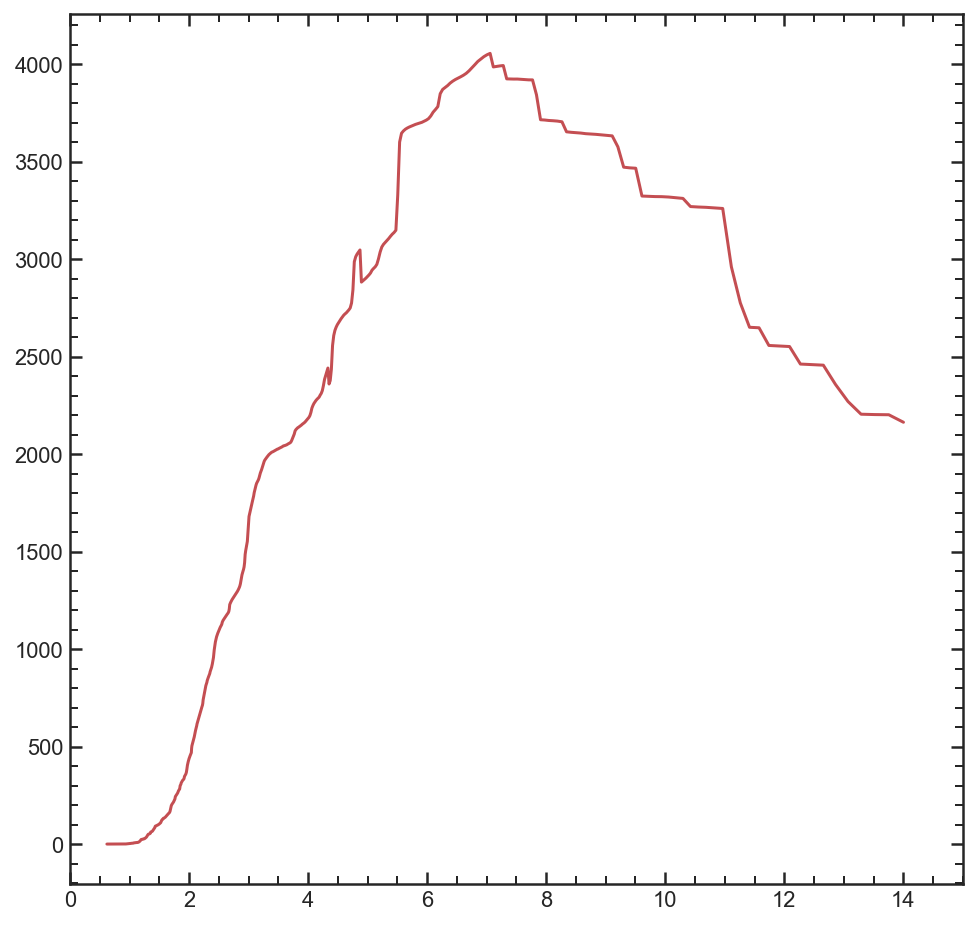

In [147]:
LBT = np.linspace(6,13.5, 1000)

SFH = np.zeros_like(LBT)  
for i in S1db.index:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
    isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
    SFH+=isfh

plt.figure(figsize=[8,8])
plt.plot(LBT, SFH, color = 'r')
plt.xlim(0,15)
    
zl = [z_at_value(cosmo.lookback_time, U*u.Gyr) for U in LBT]
plt.figure(figsize=[8,8])
plt.plot(zl, SFH, color = 'r')
plt.xlim(0,15)


In [145]:
SFH[-27:], LBT[-27:]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([13.79179179, 13.7997998 , 13.80780781, 13.81581582, 13.82382382,
        13.83183183, 13.83983984, 13.84784785, 13.85585586, 13.86386386,
        13.87187187, 13.87987988, 13.88788789, 13.8958959 , 13.9039039 ,
        13.91191191, 13.91991992, 13.92792793, 13.93593594, 13.94394394,
        13.95195195, 13.95995996, 13.96796797, 13.97597598, 13.98398398,
        13.99199199, 14.        ]))

# $z_{50}$ histogram

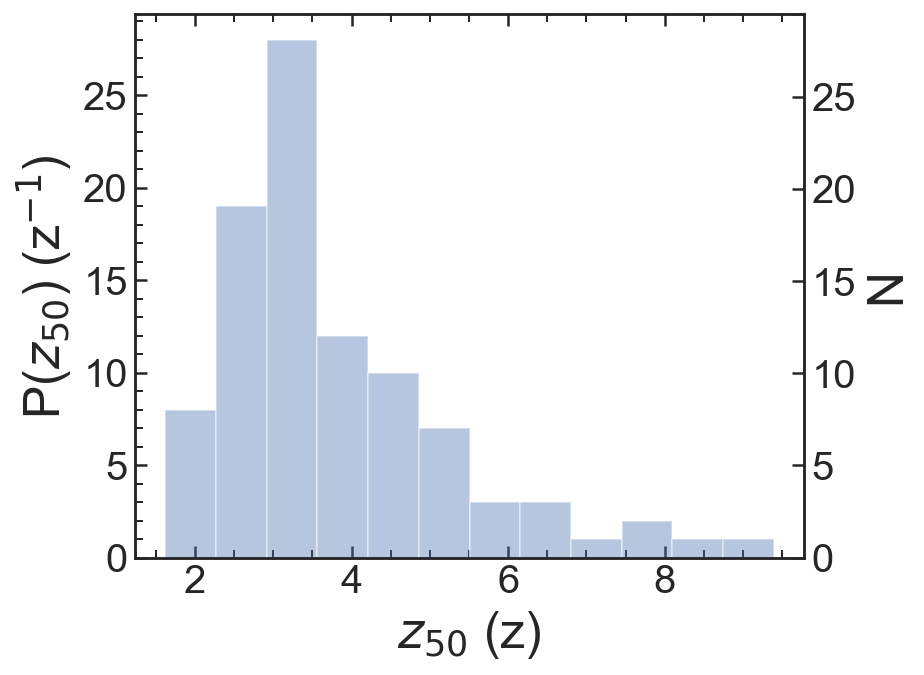

In [336]:
gs = gridspec.GridSpec(1,2, wspace=0.5)

plt.figure(figsize=[15,5])
ax1 = plt.subplot(gs[0])
# sea.distplot(mdb.z_50, ax = ax1,kde_kws= {'linewidth':3})
sea.distplot(mdb.z_50, ax = ax1, kde = False)
ax1a = ax1.twinx()
ax1a.set_ylim(ax1.get_ylim())
ax1a.set_yticks([0,5,10,15,20,25,29.5])
ax1a.set_yticklabels([0,5,10,15,20,25,])
ax1a.yaxis.set_ticks_position('right')
ax1.set_ylabel('P($z_{50}$) (z$^{-1}$)', fontsize=25)
ax1.set_xlabel('$z_{50}$ (z)', fontsize=25)
ax1a.set_ylabel('N', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1a.tick_params(axis='both', which='major', labelsize=20)
ax1.minorticks_on()
# ax1.axvline(3.4)

# ax2 = plt.subplot(gs[1])
# sea.distplot(mdb.t_50, ax = ax2,kde_kws= {'linewidth':3})
# # sea.distplot(mdb.query('z_50 < 3.4').t_50, ax = ax2,kde_kws= {'linewidth':3}, hist = False)
# # sea.distplot(mdb.query('z_50 > 3.4').t_50, ax = ax2,kde_kws= {'linewidth':3}, hist = False)

# # sea.distplot(mdb.t_50, ax = ax2, kde = False)
# ax2a = ax2.twinx()
# ax2a.set_ylim(ax2.get_ylim())
# ax2a.set_yticks([0,5,10,15,18.8])
# ax2a.set_yticklabels([0,5,10,15])
# ax2a.yaxis.set_ticks_position('right')
# ax2.set_ylabel('P($t_{50}$) (Gyr$^{-1}$)', fontsize=25)
# ax2a.set_ylabel('N', fontsize=25)
# ax2.set_xlabel('$t_{50}$ (Gyr)', fontsize=25)
# ax2.tick_params(axis='both', which='major', labelsize=20)
# ax2a.tick_params(axis='both', which='major', labelsize=20)

# ax2a.set_ylabel('N')

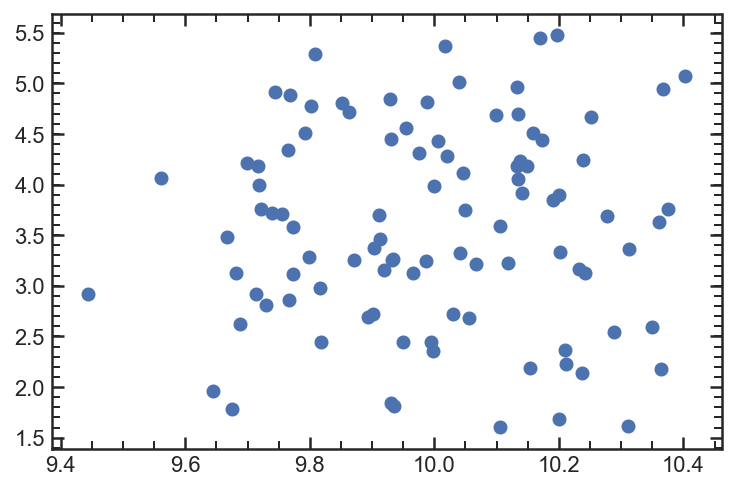

In [146]:
plt.scatter(np.log10(mdb.Sigma1),mdb.t_50)